In [24]:
#@title Import packages
from pathlib import Path
import json
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

## Data Loading

In [25]:
# @title Data loading and imports

# set path for data
root = r'/home/sunr/projects/MCLabRotation/data_Zhong_et_al_2025'
Path(root).mkdir(exist_ok=True)

beh_path = os.path.join(root, 'beh')

### Supervised

In [26]:
'''
sup_bef1 = 'TX108_2023_03_13_1' #example mouse of supervised learning: TX108
sup_bef2 = 'TX108_2023_03_25_1' 
sup_aft1 = 'TX108_2023_03_22_1' 
sup_aft2 = 'TX108_2023_04_01_1'
sup_test1 = 'TX108_2023_03_25_1' 
sup_test2 = 'TX108_2023_04_04_1'
sup_test3 = 'TX108_2023_04_07_1_swap2'
'''

#sup_bef1 = 'TX60_2021_04_10_1'  # example mouse of supervised learning: TX108
#sup_aft1 = 'TX60_2021_05_04_1'
#sup_test1 = 'TX60_2021_06_07_1'

sup_bef1 = 'TX109_2023_03_27_1' #example mouse of supervised learning: TX109
sup_aft1 = 'TX109_2023_04_07_1'
sup_test1 = 'TX109_2023_04_18_1'

### Unsupervised

In [27]:
'''
unsup_bef1 = 'TX119_2023_12_14_1' #example mouse of unsupervised learning: TX119
unsup_bef2 = 'TX119_2023_12_24_1'
unsup_aft1 = 'TX119_2023_12_23_1'
unsup_aft2 = 'TX119_2024_01_06_1'
unsup_test1 = 'TX119_2023_12_24_1'
unsup_test2 = 'TX119_2024_01_07_1'
unsup_test3 = ['TX119_2024_01_09_1_swap1', 'TX119_2024_01_09_1_swap2']
'''

#unsup_bef1 = 'TX88_2022_06_13_2' #use of unsupervised learning: TX119
#unsup_aft1 = 'TX88_2022_06_17_2'
#unsup_test1 = 'TX88_2022_06_20_1'
#unsup_bef1 = 'TX105_2022_10_08_2' 
#unsup_aft1 = 'TX105_2022_10_19_2'
#unsup_test1 = 'TX105_2022_10_21_1'

#unsup_bef1 = 'TX123_2023_12_21_1'  # example mouse of unsupervised learning: TX123
#unsup_aft1 = 'TX123_2024_01_02_1'
#unsup_test1 = 'TX123_2024_01_03_1'

unsup_bef1 = 'TX83_2022_08_17_1'  # example mouse of unsupervised learning: TX83
unsup_aft1 = 'TX83_2022_08_29_1'
unsup_test1 = 'TX83_2022_08_31_1'

### Beh

In [28]:
sup_aft1_beh = np.load(os.path.join(root, 'beh', 'Beh_sup_train1_after_learning.npy'), allow_pickle=1).item()[sup_aft1]
sup_bef1_beh = np.load(os.path.join(root, 'beh', 'Beh_sup_train1_before_learning.npy'), allow_pickle=1).item()[sup_bef1]
print(sup_aft1_beh.keys())

unsup_aft1_beh = np.load(os.path.join(root, 'beh', 'Beh_unsup_train1_after_learning.npy'), allow_pickle=1).item()[unsup_aft1]
unsup_bef1_beh = np.load(os.path.join(root, 'beh', 'Beh_unsup_train1_before_learning.npy'), allow_pickle=1).item()[unsup_bef1]
sup_test1_beh = np.load(os.path.join(root, 'beh', 'Beh_sup_test1.npy'), allow_pickle=1).item()[sup_test1]
unsup_test1_beh = np.load(os.path.join(root, 'beh', 'Beh_unsup_test1.npy'), allow_pickle=1).item()[unsup_test1]

dict_keys(['ntrials', 'trInd', 'trInd_odd', 'trInd_even', 'Trial_start_time', 'Trial_end_time', 'SubjMove', 'Gray_space_time', 'SoundPos', 'SoundTime', 'SoundTimeDelay', 'RewTime', 'RewPos', 'isRew', 'WallType', 'WallIsProbe', 'WallName', 'UniqWalls', 'LickTrind', 'LickTime', 'LickPos', 'Lick_wallName', 'VRposTime', 'VRpos', 'VRposCum', 'ft', 'ft_trInd', 'ft_trInd_odd', 'ft_trInd_even', 'ft_PosCum', 'ft_Pos', 'ft_move', 'ft_isMoving', 'ft_GraySpc', 'ft_CorrSpc', 'ft_WallID', 'ft_RunCum', 'ft_RunSpeed', 'Corridor_Length', 'Gray_Space_length', 'Texture_Length', 'run_pos', 'RewardFr', 'StartFr', 'GrayFr', 'EndFr', 'LickFr', 'SoundFr', 'SoundDelayFr', 'SoundDelPos', 'RunFr', 'BefCueFr', 'AftCueFr', 'stim_id', 'TrialStim', 'StimTrial', 'StimFrame', 'Reward_Mode', 'Reward_Delay_ms'])


### (SVD_ed) Spks

In [29]:
from scipy.stats import zscore

def prepare_data(recording):
    """
    Load and prepare xpos, ypos, z-scored spks for a given recording.
    """
    spk_path = os.path.join(root, 'spk')
    spks = np.load(os.path.join(spk_path, recording + '_neural_data.npy'), allow_pickle=1).item()['spks']
    spks = np.vstack(spks)  
    print(f'Loaded {recording} spks with shape {spks.shape}') # shape[0] should be (neurons, frame)
    spks = zscore(spks, axis=1)
    xpos = np.load(os.path.join(spk_path, recording[:-1] + 'trans.npz'), allow_pickle=1)['xpos']/0.75
    ypos = np.load(os.path.join(spk_path, recording[:-1] + 'trans.npz'), allow_pickle=1)['ypos']/0.5
    U = np.load(os.path.join(spk_path, recording + '_SVD_dec.npy'), allow_pickle=1).item()['U']
    V = np.load(os.path.join(spk_path, recording + '_SVD_dec.npy'), allow_pickle=1).item()['V']

    return spks, xpos, ypos, U, V

In [30]:
# use supervised after and before training 1 to test the pipline
sup_aft1_spks, sup_aft1_xpos, sup_aft1_ypos, sup_aft1_U, sup_aft1_V = prepare_data(sup_aft1)
sup_bef1_spks, sup_bef1_xpos, sup_bef1_ypos, sup_bef1_U, sup_bef1_V = prepare_data(sup_bef1)
sup_test1_spks, sup_test1_xpos, sup_test1_ypos, sup_test1_U, sup_test1_V = prepare_data(sup_test1)
unsup_aft1_spks, unsup_aft1_xpos, unsup_aft1_ypos, unsup_aft1_U, unsup_aft1_V = prepare_data(unsup_aft1)
unsup_bef1_spks, unsup_bef1_xpos, unsup_bef1_ypos, unsup_bef1_U, unsup_bef1_V = prepare_data(unsup_bef1)  
unsup_test1_spks, unsup_test1_xpos, unsup_test1_ypos, unsup_test1_U, unsup_test1_V = prepare_data(unsup_test1)

print(f'Supervised after training 1: {sup_aft1_spks.shape}')

Loaded TX109_2023_04_07_1 spks with shape (89577, 20021)


/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.6.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded TX109_2023_03_27_1 spks with shape (63625, 14586)


/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.6.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded TX109_2023_04_18_1 spks with shape (83309, 17371)


/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.6.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded TX83_2022_08_29_1 spks with shape (52954, 24407)


/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.6.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded TX83_2022_08_17_1 spks with shape (44059, 20428)


/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.6.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded TX83_2022_08_31_1 spks with shape (50689, 33597)


/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.6.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Supervised after training 1: (89577, 20021)


## Get Tuning Neurons

### Bin Raw Spks

In [32]:
from scipy.interpolate import interp1d

def tuning_curves_VR(sn, VRpos, corridor_starts, corridor_ends, beh, num_stimuli=2):
    corr_tot = np.zeros(num_stimuli)
    npts=60
    n_sn = sn.shape[0]
    corridor_tuning = np.zeros((num_stimuli, n_sn, npts), np.float32)
    tcorridor = np.zeros(len(VRpos), "bool")
    for n in range(len(corridor_starts)-1):
        start = int(np.round(corridor_starts[n]))
        end = int(np.round(corridor_ends[n])) #int(np.ceil(whiteSpcFrameInd[n]))
        corr_fr = int(corridor_starts[n]+3) # remove potential boundary effects
        corr_type = beh['ft_WallID'][corr_fr]
        if corr_type == 'rock1' or corr_type == 'circle1':
            icorr = 1
        elif corr_type == 'rock2' or corr_type == 'circle2':
            icorr = 3
        elif corr_type == 'wood1' or corr_type == 'leaf1':
            icorr = 0
        elif corr_type == 'wood2' or corr_type == 'leaf2':
            icorr = 2
        else:  
            continue  # skip if corridor type is not recognized
        valid_mask = (VRpos[start:end] !=0)
        pos_filtered = VRpos[start:end][valid_mask]
        sn_filtered = sn[:, start:end][:,valid_mask]

        if len(pos_filtered) == 0:
            continue  # Skip this corridor if no valid position data

        f = interp1d(pos_filtered, sn_filtered, 
                    bounds_error=False, 
                    fill_value=(sn[:,start], sn[:,end]))
        corridor_tuning[icorr,:,:] += f(np.linspace(0, 1, npts))
        tcorridor[start:end] = icorr
        corr_tot[icorr] += 1
    corridor_tuning /= corr_tot[:,np.newaxis,np.newaxis]
    return corridor_tuning


corridor_starts = sup_aft1_beh['StartFr']
gray_starts = sup_aft1_beh['GrayFr']
corridor_ends = sup_aft1_beh['EndFr']
sup_aft1_vr_pos = sup_aft1_beh['ft_Pos'] / 60
sup_aft1_corridor_tuning = tuning_curves_VR(sup_aft1_spks, sup_aft1_vr_pos, corridor_starts, corridor_ends, sup_aft1_beh)
sup_bef1_corridor_tuning = tuning_curves_VR(sup_bef1_spks, sup_bef1_beh['ft_Pos'] / 60, sup_bef1_beh['StartFr'], sup_bef1_beh['EndFr'], sup_bef1_beh)

unsup_aft1_corridor_tuning = tuning_curves_VR(unsup_aft1_spks, unsup_aft1_beh['ft_Pos'] / 60, unsup_aft1_beh['StartFr'], unsup_aft1_beh['EndFr'], unsup_aft1_beh)
unsup_bef1_corridor_tuning = tuning_curves_VR(unsup_bef1_spks, unsup_bef1_beh['ft_Pos'] / 60, unsup_bef1_beh['StartFr'], unsup_bef1_beh['EndFr'], unsup_bef1_beh)
sup_test1_corridor_tuning = tuning_curves_VR(sup_test1_spks, sup_test1_beh['ft_Pos'] / 60, sup_test1_beh['StartFr'], sup_test1_beh['EndFr'], sup_test1_beh, num_stimuli=4)
unsup_test1_corridor_tuning = tuning_curves_VR(unsup_test1_spks, unsup_test1_beh['ft_Pos'] / 60, unsup_test1_beh['StartFr'], unsup_test1_beh['EndFr'], unsup_test1_beh, num_stimuli=4)


/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:497: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:497: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [9]:
sup_aft1_corridor_tuning.shape

(2, 89577, 60)

### Design Tuning Neuron Filter

The neuron specifically tuning to a corridor pos should satisfy:
- for any of the corridor, the maximun and minimun firing amplitude diff should be larger than 1 (or not and condition) (threshold now 1, but to consider more carefully)
- create 60 gauss curves for 60 pos, calculate corr of each guass with two corridor tuning vecs and the diff of the two tuning vecs, return three 60-length corr vec
- use diff vec's corr vec to locate possible tuning pos i (pos has the max value for specific tunning, has the min value for both tuning)
- calculate corr between gauss(pos i) and three corr vecs
    - neuron specifically tunning to pos i in corridor j: diff vec corr corr & corridor j corr corr > 0.9, corridor ~j corr corr < 0.8
    - neuron tunning to the same pos in two corridors: diff vec corr corr < -0.8, corridor vecs corr corr > 0.9
    - neuron tunning to different pos in two corridors: use corridor vec corr to locate pos

(-1.0, 3.0)

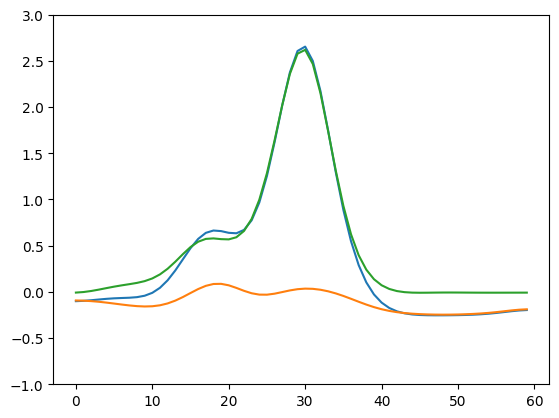

In [226]:
# Example leaf1 tuning neuron
from scipy.ndimage import gaussian_filter1d
plt.plot(gaussian_filter1d(sup_aft1_corridor_tuning[0,47000,:], sigma=3))
plt.plot(gaussian_filter1d(sup_aft1_corridor_tuning[1,47000,:], sigma=3))
plt.plot(gaussian_filter1d(sup_aft1_corridor_tuning[0,47000,:], sigma=3)-gaussian_filter1d(sup_aft1_corridor_tuning[1,47000,:], sigma=3))
plt.ylim([-1, 3])

(-1.0, 3.0)

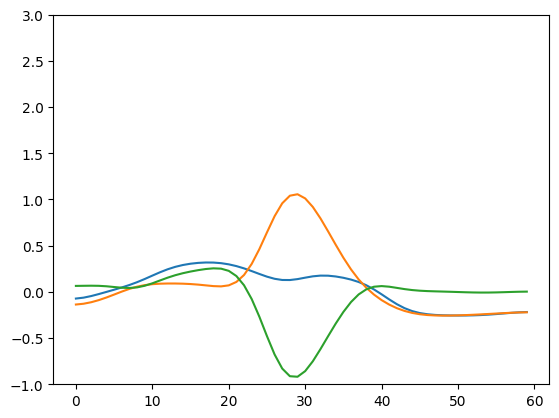

In [70]:
# example both corridor tuning neuron
plt.plot(gaussian_filter1d(sup_aft1_corridor_tuning[0,254,:], sigma=3))
plt.plot(gaussian_filter1d(sup_aft1_corridor_tuning[1,254,:], sigma=3))
plt.plot(gaussian_filter1d(sup_aft1_corridor_tuning[0,254,:], sigma=3)-gaussian_filter1d(sup_aft1_corridor_tuning[1,254,:], sigma=3))
plt.ylim([-1, 3])

neuron i: corridor 1 correlation with Gaussian: 0.9557525505927515, with white noise: -0.002586260286950881
neuron i: corridor 2 correlation with Gaussian: 0.5739378440551293, with white noise: 0.021693438320565354


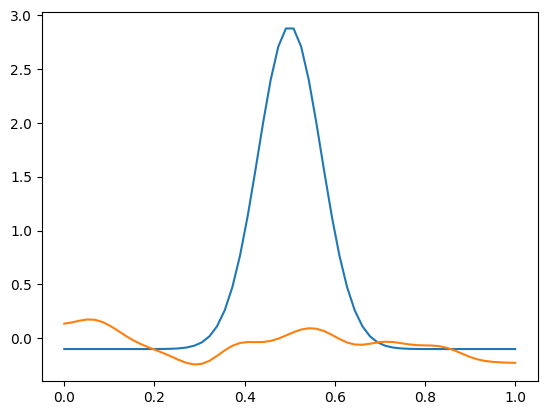

In [ ]:
def gauss(x, A, mu, sigma, B):
    return A * np.exp(-((x-mu)**2)/(2*sigma**2)) + B

def whgite_noise(x, A, sigma, B):
    return A * np.random.normal(0, sigma, len(x)) + B

plt.plot(np.linspace(0, 1, 60), gauss(np.linspace(0, 1, 60), 3, 0.5, 0.07, -0.1))
plt.plot(np.linspace(0, 1, 60), gaussian_filter1d(whgite_noise(np.linspace(0, 1, 60), 5, 0.1, 0), sigma=3))
    
# white noise is not possible to capture information, do not use it
a1 = np.corrcoef(gaussian_filter1d(sup_aft1_corridor_tuning[0,47000,:], sigma = 3), gauss(np.linspace(0, 1, 60), 3, 0.5, 0.07, -0.1))[0,1]
a2 = 0
for i in range(10):
    a2 += np.corrcoef(gaussian_filter1d(sup_aft1_corridor_tuning[0,47000,:], sigma=3), gaussian_filter1d(whgite_noise(np.linspace(0, 1, 60), 5, 0.1, 0), sigma=3))[0,1]
a2 /= 10   

b1 = np.corrcoef(gaussian_filter1d(sup_aft1_corridor_tuning[1,47000,:], sigma=3), gauss(np.linspace(0, 1, 60), 3, 0.5, 0.07, -0.1))[0,1]
b2 = 0
for i in range(10):
    b2 += np.corrcoef(gaussian_filter1d(sup_aft1_corridor_tuning[1,47000,:], sigma=3), gaussian_filter1d(whgite_noise(np.linspace(0, 1, 60), 5, 0.1, 0), sigma=3))[0,1] 
b2 /= 10

print(f'neuron i: corridor 1 correlation with Gaussian: {a1}, with white noise: {a2}')
print(f'neuron i: corridor 2 correlation with Gaussian: {b1}, with white noise: {b2}')

30
0.9194407388180245
0.5984697897482758
0.9427756413474722


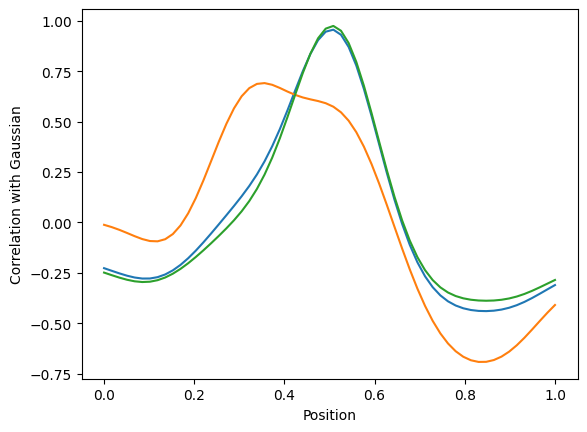

In [ ]:
if (gaussian_filter1d(sup_aft1_corridor_tuning[0,47000,:], sigma=3).max() - 
    gaussian_filter1d(sup_aft1_corridor_tuning[0,47000,:], sigma=3).min() > 1) or (gaussian_filter1d(sup_aft1_corridor_tuning[1,47000,:], sigma=3).max() - 
                                                                                    gaussian_filter1d(sup_aft1_corridor_tuning[1,47000,:], sigma=3).min() > 1):
    a1 = np.zeros(60)
    b1 = np.zeros(60)
    ab1 = np.zeros(60)
    for i in range(60):
        gauss_i = gauss(np.linspace(0, 1, 60), 3, i/60, 0.07, -0.1)
        a_i = np.corrcoef(gaussian_filter1d(sup_aft1_corridor_tuning[0,47000,:], sigma=3), gauss_i)[0,1]
        b_i = np.corrcoef(gaussian_filter1d(sup_aft1_corridor_tuning[1,47000,:], sigma=3), gauss_i)[0,1]
        ab_i = np.corrcoef(gaussian_filter1d(sup_aft1_corridor_tuning[0,47000,:], sigma=3) - gaussian_filter1d(sup_aft1_corridor_tuning[1,47000,:], sigma=3), gauss_i)[0,1]
        a1[i] = a_i
        b1[i] = b_i
        ab1[i] = ab_i
    plt.plot(np.linspace(0, 1, 60), a1, label='Corridor leaf1')
    plt.plot(np.linspace(0, 1, 60), b1, label='Corridor circle1')
    plt.plot(np.linspace(0, 1, 60), ab1, label='Corridor leaf1 - circle1')
    plt.xlabel('Position')
    plt.ylabel('Correlation with Gaussian')

    i = np.argmax(ab1)
    print(i)
    print(np.corrcoef(a1, gauss(np.linspace(0, 1, 60), 3, i/60, 0.07, -0.1))[0,1])
    print(np.corrcoef(b1, gauss(np.linspace(0, 1, 60), 3, i/60, 0.07, -0.1))[0,1])
    print(np.corrcoef(ab1, gauss(np.linspace(0, 1, 60), 3, i/60, 0.07, -0.1))[0,1])

30
0.384211716380979
0.9072222585383268
-0.9533098064031895


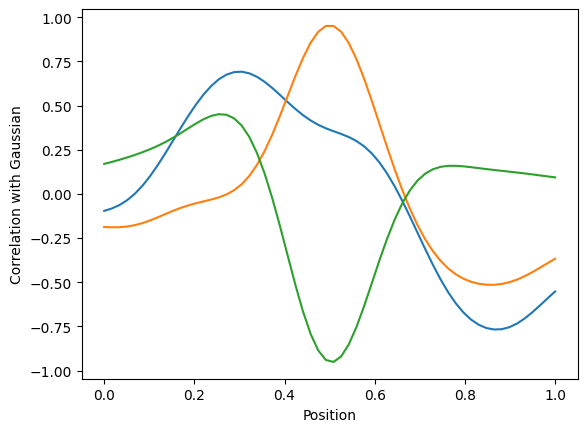

In [69]:
n = 254
if (gaussian_filter1d(sup_aft1_corridor_tuning[0,n,:], sigma=3).max() - 
    gaussian_filter1d(sup_aft1_corridor_tuning[0,n,:], sigma=3).min() > 1) or (gaussian_filter1d(sup_aft1_corridor_tuning[1,n,:], sigma=3).max() - 
                                                                                    gaussian_filter1d(sup_aft1_corridor_tuning[1,n,:], sigma=3).min() > 1):
    a1 = np.zeros(60)
    b1 = np.zeros(60)
    ab1 = np.zeros(60)
    for i in range(60):
        gauss_i = gauss(np.linspace(0, 1, 60), 3, i/60, 0.07, -0.1)
        a_i = np.corrcoef(gaussian_filter1d(sup_aft1_corridor_tuning[0,n,:], sigma=3), gauss_i)[0,1]
        b_i = np.corrcoef(gaussian_filter1d(sup_aft1_corridor_tuning[1,n,:], sigma=3), gauss_i)[0,1]
        ab_i = np.corrcoef(gaussian_filter1d(sup_aft1_corridor_tuning[0,n,:], sigma=3) - gaussian_filter1d(sup_aft1_corridor_tuning[1,n,:], sigma=3), gauss_i)[0,1]
        a1[i] = a_i
        b1[i] = b_i
        ab1[i] = ab_i
    plt.plot(np.linspace(0, 1, 60), a1, label='Corridor leaf1')
    plt.plot(np.linspace(0, 1, 60), b1, label='Corridor circle1')
    plt.plot(np.linspace(0, 1, 60), ab1, label='Corridor leaf1 - circle1')
    plt.xlabel('Position')
    plt.ylabel('Correlation with Gaussian')

    i = np.argmax(abs(ab1)) # could also capture the same tuning of two corridors (if that happens, ab1 and guass curve are negatively correlated, while a1 and b1 are positively correlated) n=200
    # n=1000 have the tunning tendency but not strongly tunning (corr corr around 0.7, not 0.9)
    print(i)
    print(np.corrcoef(a1, gauss(np.linspace(0, 1, 60), 3, i/60, 0.07, -0.1))[0,1])
    print(np.corrcoef(b1, gauss(np.linspace(0, 1, 60), 3, i/60, 0.07, -0.1))[0,1])
    print(np.corrcoef(ab1, gauss(np.linspace(0, 1, 60), 3, i/60, 0.07, -0.1))[0,1])

### Filter Raw Spks (two stimuli version)

In [7]:
from scipy.ndimage import gaussian_filter1d

def gauss(x, A, mu, sigma, B):
    return A * np.exp(-((x-mu)**2)/(2*sigma**2)) + B

def filter_binned_spks(binned_spks, corr_thresh=0.9, diff_thresh=0.9, corr_NoTune_thresh=0.8):
    """
    Designe filter to binned spikes.
    """
    _, nn, npos = binned_spks.shape
    gauss_spks = gaussian_filter1d(binned_spks, sigma=3, axis=2)
    pos = np.zeros(nn)
    corr_type = np.zeros(nn)
    for i in range(nn):
        if (gauss_spks[0,i,:].max() - gauss_spks[0,i,:].min() < 1) and (gauss_spks[1,i,:].max() - gauss_spks[1,i,:].min() < 1):
            pos[i] = -1  # skip if neuron is not tuned
            corr_type[i] = -1
        else:
            a1 = np.zeros(npos)
            b1 = np.zeros(npos)
            ab1 = np.zeros(npos)
            for j in range(npos):
                gauss_j = gauss(np.linspace(0, 1, npos), 3, j/npos, 0.07, -0.1)
                a_j = np.corrcoef(gauss_spks[0,i,:], gauss_j)[0,1]
                b_j = np.corrcoef(gauss_spks[1,i,:], gauss_j)[0,1]
                ab_j = np.corrcoef(gauss_spks[0,i,:] - gauss_spks[1,i,:], gauss_j)[0,1]
                a1[j] = a_j
                b1[j] = b_j
                ab1[j] = ab_j

            pos_i = np.argmax(abs(ab1))  # find position that diff vec with maximum correlation with gauss (positive)
            a_i = np.corrcoef(a1, gauss(np.linspace(0, 1, npos), 3, pos_i/npos, 0.07, -0.1))[0,1]
            b_i = np.corrcoef(b1, gauss(np.linspace(0, 1, npos), 3, pos_i/npos, 0.07, -0.1))[0,1]
            ab_i = np.corrcoef(ab1, gauss(np.linspace(0, 1, npos), 3, pos_i/npos, 0.07, -0.1))[0,1]
            if a_i >= corr_thresh and b_i < corr_NoTune_thresh  and ab_i >= diff_thresh:
                print(f'Neuron {i} is tuned at position {pos_i} in corridor leaf1 with corr: a={a_i}, b={b_i}, ab={ab_i}') if pos_i == 30 else None
                pos[i] = pos_i
                corr_type[i] = 0
            elif b_i >= corr_thresh and a_i < corr_NoTune_thresh and ab_i <= -diff_thresh:
                print(f'Neuron {i} is tuned at position {pos_i} in corridor circle1 with corr: a={a_i}, b={b_i}, ab={ab_i}') if pos_i == 30 else None
                pos[i] = pos_i
                corr_type[i] = 1
            else:
                pos[i] = -1
                corr_type[i] = -1


    return pos, corr_type

def get_tuning_neurons_idx(binned_spks):
    """
    Get tuning neurons based on binned spikes, position, and correlation type after filter.
    """
    # Initialize data structure: {'leaf1': {{0: [], 1: [], 2: [], 3: [], 4: [], 5: [],...}, 'circle1': {...}}
    corr_sets = {'leaf1': {}, 'circle1': {}}
    for i in range(60):
        corr_sets['leaf1'][i] = []
        corr_sets['circle1'][i] = []

    pos, corr_type = filter_binned_spks(binned_spks)

    for n in range(binned_spks.shape[1]):
        if pos[n] == -1:
            continue
        else:
            pos_n = int(pos[n])
            corr_n = 'leaf1' if corr_type[n] == 0 else 'circle1'
            corr_sets[corr_n][pos_n].append(n)

    return corr_sets


In [33]:
sup_aft1_corr_sets = get_tuning_neurons_idx(sup_aft1_corridor_tuning)
sup_bef1_corr_sets = get_tuning_neurons_idx(sup_bef1_corridor_tuning)
unsup_aft1_corr_sets = get_tuning_neurons_idx(unsup_aft1_corridor_tuning)
unsup_bef1_corr_sets = get_tuning_neurons_idx(unsup_bef1_corridor_tuning)
sup_test1_corr_sets = get_tuning_neurons_idx(sup_test1_corridor_tuning)
unsup_test1_corr_sets = get_tuning_neurons_idx(unsup_test1_corridor_tuning)

Neuron 251 is tuned at position 30 in corridor leaf1 with corr: a=0.9488622205394386, b=0.7661215400575455, ab=0.9492981791598164
Neuron 254 is tuned at position 30 in corridor circle1 with corr: a=0.384211716380979, b=0.9072222585383268, ab=-0.9533098064031895
Neuron 704 is tuned at position 30 in corridor leaf1 with corr: a=0.9137319764191042, b=0.41909943691790497, ab=0.9635601993911329
Neuron 1227 is tuned at position 30 in corridor circle1 with corr: a=-0.15308400171670994, b=0.9263089679076435, ab=-0.9203589986946736
Neuron 3383 is tuned at position 30 in corridor leaf1 with corr: a=0.9691910114829635, b=0.6305838033737563, ab=0.969034984836143
Neuron 3529 is tuned at position 30 in corridor leaf1 with corr: a=0.968547812028362, b=0.4276763956556358, ab=0.965116410513445
Neuron 3946 is tuned at position 30 in corridor leaf1 with corr: a=0.9273707325801912, b=0.6031409712076894, ab=0.9682876625685722
Neuron 4090 is tuned at position 30 in corridor circle1 with corr: a=-0.175530345

In [9]:
# @title plot avg activities of tuned neurons in each corridor
def plot_avg_activities(corr_sets, binned_spks, title='', gauss_filter=0):
    """
    Plot average activities of tuned neurons in each corridor.
    """
    if gauss_filter > 0:
        binned_spks = gaussian_filter1d(binned_spks, sigma=gauss_filter, axis=2)    
    fig, axs = plt.subplots(2, 6, figsize=(20, 5))
    fig.suptitle(title)
    for i in np.linspace(5, 55, 6, dtype=int):
        leaf1_neurons = corr_sets['leaf1'][i]
        circle1_neurons = corr_sets['circle1'][i]
        n = i//10
        if len(leaf1_neurons) > 0:
            axs[0, n].plot(np.mean(binned_spks[0, leaf1_neurons, :], axis=0), label='Leaf1')
            axs[0, n].plot(np.mean(binned_spks[1, leaf1_neurons, :], axis=0), label='Circle1')
            axs[0, n].set_title(f'Leaf1 Tuning Pos {i}')
        if len(circle1_neurons) > 0:
            axs[1, n].plot(np.mean(binned_spks[0, circle1_neurons, :], axis=0), label='Leaf1')
            axs[1, n].plot(np.mean(binned_spks[1, circle1_neurons, :], axis=0), label='Circle1')
            axs[1, n].set_title(f'Circle1 Tuning Pos {i}')
    axs[0, 0].legend()
    axs[1, 0].legend()
    plt.tight_layout()
    plt.show()

'''
# Plotting average activities for supervised after training 1
plot_avg_activities(sup_aft1_corr_sets, sup_aft1_corridor_tuning, title='Supervised After Training 1', gauss_filter=0)
# Plotting average activities for supervised before training 1
plot_avg_activities(sup_bef1_corr_sets, sup_bef1_corridor_tuning, title='Supervised Before Training 1', gauss_filter=0)
# Plotting average activities for unsupervised
plot_avg_activities(unsup_aft1_corr_sets, unsup_aft1_corridor_tuning, title='Unsupervised After Training 1', gauss_filter=0)
# Plotting average activities for unsupervised before training 1
plot_avg_activities(unsup_bef1_corr_sets, unsup_bef1_corridor_tuning, title='Unsupervised Before Training 1', gauss_filter=0)
# Plotting average activities for supervised test 1
plot_avg_activities(sup_test1_corr_sets, sup_test1_corridor_tuning, title='Supervised Test 1', gauss_filter=0)
# Plotting average activities for unsupervised test 1
plot_avg_activities(unsup_test1_corr_sets, unsup_test1_corridor_tuning, title='Unsupervised Test 1', gauss_filter=0)
'''

"\n# Plotting average activities for supervised after training 1\nplot_avg_activities(sup_aft1_corr_sets, sup_aft1_corridor_tuning, title='Supervised After Training 1', gauss_filter=0)\n# Plotting average activities for supervised before training 1\nplot_avg_activities(sup_bef1_corr_sets, sup_bef1_corridor_tuning, title='Supervised Before Training 1', gauss_filter=0)\n# Plotting average activities for unsupervised\nplot_avg_activities(unsup_aft1_corr_sets, unsup_aft1_corridor_tuning, title='Unsupervised After Training 1', gauss_filter=0)\n# Plotting average activities for unsupervised before training 1\nplot_avg_activities(unsup_bef1_corr_sets, unsup_bef1_corridor_tuning, title='Unsupervised Before Training 1', gauss_filter=0)\n# Plotting average activities for supervised test 1\nplot_avg_activities(sup_test1_corr_sets, sup_test1_corridor_tuning, title='Supervised Test 1', gauss_filter=0)\n# Plotting average activities for unsupervised test 1\nplot_avg_activities(unsup_test1_corr_sets,

In [10]:
# @title Plotting tuning neuron num distribution
def plot_tuning_neuron_distribution(binned_spks, corr_sets, title=''):
    """
    Plot the distribution of tuning neurons in each corridor.
    """
    leaf1_counts = [len(corr_sets['leaf1'][i]) for i in range(60)]
    circle1_counts = [-len(corr_sets['circle1'][i]) for i in range(60)]
    leaf1_percentage = np.array(leaf1_counts) / (binned_spks.shape[1])
    circle1_percentage = np.array(circle1_counts) / (binned_spks.shape[1]) 
    print(f'Leaf1 Tuning Neurons: {leaf1_percentage.sum()*100:.2f}%')
    print(f'Circle1 Tuning Neurons: {-circle1_percentage.sum()*100:.2f}%')

    plt.figure(figsize=(8, 4))
    plt.bar(range(60), leaf1_percentage, label='Leaf1', alpha=0.7)
    plt.bar(range(60), circle1_percentage, label='Circle1', alpha=0.7)
    plt.vlines(39.5, -0.003, 0.003, color='k', linestyle='--', label='Threshold')
    plt.title(title)
    plt.xlabel('Position')
    plt.ylabel('Proportion of Tuning Neurons')
    plt.ylim([-0.003, 0.003])
    plt.legend()
    plt.show()

    return leaf1_counts, circle1_counts

'''
# Plotting tuning neuron distribution for supervised after training 1
sup_aft_leaf1_counts, sup_aft_circle1_counts = plot_tuning_neuron_distribution(sup_aft1_spks, sup_aft1_corr_sets, title='Supervised After Training 1 Tuning Neuron Distribution')
# Plotting tuning neuron distribution for supervised before training 1
sup_bef_leaf1_counts, sup_bef_circle1_counts = plot_tuning_neuron_distribution(sup_bef1_spks, sup_bef1_corr_sets, title='Supervised Before Training 1 Tuning Neuron Distribution')
# Plotting tuning neuron distribution for unsupervised after training 1
unsup_aft_leaf1_counts, unsup_aft_circle1_counts = plot_tuning_neuron_distribution(unsup_aft1_spks, unsup_aft1_corr_sets, title='Unsupervised After Training 1 Tuning Neuron Distribution')
# Plotting tuning neuron distribution for unsupervised before training 1
unsup_bef_leaf1_counts, unsup_bef_circle1_counts = plot_tuning_neuron_distribution(unsup_bef1_spks, unsup_bef1_corr_sets, title='Unsupervised Before Training 1 Tuning Neuron Distribution')
# Plotting tuning neuron distribution for supervised test 1
sup_test_leaf1_counts, sup_test_circle1_counts = plot_tuning_neuron_distribution(sup_test1_spks, sup_test1_corr_sets, title='Supervised Test 1 Tuning Neuron Distribution')
# Plotting tuning neuron distribution for unsupervised test 1
unsup_test_leaf1_counts, unsup_test_circle1_counts = plot_tuning_neuron_distribution(unsup_test1_spks, unsup_test1_corr_sets, title='Unsupervised Test 1 Tuning Neuron Distribution')
'''

"\n# Plotting tuning neuron distribution for supervised after training 1\nsup_aft_leaf1_counts, sup_aft_circle1_counts = plot_tuning_neuron_distribution(sup_aft1_spks, sup_aft1_corr_sets, title='Supervised After Training 1 Tuning Neuron Distribution')\n# Plotting tuning neuron distribution for supervised before training 1\nsup_bef_leaf1_counts, sup_bef_circle1_counts = plot_tuning_neuron_distribution(sup_bef1_spks, sup_bef1_corr_sets, title='Supervised Before Training 1 Tuning Neuron Distribution')\n# Plotting tuning neuron distribution for unsupervised after training 1\nunsup_aft_leaf1_counts, unsup_aft_circle1_counts = plot_tuning_neuron_distribution(unsup_aft1_spks, unsup_aft1_corr_sets, title='Unsupervised After Training 1 Tuning Neuron Distribution')\n# Plotting tuning neuron distribution for unsupervised before training 1\nunsup_bef_leaf1_counts, unsup_bef_circle1_counts = plot_tuning_neuron_distribution(unsup_bef1_spks, unsup_bef1_corr_sets, title='Unsupervised Before Training 1

In [12]:
# @title Plotting tuning neuron positions
def plot_tuning_neuron_positions(corr_sets, xpos, ypos, title=''):
    """
    Plot the positions of tuning neurons in each corridor 
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(title)

    # 40 positions (0-39)
    colors = plt.cm.viridis(np.linspace(0, 1, 40))

    # Left subplot: leaf1 tuning neurons
    ax1.axis('off')

    # Plot all neurons as background
    ax1.scatter(-ypos, xpos, c='k', s=0.1, alpha=0.2)

    for pos in range(40): 
        neurons_at_pos = corr_sets['leaf1'][pos]
        if len(neurons_at_pos) > 0:

            ax1.scatter(-ypos[neurons_at_pos], xpos[neurons_at_pos], 
                        c=[colors[pos]], s=5, alpha=0.9)

            ax1.text(-0.1, 0.5, 'medial', transform=ax1.transAxes)
            ax1.text(0.95, 0.5, 'lateral', transform=ax1.transAxes)
            ax1.text(0.4, 0.97, 'anterior', transform=ax1.transAxes)
            ax1.text(0.4, 0, 'posterior', transform=ax1.transAxes)
            ax1.set_title('Leaf1 Tuning Neurons')

    # Right subplot: circle1 tuning neurons
    ax2.axis('off')

    # Plot all neurons as background
    ax2.scatter(-ypos, xpos, c='k', s=0.1, alpha=0.2)

    for pos in range(40):  
        neurons_at_pos = corr_sets['circle1'][pos]
        if len(neurons_at_pos) > 0:

            ax2.scatter(-ypos[neurons_at_pos], xpos[neurons_at_pos],
                        c=[colors[pos]], s=5, alpha=0.9)

            ax2.text(-0.1, 0.5, 'medial', transform=ax2.transAxes)
            ax2.text(0.95, 0.5, 'lateral', transform=ax2.transAxes)
            ax2.text(0.4, 0.97, 'anterior', transform=ax2.transAxes)
            ax2.text(0.4, 0, 'posterior', transform=ax2.transAxes)
            ax2.set_title('Circle1 Tuning Neurons')

     # colorbar
    char_ax = fig.add_axes([1, 0.15, 0.01, 0.6])  # left, bottom, width, height

    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=39))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=char_ax)
    cbar.set_label('Position (0-39)', rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

'''
plot_tuning_neuron_positions(sup_aft1_corr_sets, sup_aft1_xpos, sup_aft1_ypos, title='Supervised After Training 1 - TuningNeuron Positions')
plot_tuning_neuron_positions(sup_bef1_corr_sets, sup_bef1_xpos, sup_bef1_ypos, title='Supervised Before Training 1 - TuningNeuron Positions')
plot_tuning_neuron_positions(unsup_aft1_corr_sets, unsup_aft1_xpos, unsup_aft1_ypos, title='Unsupervised After Training 1 - TuningNeuron Positions')
plot_tuning_neuron_positions(unsup_bef1_corr_sets, unsup_bef1_xpos, unsup_bef1_ypos, title='Unsupervised Before Training 1 - TuningNeuron Positions')
plot_tuning_neuron_positions(sup_test1_corr_sets, sup_test1_xpos, sup_test1_ypos, title='Supervised Test 1 - TuningNeuron Positions')
plot_tuning_neuron_positions(unsup_test1_corr_sets, unsup_test1_xpos, unsup_test1_ypos, title='Unsupervised Test 1 - TuningNeuron Positions')
'''

"\nplot_tuning_neuron_positions(sup_aft1_corr_sets, sup_aft1_xpos, sup_aft1_ypos, title='Supervised After Training 1 - TuningNeuron Positions')\nplot_tuning_neuron_positions(sup_bef1_corr_sets, sup_bef1_xpos, sup_bef1_ypos, title='Supervised Before Training 1 - TuningNeuron Positions')\nplot_tuning_neuron_positions(unsup_aft1_corr_sets, unsup_aft1_xpos, unsup_aft1_ypos, title='Unsupervised After Training 1 - TuningNeuron Positions')\nplot_tuning_neuron_positions(unsup_bef1_corr_sets, unsup_bef1_xpos, unsup_bef1_ypos, title='Unsupervised Before Training 1 - TuningNeuron Positions')\nplot_tuning_neuron_positions(sup_test1_corr_sets, sup_test1_xpos, sup_test1_ypos, title='Supervised Test 1 - TuningNeuron Positions')\nplot_tuning_neuron_positions(unsup_test1_corr_sets, unsup_test1_xpos, unsup_test1_ypos, title='Unsupervised Test 1 - TuningNeuron Positions')\n"

## Pos Bin Correlation and Dimension Reduction

1. whether doing PCA to all neurons, then pick out tuning neurons or doing PCA to all tuning neurons<br>
    try all neurons here
2. temporal PCA (N*T to N*K) or spatial PCA (N*T to K*T) --> temporal PCA
3. How to deal with trials (using all the neural frames together, or subgroup but many times)

### Corr Matrix (RDM)

/tmp/ipykernel_34377/1038528757.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


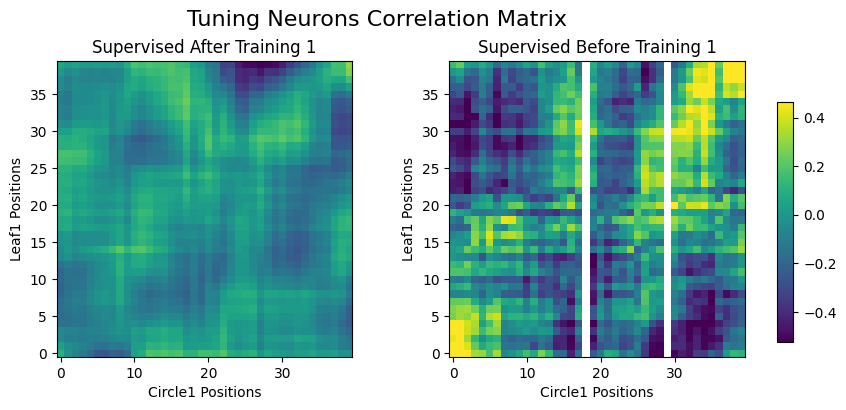

/tmp/ipykernel_34377/1038528757.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


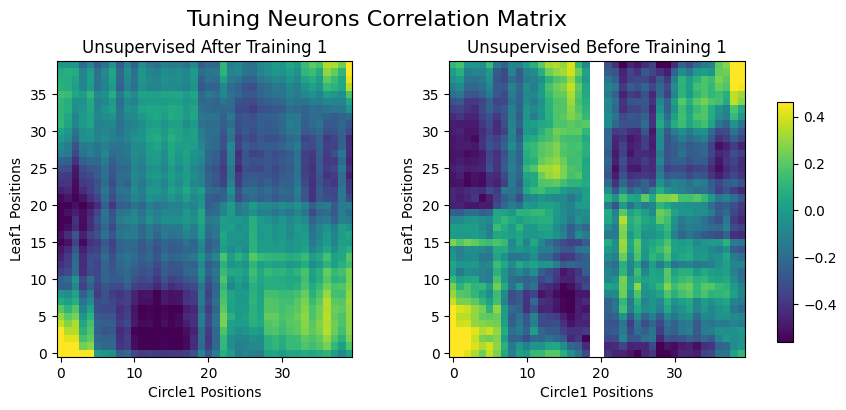

/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 2.4565753439151287e-12
  return f(*arrays, *other_args, **kwargs)
/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.770744835317413e-13
  return f(*arrays, *other_args, **kwargs)


Original shape: (40, 40) -> Aligned shape: (38, 38)
Original shape: (40, 40) -> Aligned shape: (38, 38)
Ri distance for supervised after vs before training 1: 3638.880345725134
Ri distance for unsupervised after vs before training 1: 1164.142460701981
RV coefficient for supervised after vs before training 1: 0.44941714675598404
RV coefficient for unsupervised after vs before training 1: 0.7277951550312657
Frobenius norm for supervised after vs before training 1: 9.96371067262089
Frobenius norm for unsupervised after vs before training 1: 9.265287650113981


In [532]:
from sklearn.metrics.pairwise import cosine_similarity

n_PCs = 20

def corr_matrix_per_posbin(U, corr_sets, n_PCs=200):
    spks_SVDed = U.T[:, :n_PCs]
    corr_matrix = np.zeros((40, 40))
    for pos_i in range(40):
        for pos_j in range(40):
            leaf1_neurons = corr_sets['leaf1'][pos_i]
            circle1_neurons = corr_sets['circle1'][pos_j]
            if len(leaf1_neurons) > 0 and len(circle1_neurons) > 0:
                U_pos_leaf = np.mean(spks_SVDed[leaf1_neurons, :n_PCs], axis=0).reshape(1, -1)
                U_pos_circle = np.mean(spks_SVDed[circle1_neurons, :n_PCs], axis=0).reshape(1, -1)
                corr_matrix[pos_i, pos_j] = cosine_similarity(U_pos_leaf, U_pos_circle)[0,0]
            else:
                corr_matrix[pos_i, pos_j] = np.nan
    return corr_matrix

def visualize_corr_matrix1(U1, U2, corr_sets1, corr_sets2, n_PCs, title1='', title2='', vmin=None, vmax=None):

    # Calculate correlation matrices
    corr_matrix_sup_aft = corr_matrix_per_posbin(U1, corr_sets1, n_PCs=n_PCs)
    corr_matrix_sup_bef = corr_matrix_per_posbin(U2, corr_sets2, n_PCs=n_PCs)

    # Find common color scale
    
    vmin = np.percentile(
        np.concatenate((corr_matrix_sup_aft[~np.isnan(corr_matrix_sup_aft)], 
                        corr_matrix_sup_bef[~np.isnan(corr_matrix_sup_bef)])), 
        1)
    vmax = np.percentile(
        np.concatenate((corr_matrix_sup_aft[~np.isnan(corr_matrix_sup_aft)], 
                        corr_matrix_sup_bef[~np.isnan(corr_matrix_sup_bef)])), 
        99)
    
    #vmin = -0.15
    #vmax = 0.15


    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle('Tuning Neurons Correlation Matrix', fontsize=16)

    im0 = ax[0].imshow(corr_matrix_sup_aft, cmap='viridis', vmin=vmin, vmax=vmax)
    ax[0].set_title(title1)
    ax[0].set_xlabel('Circle1 Positions')
    ax[0].set_ylabel('Leaf1 Positions')
    ax[0].invert_yaxis()
    ax[0].grid(False)

    im1 = ax[1].imshow(corr_matrix_sup_bef, cmap='viridis', vmin=vmin, vmax=vmax)
    ax[1].set_title(title2)
    ax[1].set_xlabel('Circle1 Positions')
    ax[1].set_ylabel('Leaf1 Positions')
    ax[1].invert_yaxis()
    ax[1].grid(False)

    # Add single colorbar for both subplots
    char_ax = fig.add_axes([1, 0.15, 0.02, 0.6])  # left, bottom, width, height
    fig.colorbar(im0, cax=char_ax, orientation='vertical')
    plt.tight_layout()
    plt.show()

    return corr_matrix_sup_aft, corr_matrix_sup_bef

# Visualize correlation matrices for supervised after and before training 1
sup_train1_cm1, sup_train1_cm2 = visualize_corr_matrix1(sup_aft1_U, sup_bef1_U, sup_aft1_corr_sets, sup_bef1_corr_sets, n_PCs,
                      title1='Supervised After Training 1', 
                      title2='Supervised Before Training 1')
# Visualize correlation matrices for unsupervised after and before training 1
unsup_train1_cm1, unsup_train1_cm2 = visualize_corr_matrix1(unsup_aft1_U, unsup_bef1_U, unsup_aft1_corr_sets, unsup_bef1_corr_sets, n_PCs,
                      title1='Unsupervised After Training 1', 
                      title2='Unsupervised Before Training 1')


sup_train1_cm1_aligned, sup_train1_cm2_aligned, _ = align_correlation_matrices(sup_train1_cm1, sup_train1_cm2)
unsup_train1_cm1_aligned, unsup_train1_cm2_aligned, _ = align_correlation_matrices(unsup_train1_cm1, unsup_train1_cm2)


from scipy.linalg import logm
Ri_dist_sup_train1 = np.linalg.norm(logm(np.linalg.inv(sup_train1_cm1_aligned) @ sup_train1_cm2_aligned), ord='fro')
Ri_dist_unsup_train1 = np.linalg.norm(logm(np.linalg.inv(unsup_train1_cm1_aligned) @ unsup_train1_cm2_aligned), ord='fro')
print(f'Ri distance for supervised after vs before training 1: {Ri_dist_sup_train1}')
print(f'Ri distance for unsupervised after vs before training 1: {Ri_dist_unsup_train1}')

def rv_coefficient(X, Y):
    K = X @ X.T
    L = Y @ Y.T
    return np.trace(K @ L) / np.sqrt(np.trace(K @ K) * np.trace(L @ L))

rv = rv_coefficient(sup_train1_cm1_aligned, sup_train1_cm2_aligned)
print(f'RV coefficient for supervised after vs before training 1: {rv}')

rv = rv_coefficient(unsup_train1_cm1_aligned, unsup_train1_cm2_aligned)
print(f'RV coefficient for unsupervised after vs before training 1: {rv}')

frob_norm_sup_train1 = np.linalg.norm(sup_train1_cm1_aligned - sup_train1_cm2_aligned, ord='fro')
frob_norm_unsup_train1 = np.linalg.norm(unsup_train1_cm1_aligned - unsup_train1_cm2_aligned, ord='fro')
print(f'Frobenius norm for supervised after vs before training 1: {frob_norm_sup_train1}')
print(f'Frobenius norm for unsupervised after vs before training 1: {frob_norm_unsup_train1}')


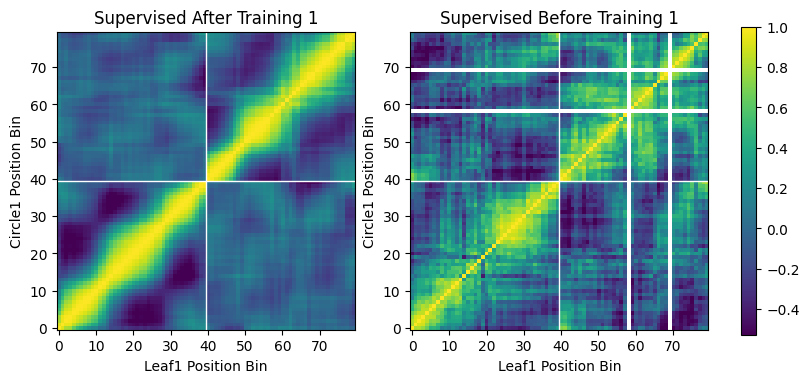

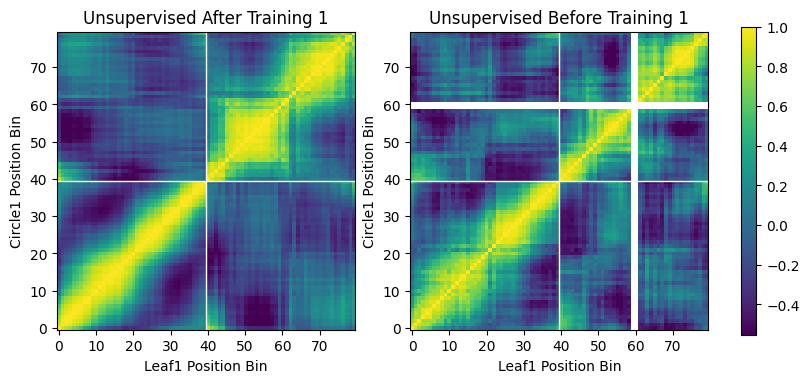

Original shape: (80, 80) -> Aligned shape: (78, 78)
Original shape: (80, 80) -> Aligned shape: (78, 78)


/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.1631647949310093e-12
  return f(*arrays, *other_args, **kwargs)


Ri distance for supervised after vs before training 1: 4254.629615950816
Ri distance for unsupervised after vs before training 1: 9357.476494503377
RV coefficient for supervised after vs before training 1: 0.4641179352877671
RV coefficient for unsupervised after vs before training 1: 0.800892922489108
Frobenius norm for supervised after vs before training 1: 24.927425926225677
Frobenius norm for unsupervised after vs before training 1: 17.412089870879704


/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.907029747031475e-12
  return f(*arrays, *other_args, **kwargs)


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def corr_matrix_all_posbins(U, corr_sets, n_PCs=200):
    """
    Returns an 80×80 cosine‐similarity matrix over:
      • bins 0–39: leaf1 pos bins
      • bins 40–79: circle1 pos bins
    """
    spks_SVDed = U.T[:, :n_PCs] # shape: (n_neurons, n_PCs)

    leaf_bins = [corr_sets['leaf1'][i] for i in sorted(corr_sets['leaf1'].keys())]
    circle_bins = [corr_sets['circle1'][i] for i in sorted(corr_sets['circle1'].keys())]
    pos_bins = leaf_bins[:40] + circle_bins[:40]  

    n_bins = len(pos_bins) # should be 80
    mean_act = np.zeros((n_bins, n_PCs), dtype=float)
    valid = np.zeros(n_bins, dtype=bool)

    for idx, neuron_inds in enumerate(pos_bins):
        if len(neuron_inds) > 0:
            mean_act[idx] = spks_SVDed[neuron_inds].mean(axis=0)
            valid[idx] = True

    valid_idx = np.nonzero(valid)[0]
    cosim_valid = cosine_similarity(mean_act[valid])

    corr_matrix = np.full((n_bins, n_bins), np.nan)
    for i, bi in enumerate(valid_idx):
        for j, bj in enumerate(valid_idx):
            corr_matrix[bi, bj] = cosim_valid[i, j]

    return corr_matrix

def visualize_corr_matrix(U1, U2, corr_sets1, corr_sets2, n_PCs,
                          title1='', title2='', vmin=None, vmax=None):
    cm1 = corr_matrix_all_posbins(U1, corr_sets1, n_PCs=n_PCs)
    cm2 = corr_matrix_all_posbins(U2, corr_sets2, n_PCs=n_PCs)

    if vmin is None or vmax is None:
        all_vals = np.concatenate([cm1[np.isfinite(cm1)], cm2[np.isfinite(cm2)]])
        vmin, vmax = np.percentile(all_vals, [1, 99])

    #vmax = 0.15
    #vmin = -0.15

    fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

    ticks = list(range(0, 80, 10))
    labels = [str(t) for t in ticks]

    for ax, cm, title in zip(axes, (cm1, cm2), (title1, title2)):
        im = ax.imshow(cm, cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.set_xticks(ticks);      
        ax.set_xticklabels(labels)
        ax.set_yticks(ticks)
        ax.set_yticklabels(labels)

        ax.axhline(39.5, color='w', linewidth=1)
        ax.axvline(39.5, color='w', linewidth=1)
        ax.invert_yaxis()
        ax.set_xlabel('Leaf1 Position Bin')
        ax.set_ylabel('Circle1 Position Bin')

    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, orientation='vertical')
    plt.show()

    return cm1, cm2


n_PCs = 20

# Supervised after vs before training 1
sup_train1_cm1, sup_train1_cm2 = visualize_corr_matrix(
    sup_aft1_U, sup_bef1_U,
    sup_aft1_corr_sets, sup_bef1_corr_sets,
    n_PCs,
    title1='Supervised After Training 1',
    title2='Supervised Before Training 1'
)

# Unsupervised after vs before training 1
unsup_aft1_cm1, unsup_aft1_cm2 = visualize_corr_matrix(
    unsup_aft1_U, unsup_bef1_U,
    unsup_aft1_corr_sets, unsup_bef1_corr_sets,
    n_PCs,
    title1='Unsupervised After Training 1',
    title2='Unsupervised Before Training 1'
)

def align_correlation_matrices(cm1, cm2):
    """
    Align two correlation matrices by removing NaN rows and columns to make them the same size.
         """
    # Find rows and columns that are NOT all NaN in cm2
    valid_rows = ~np.isnan(cm2).all(axis=1)
    valid_cols = ~np.isnan(cm2).all(axis=0)
         
    # For symmetric matrices, use the intersection of valid rows and columns
    valid_indices = np.logical_and(valid_rows, valid_cols)
         
    # Remove the same rows and columns from both matrices
    cm1_aligned = cm1[np.ix_(valid_indices, valid_indices)]
    cm2_aligned = cm2[np.ix_(valid_indices, valid_indices)]
         
    print(f"Original shape: {cm1.shape} -> Aligned shape: {cm1_aligned.shape}")
         
    return cm1_aligned, cm2_aligned, valid_indices


sup_train1_cm1_aligned, sup_train1_cm2_aligned, _ = align_correlation_matrices(sup_train1_cm1, sup_train1_cm2)
unsup_aft1_cm1_aligned, unsup_aft1_cm2_aligned, _ = align_correlation_matrices(unsup_aft1_cm1, unsup_aft1_cm2)


from scipy.linalg import logm
Ri_dist_sup_train1 = np.linalg.norm(logm(np.linalg.inv(sup_train1_cm1_aligned) @ sup_train1_cm2_aligned), ord='fro')
Ri_dist_unsup_train1 = np.linalg.norm(logm(np.linalg.inv(unsup_aft1_cm1_aligned) @ unsup_aft1_cm2_aligned), ord='fro')
print(f'Ri distance for supervised after vs before training 1: {Ri_dist_sup_train1}')
print(f'Ri distance for unsupervised after vs before training 1: {Ri_dist_unsup_train1}')

def rv_coefficient(X, Y):
    K = X @ X.T
    L = Y @ Y.T
    return np.trace(K @ L) / np.sqrt(np.trace(K @ K) * np.trace(L @ L))

rv = rv_coefficient(sup_train1_cm1_aligned, sup_train1_cm2_aligned)
print(f'RV coefficient for supervised after vs before training 1: {rv}')

rv = rv_coefficient(unsup_aft1_cm1_aligned, unsup_aft1_cm2_aligned)
print(f'RV coefficient for unsupervised after vs before training 1: {rv}')

frob = np.linalg.norm(sup_train1_cm1_aligned - sup_train1_cm2_aligned, ord='fro')
print(f'Frobenius norm for supervised after vs before training 1: {frob}')

frob = np.linalg.norm(unsup_aft1_cm1_aligned - unsup_aft1_cm2_aligned, ord='fro')
print(f'Frobenius norm for unsupervised after vs before training 1: {frob}')


### Remove Neuron Num Effect 
- avg of larger group of neurons is more smoothe

/tmp/ipykernel_38732/4113378385.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


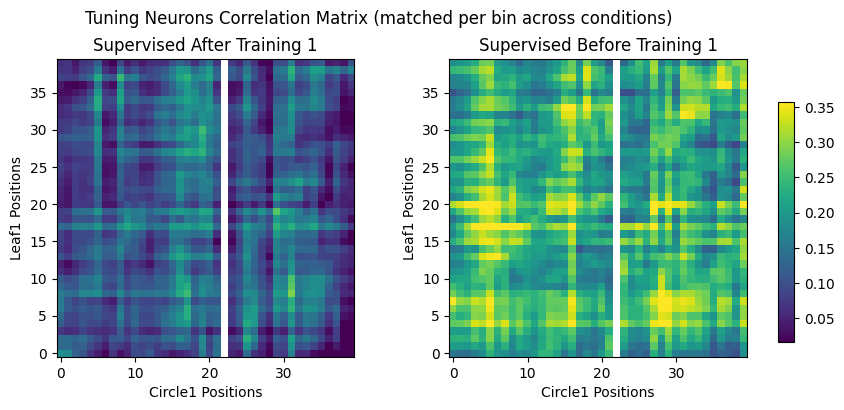

[Matched] valid leaf bins: 40/40; median used/leaf bin=13.5
[Matched] valid circle bins: 39/40; median used/circle bin=11.0


/tmp/ipykernel_38732/4113378385.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


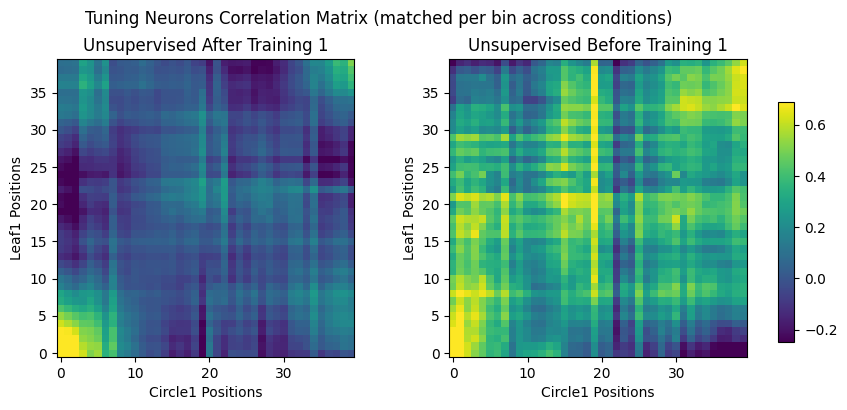

[Matched] valid leaf bins: 40/40; median used/leaf bin=15.5
[Matched] valid circle bins: 40/40; median used/circle bin=7.0
Original shape: (40, 40) -> Aligned shape: (39, 39)
Original shape: (40, 40) -> Aligned shape: (40, 40)
Ri distance for supervised after vs before training 1: 1334.7064678652573
Ri distance for unsupervised after vs before training 1: 3773.3486196211365
RV coefficient for supervised after vs before training 1: 0.9653886303946968
RV coefficient for unsupervised after vs before training 1: 0.14195842466974065
Frobenius norm for supervised after vs before training 1: 5.445895179170431
Frobenius norm for unsupervised after vs before training 1: 14.013870755392055


/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.296461822554589e-13
  return f(*arrays, *other_args, **kwargs)
/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 1.551973440753036e-12
  return f(*arrays, *other_args, **kwargs)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def corr_matrix_per_posbin_matched(U_aft, corr_sets_aft, U_bef, corr_sets_bef,
                                   n_PCs=200, random_state=None):
    rng = np.random.default_rng(random_state)

    # (n_neurons, n_PCs)
    X_aft = U_aft.T[:, :n_PCs]
    X_bef = U_bef.T[:, :n_PCs]

    # gather indices for 40 leaf bins and 40 circle bins for each condition
    leaf_aft = [np.asarray(corr_sets_aft['leaf1'][i],   dtype=int) for i in range(40)]
    circle_aft = [np.asarray(corr_sets_aft['circle1'][j], dtype=int) for j in range(40)]
    leaf_bef = [np.asarray(corr_sets_bef['leaf1'][i],   dtype=int) for i in range(40)]
    circle_bef = [np.asarray(corr_sets_bef['circle1'][j], dtype=int) for j in range(40)]

    # matched counts across conditions for each bin
    n_used_leaf = np.array([min(len(leaf_aft[i]),   len(leaf_bef[i]))   for i in range(40)], dtype=int)
    n_used_circle = np.array([min(len(circle_aft[j]), len(circle_bef[j])) for j in range(40)], dtype=int)
    valid_leaf = n_used_leaf   > 0
    valid_circle = n_used_circle > 0

    mean_leaf_aft = np.zeros((40, n_PCs))
    mean_leaf_bef = np.zeros((40, n_PCs))
    mean_circle_aft = np.zeros((40, n_PCs))
    mean_circle_bef = np.zeros((40, n_PCs))

    for i in range(40):
        m = n_used_leaf[i]
        if m > 0:
            ia = leaf_aft[i]; ib = leaf_bef[i]
            sel_a = ia if len(ia) == m else rng.choice(ia, size=m, replace=False)
            sel_b = ib if len(ib) == m else rng.choice(ib, size=m, replace=False)
            mean_leaf_aft[i] = X_aft[sel_a].mean(axis=0)
            mean_leaf_bef[i] = X_bef[sel_b].mean(axis=0)

    for j in range(40):
        m = n_used_circle[j]
        if m > 0:
            ia = circle_aft[j]; ib = circle_bef[j]
            sel_a = ia if len(ia) == m else rng.choice(ia, size=m, replace=False)
            sel_b = ib if len(ib) == m else rng.choice(ib, size=m, replace=False)
            mean_circle_aft[j] = X_aft[sel_a].mean(axis=0)
            mean_circle_bef[j] = X_bef[sel_b].mean(axis=0)

    # cosine similarities only on valid rows/cols, then expand to 40x40 with NaNs
    cm_aft = np.full((40, 40), np.nan)
    cm_bef = np.full((40, 40), np.nan)

    if valid_leaf.any() and valid_circle.any():
        aft_valid = cosine_similarity(mean_leaf_aft[valid_leaf], mean_circle_aft[valid_circle])
        bef_valid = cosine_similarity(mean_leaf_bef[valid_leaf], mean_circle_bef[valid_circle])

        rows = np.where(valid_leaf)[0]
        cols = np.where(valid_circle)[0]
        for r_i, i in enumerate(rows):
            for c_j, j in enumerate(cols):
                cm_aft[i, j] = aft_valid[r_i, c_j]
                cm_bef[i, j] = bef_valid[r_i, c_j]

    return cm_aft, cm_bef, n_used_leaf, n_used_circle, valid_leaf, valid_circle


def visualize_corr_matrix1_matched(U_aft, U_bef, corr_sets_aft, corr_sets_bef,
                                   n_PCs, title1='', title2='', vmin=None, vmax=None,
                                   random_state=None):
    (cm_aft, cm_bef, n_used_leaf, n_used_circle, valid_leaf, valid_circle) = corr_matrix_per_posbin_matched(
        U_aft, corr_sets_aft, U_bef, corr_sets_bef, n_PCs=n_PCs, random_state=random_state)

    # color scale from finite values 
    if vmin is None or vmax is None:
        all_vals = np.concatenate([cm_aft[np.isfinite(cm_aft)], cm_bef[np.isfinite(cm_bef)]]) \
                   if np.isfinite(cm_aft).any() and np.isfinite(cm_bef).any() else np.array([0.0])
        vmin, vmax = np.percentile(all_vals, [1, 99]) if all_vals.size > 1 else (-1.0, 1.0)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle('Tuning Neurons Correlation Matrix (matched per bin across conditions)', fontsize=12)

    im0 = ax[0].imshow(cm_aft, cmap='viridis', vmin=vmin, vmax=vmax)
    ax[0].set_title(title1)
    ax[0].set_xlabel('Circle1 Positions')
    ax[0].set_ylabel('Leaf1 Positions')
    ax[0].invert_yaxis()
    ax[0].grid(False)

    im1 = ax[1].imshow(cm_bef, cmap='viridis', vmin=vmin, vmax=vmax)
    ax[1].set_title(title2)
    ax[1].set_xlabel('Circle1 Positions')
    ax[1].set_ylabel('Leaf1 Positions')
    ax[1].invert_yaxis()
    ax[1].grid(False)

    # single colorbar for both subplots
    cax = fig.add_axes([1.0, 0.15, 0.02, 0.6])  # left, bottom, width, height
    fig.colorbar(im0, cax=cax, orientation='vertical')
    plt.tight_layout()
    plt.show()

    print(f"[Matched] valid leaf bins: {valid_leaf.sum()}/40; median used/leaf bin={np.median(n_used_leaf[valid_leaf]) if valid_leaf.any() else 0}")
    print(f"[Matched] valid circle bins: {valid_circle.sum()}/40; median used/circle bin={np.median(n_used_circle[valid_circle]) if valid_circle.any() else 0}")

    return cm_aft, cm_bef

def align_correlation_matrices(cm1, cm2):
    """
    Align two correlation matrices by removing NaN rows and columns to make them the same size.
    """
    valid_rows = ~np.isnan(cm2).all(axis=1)
    valid_cols = ~np.isnan(cm2).all(axis=0)
         
    # For symmetric matrices, use the intersection of valid rows and columns
    valid_indices = np.logical_and(valid_rows, valid_cols)
         
    # Remove the same rows and columns from both matrices
    cm1_aligned = cm1[np.ix_(valid_indices, valid_indices)]
    cm2_aligned = cm2[np.ix_(valid_indices, valid_indices)]
         
    print(f"Original shape: {cm1.shape} -> Aligned shape: {cm1_aligned.shape}")
         
    return cm1_aligned, cm2_aligned, valid_indices


n_PCs1 = 50
n_PCs2 = 10

# Supervised after vs before (matched per-bin counts across conditions)
sup_train1_cm1, sup_train1_cm2 = visualize_corr_matrix1_matched(
    sup2_aft1_svd.T, sup2_bef1_svd.T, sup2_aft1_corr_sets, sup2_bef1_corr_sets, n_PCs1,
    title1='Supervised After Training 1',
    title2='Supervised Before Training 1',
    random_state=0
)

# Unsupervised after vs before (matched per-bin counts across conditions)
unsup_train1_cm1, unsup_train1_cm2 = visualize_corr_matrix1_matched(
    unsup2_aft1_svd.T, unsup2_bef1_svd.T, unsup2_aft1_corr_sets, unsup2_bef1_corr_sets, n_PCs2,
    title1='Unsupervised After Training 1',
    title2='Unsupervised Before Training 1',
    random_state=0
)

sup_train1_cm1_aligned, sup_train1_cm2_aligned, _ = align_correlation_matrices(sup_train1_cm1, sup_train1_cm2)
unsup_train1_cm1_aligned, unsup_train1_cm2_aligned, _ = align_correlation_matrices(unsup_train1_cm1, unsup_train1_cm2)

from scipy.linalg import logm
Ri_dist_sup_train1 = np.linalg.norm(logm(np.linalg.inv(sup_train1_cm1_aligned) @ sup_train1_cm2_aligned), ord='fro')
Ri_dist_unsup_train1 = np.linalg.norm(logm(np.linalg.inv(unsup_train1_cm1_aligned) @ unsup_train1_cm2_aligned), ord='fro')
print(f'Ri distance for supervised after vs before training 1: {Ri_dist_sup_train1}')
print(f'Ri distance for unsupervised after vs before training 1: {Ri_dist_unsup_train1}')

def rv_coefficient(X, Y):
    K = X @ X.T
    L = Y @ Y.T
    return np.trace(K @ L) / np.sqrt(np.trace(K @ K) * np.trace(L @ L))

rv = rv_coefficient(sup_train1_cm1_aligned, sup_train1_cm2_aligned)
print(f'RV coefficient for supervised after vs before training 1: {rv}')

rv = rv_coefficient(unsup_train1_cm1_aligned, unsup_train1_cm2_aligned)
print(f'RV coefficient for unsupervised after vs before training 1: {rv}')

frob_norm_sup_train1 = np.linalg.norm(sup_train1_cm1_aligned - sup_train1_cm2_aligned, ord='fro')
frob_norm_unsup_train1 = np.linalg.norm(unsup_train1_cm1_aligned - unsup_train1_cm2_aligned, ord='fro')
print(f'Frobenius norm for supervised after vs before training 1: {frob_norm_sup_train1}')
print(f'Frobenius norm for unsupervised after vs before training 1: {frob_norm_unsup_train1}')



[Matched sampling] median neurons per bin — leaf: 7.0, circle: 4.0
[Matched sampling] #valid bins: 78 / 80


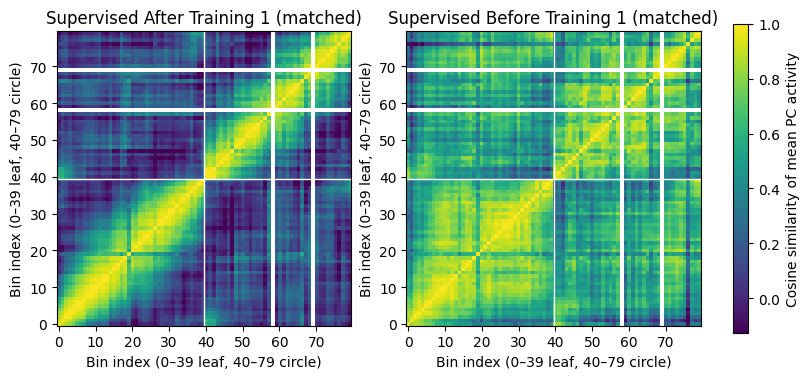

[Matched sampling] median neurons per bin — leaf: 15.5, circle: 7.0
[Matched sampling] #valid bins: 80 / 80


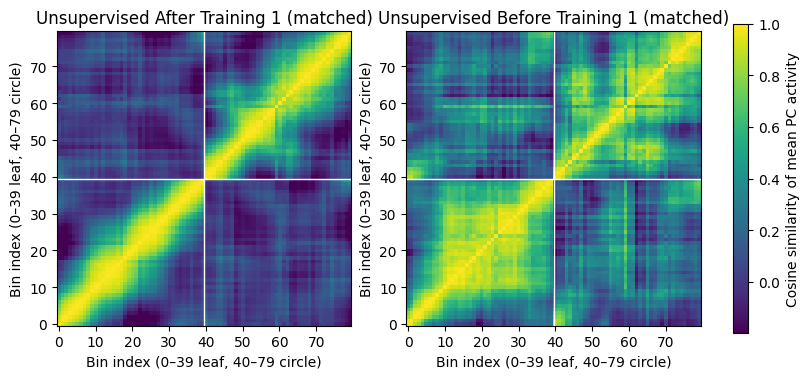

Original shape: (80, 80) -> Aligned shape: (78, 78)
Original shape: (80, 80) -> Aligned shape: (80, 80)
Ri distance for supervised after vs before training 1: 3205.8952470476697
Ri distance for unsupervised after vs before training 1: 5560.092622378473
RV coefficient for supervised after vs before training 1: 0.8801231833029446
RV coefficient for unsupervised after vs before training 1: 0.7892420328338106
Frobenius norm for supervised after vs before training 1: 30.801308600627657
Frobenius norm for unsupervised after vs before training 1: 22.7169448470549


/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 1.5736189206294928e-12
  return f(*arrays, *other_args, **kwargs)
/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 1.558113574644057e-11
  return f(*arrays, *other_args, **kwargs)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def corr_matrix_all_posbins_matched(U1, corr_sets1, U2, corr_sets2, n_PCs=200, random_state=None):
    rng = np.random.default_rng(random_state)

    spks1 = U1.T[:, :n_PCs]  # (n_neurons1, n_PCs)
    spks2 = U2.T[:, :n_PCs]  # (n_neurons2, n_PCs)

    # Collect bins: first 40 = leaf1, next 40 = circle1
    leaf1_bins_1 = [np.asarray(corr_sets1['leaf1'][i],  dtype=int) for i in sorted(corr_sets1['leaf1'].keys())[:40]]
    circle1_bins_1 = [np.asarray(corr_sets1['circle1'][i],dtype=int) for i in sorted(corr_sets1['circle1'].keys())[:40]]
    pos_bins_1 = leaf1_bins_1 + circle1_bins_1  # len 80

    leaf1_bins_2 = [np.asarray(corr_sets2['leaf1'][i],  dtype=int) for i in sorted(corr_sets2['leaf1'].keys())[:40]]
    circle1_bins_2 = [np.asarray(corr_sets2['circle1'][i],dtype=int) for i in sorted(corr_sets2['circle1'].keys())[:40]]
    pos_bins_2 = leaf1_bins_2 + circle1_bins_2  # len 80

    n_bins = 80
    mean1 = np.zeros((n_bins, n_PCs), dtype=float)
    mean2 = np.zeros((n_bins, n_PCs), dtype=float)
    valid = np.zeros(n_bins, dtype=bool)
    n_used = np.zeros(n_bins, dtype=int)

    for idx in range(n_bins):
        idxs1 = pos_bins_1[idx]
        idxs2 = pos_bins_2[idx]
        n1, n2 = len(idxs1), len(idxs2)
        m = min(n1, n2)
        if m > 0:
            # sample m without replacement in each condition independently
            sel1 = idxs1 if n1 == m else rng.choice(idxs1, size=m, replace=False)
            sel2 = idxs2 if n2 == m else rng.choice(idxs2, size=m, replace=False)
            mean1[idx] = spks1[sel1].mean(axis=0)
            mean2[idx] = spks2[sel2].mean(axis=0)
            valid[idx] = True
            n_used[idx] = m
        else:
            # leave mean rows as zeros; mark invalid
            valid[idx] = False
            n_used[idx] = 0

    valid_idx = np.nonzero(valid)[0]
    cm1_valid = cosine_similarity(mean1[valid])
    cm2_valid = cosine_similarity(mean2[valid])

    # expand back to 80x80 with NaNs
    cm1 = np.full((n_bins, n_bins), np.nan)
    cm2 = np.full((n_bins, n_bins), np.nan)
    for i, bi in enumerate(valid_idx):
        for j, bj in enumerate(valid_idx):
            cm1[bi, bj] = cm1_valid[i, j]
            cm2[bi, bj] = cm2_valid[i, j]

    return cm1, cm2, n_used, valid

import matplotlib.pyplot as plt
import numpy as np

def visualize_corr_matrix_matched(U1, U2, corr_sets1, corr_sets2, n_PCs,
                                  title1='', title2='', vmin=None, vmax=None,
                                  random_state=None):
    cm1, cm2, n_used, valid = corr_matrix_all_posbins_matched(
        U1, corr_sets1, U2, corr_sets2, n_PCs=n_PCs, random_state=random_state
    )

    # color scale from combined finite values
    if vmin is None or vmax is None:
        all_vals = np.concatenate([cm1[np.isfinite(cm1)], cm2[np.isfinite(cm2)]])
        if all_vals.size == 0:
            vmin, vmax = -1.0, 1.0
        else:
            vmin, vmax = np.percentile(all_vals, [1, 99])

    fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

    ticks = list(range(0, 80, 10))
    labels = [str(t) for t in ticks]

    for ax, cm, title in zip(axes, (cm1, cm2), (title1, title2)):
        im = ax.imshow(cm, cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.set_xticks(ticks); ax.set_xticklabels(labels)
        ax.set_yticks(ticks); ax.set_yticklabels(labels)
        # separate leaf (0–39) and circle (40–79)
        ax.axhline(39.5, color='w', linewidth=1)
        ax.axvline(39.5, color='w', linewidth=1)
        ax.invert_yaxis()
        ax.set_xlabel('Bin index (0–39 leaf, 40–79 circle)')
        ax.set_ylabel('Bin index (0–39 leaf, 40–79 circle)')

    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, orientation='vertical')
    cbar.set_label("Cosine similarity of mean PC activity")

    used_leaf = n_used[:40]
    used_circle = n_used[40:]
    print(f"[Matched sampling] median neurons per bin — leaf: {np.median(used_leaf)}, circle: {np.median(used_circle)}")
    print(f"[Matched sampling] #valid bins: {valid.sum()} / 80")

    plt.show()
    return cm1, cm2, n_used, valid

n_PCs = 15

# Supervised after vs before training 1 (matched per-bin counts)
sup_train1_cm1, sup_train1_cm2, sup_train1_nused, sup_train1_valid = visualize_corr_matrix_matched(
    sup_aft1_svd.T, sup_bef1_svd.T,
    sup_aft1_corr_sets, sup_bef1_corr_sets,
    n_PCs,
    title1='Supervised After Training 1 (matched)',
    title2='Supervised Before Training 1 (matched)',
    random_state=123
)


# Unsupervised after vs before training 1 (matched per-bin counts)
unsup_train1_cm1, unsup_train1_cm2, unsup_train1_nused, unsup_train1_valid = visualize_corr_matrix_matched(
    unsup2_aft1_svd.T, unsup2_bef1_svd.T,
    unsup2_aft1_corr_sets, unsup2_bef1_corr_sets,
    n_PCs,
    title1='Unsupervised After Training 1 (matched)',
    title2='Unsupervised Before Training 1 (matched)',
    random_state=123
)


def align_correlation_matrices(cm1, cm2):
    """
    Align two correlation matrices by removing NaN rows and columns to make them the same size.
    """
    valid_rows = ~np.isnan(cm2).all(axis=1)
    valid_cols = ~np.isnan(cm2).all(axis=0)
         
    # For symmetric matrices, use the intersection of valid rows and columns
    valid_indices = np.logical_and(valid_rows, valid_cols)
         
    # Remove the same rows and columns from both matrices
    cm1_aligned = cm1[np.ix_(valid_indices, valid_indices)]
    cm2_aligned = cm2[np.ix_(valid_indices, valid_indices)]
         
    print(f"Original shape: {cm1.shape} -> Aligned shape: {cm1_aligned.shape}")
         
    return cm1_aligned, cm2_aligned, valid_indices


sup_train1_cm1_aligned, sup_train1_cm2_aligned, _ = align_correlation_matrices(sup_train1_cm1, sup_train1_cm2)
unsup_train1_cm1_aligned, unsup_train1_cm2_aligned, _ = align_correlation_matrices(unsup_train1_cm1, unsup_train1_cm2)


from scipy.linalg import logm
Ri_dist_sup_train1 = np.linalg.norm(logm(np.linalg.inv(sup_train1_cm1_aligned) @ sup_train1_cm2_aligned), ord='fro')
Ri_dist_unsup_train1 = np.linalg.norm(logm(np.linalg.inv(unsup_train1_cm1_aligned) @ unsup_train1_cm2_aligned), ord='fro')
print(f'Ri distance for supervised after vs before training 1: {Ri_dist_sup_train1}')
print(f'Ri distance for unsupervised after vs before training 1: {Ri_dist_unsup_train1}')

def rv_coefficient(X, Y):
    K = X @ X.T
    L = Y @ Y.T
    return np.trace(K @ L) / np.sqrt(np.trace(K @ K) * np.trace(L @ L))

rv = rv_coefficient(sup_train1_cm1_aligned, sup_train1_cm2_aligned)
print(f'RV coefficient for supervised after vs before training 1: {rv}')

rv = rv_coefficient(unsup_train1_cm1_aligned, unsup_train1_cm2_aligned)
print(f'RV coefficient for unsupervised after vs before training 1: {rv}')

frob = np.linalg.norm(sup_train1_cm1_aligned - sup_train1_cm2_aligned, ord='fro')
print(f'Frobenius norm for supervised after vs before training 1: {frob}')

frob = np.linalg.norm(unsup_train1_cm1_aligned - unsup_train1_cm2_aligned, ord='fro')
print(f'Frobenius norm for unsupervised after vs before training 1: {frob}')


### Try: Subspace Angles

In [15]:
from scipy.linalg import subspace_angles
from scipy.spatial import procrustes

n_PCs = 200

def sim_per_recording(U, corr_sets, n_PCs=50):
    spks_SVDed = U.T[:, :n_PCs]

    
    leaf1_neurons = [corr_sets['leaf1'][pos] for pos in range(40)]
    circle1_neurons = [corr_sets['circle1'][pos] for pos in range(40)]
    leaf1_neurons = np.concatenate(leaf1_neurons).astype(int)
    circle1_neurons = np.concatenate(circle1_neurons).astype(int)
    spks_leaf1 = spks_SVDed[leaf1_neurons, :n_PCs]
    spks_circle1 = spks_SVDed[circle1_neurons, :n_PCs]
    print(f'Leaf1 neurons: {spks_leaf1.shape}, Circle1 neurons: {spks_circle1.shape}')
    
    '''
    spks_leaf1 = []
    spks_circle1 = []
    for i in range(40):
        leaf1_neurons = np.array(corr_sets['leaf1'][i], dtype=int)
        circle1_neurons = np.array(corr_sets['circle1'][i], dtype=int)
        if len(leaf1_neurons) == 0 or len(circle1_neurons) == 0:
            continue
        spks_leaf1.append(np.mean(spks_SVDed[leaf1_neurons, :n_PCs], axis=0))
        spks_circle1.append(np.mean(spks_SVDed[circle1_neurons, :n_PCs], axis=0))
    spks_leaf1 = np.array(spks_leaf1)
    spks_circle1 = np.array(spks_circle1)
    print(f'Leaf1 neurons: {spks_leaf1.shape}, Circle1 neurons: {spks_circle1.shape}')
    '''

    angles = subspace_angles(spks_leaf1.T, spks_circle1.T)           # array of angles in radians
    grassmann_dist = np.linalg.norm(angles)      # single scalar “distance”

    '''
    def rv_coefficient(X, Y):
        K = X @ X.T
        L = Y @ Y.T
        return np.trace(K @ L) / np.sqrt(np.trace(K @ K) * np.trace(L @ L))

    rv = rv_coefficient(spks_leaf1, spks_circle1)
    '''

    #mtx1, mtx2, disparity = procrustes(spks_leaf1, spks_circle1)

    '''
    Sx = np.cov(spks_leaf1, rowvar=False)  # shape (n_PCs, n_PCs)
    Sy = np.cov(spks_circle1, rowvar=False)

    # 3a) Frobenius norm
    cov_frob = np.linalg.norm(Sx - Sy, ord='fro')

    # 3b) Riemannian (affine‐invariant) distance
    from scipy.linalg import logm
    Ri_dist = np.linalg.norm(logm(np.linalg.inv(Sx) @ Sy), ord='fro')
    '''
    


    return grassmann_dist #grassmann_dist, rv, cov_frob, Ri_dist

seq = np.arange(0, 10000, 50)
seq[0] = 2  # start from 2 to avoid zero division in cosine similarity
dist1 = np.zeros(len(seq))
dist2 = np.zeros(len(seq))
dist3 = np.zeros(len(seq))
dist4 = np.zeros(len(seq))
dist5 = np.zeros(len(seq))
dist6 = np.zeros(len(seq))
for i, nPC in enumerate(seq):
    nPC = int(nPC)
    dist1[i] = sim_per_recording(sup_aft1_pca.T, sup_aft1_corr_sets, nPC)
    dist2[i] = sim_per_recording(sup_bef1_pca.T, sup_bef1_corr_sets, nPC)
    dist3[i] = sim_per_recording(unsup_aft1_pca.T, unsup_aft1_corr_sets, nPC)
    dist4[i] = sim_per_recording(unsup_bef1_pca.T, unsup_bef1_corr_sets, nPC)
    dist5[i] = sim_per_recording(sup_test1_pca.T, sup_test1_corr_sets, nPC)
    dist6[i] = sim_per_recording(unsup_test1_pca.T, unsup_test1_corr_sets, nPC)
plt.plot(seq, dist1, marker='o')
plt.plot(seq, dist2, marker='o')
plt.plot(seq, dist3, marker='o')
plt.plot(seq, dist4, marker='o')
plt.plot(seq, dist5, marker='o')
plt.plot(seq, dist6, marker='o')
plt.legend(['Supervised After Training 1', 'Supervised Before Training 1',
            'Unsupervised After Training 1', 'Unsupervised Before Training 1',
            'Supervised Test 1', 'Unsupervised Test 1'])
plt.xlabel('Number of PCs')
plt.ylabel('Grassmann Distance')

'''
sup_aft1_sim = sim_per_recording(sup_aft1_pca.T, sup_aft1_corr_sets, n_PCs)
print(f'Supervised after training 1 similarity: {sup_aft1_sim}')
sup_bef1_sim = sim_per_recording(sup_bef1_U, sup_bef1_corr_sets, n_PCs)
print(f'Supervised before training 1 similarity: {sup_bef1_sim}')
unsup_aft1_sim = sim_per_recording(unsup_aft1_U, unsup_aft1_corr_sets, n_PCs)
print(f'Unsupervised after training 1 similarity: {unsup_aft1_sim}')
unsup_bef1_sim = sim_per_recording(unsup_bef1_U, unsup_bef1_corr_sets, n_PCs)
print(f'Unsupervised before training 1 similarity: {unsup_bef1_sim}')
unsup_test1_sim = sim_per_recording(unsup_test1_U, unsup_test1_corr_sets, n_PCs)
print(f'Unsupervised test 1 similarity: {unsup_test1_sim}')
sup_test1_sim = sim_per_recording(sup_test1_U, sup_test1_corr_sets, n_PCs)
print(f'Supervised test 1 similarity: {sup_test1_sim}')
'''

NameError: name 'sup_aft1_pca' is not defined

Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (2,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles shape: (50,)
Angles sha

Text(0, 0.5, 'Grassmann Distance (Normalized)')

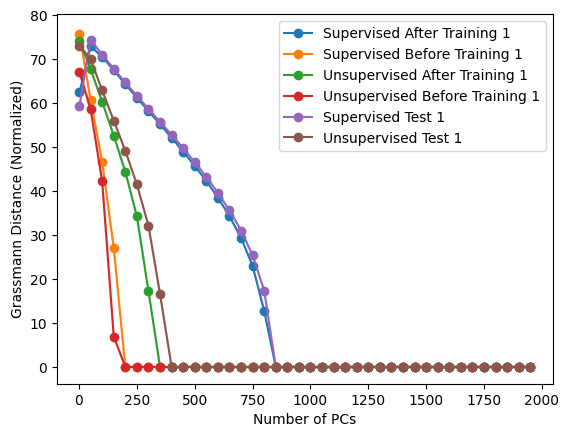

In [ ]:
def sample_to_same_size(dat1, dat2, random_state=None):
    """
    Sample datasets to the same size by randomly selecting
    """
    if random_state is not None:
        np.random.seed(random_state)

    if dat1.shape[0] > dat2.shape[0]:
        indices = np.random.choice(dat1.shape[0], dat2.shape[0], replace=False)
        return dat1[indices], dat2
    elif dat1.shape[0] < dat2.shape[0]:
        indices = np.random.choice(dat2.shape[0], dat1.shape[0], replace=False)
        return dat1, dat2[indices]
    else:
        return dat1, dat2

def sim_per_recording(U, corr_sets, n_PCs=50, random_state=None, normalize=False):
    spks_SVDed = U.T[:, :n_PCs]

    leaf1_neurons = []
    circle1_neurons = []
    for pos in range(40):
        if len(corr_sets['leaf1'][pos]) == 0 or len(corr_sets['circle1'][pos]) == 0:
            continue
        else:
            leaf1, circle1 = sample_to_same_size(
                np.array(corr_sets['leaf1'][pos], dtype=int),
                np.array(corr_sets['circle1'][pos], dtype=int),
                random_state=random_state
            )
            leaf1_neurons.append(leaf1)
            circle1_neurons.append(circle1)

    leaf1_neurons = np.concatenate(leaf1_neurons).astype(int)
    circle1_neurons = np.concatenate(circle1_neurons).astype(int)
    spks_leaf1 = spks_SVDed[leaf1_neurons, :n_PCs]
    spks_circle1 = spks_SVDed[circle1_neurons, :n_PCs]
    #print(f'Leaf1 neurons: {spks_leaf1.shape}, Circle1 neurons: {spks_circle1.shape}') 
    
    '''
    spks_leaf1 = []
    spks_circle1 = []
    for i in range(40):
        leaf1_neurons = np.array(corr_sets['leaf1'][i], dtype=int)
        circle1_neurons = np.array(corr_sets['circle1'][i], dtype=int)
        if len(leaf1_neurons) == 0 or len(circle1_neurons) == 0:
            continue
        spks_leaf1.append(np.mean(spks_SVDed[leaf1_neurons, :n_PCs], axis=0))
        spks_circle1.append(np.mean(spks_SVDed[circle1_neurons, :n_PCs], axis=0))
    spks_leaf1 = np.array(spks_leaf1)
    spks_circle1 = np.array(spks_circle1)
    print(f'Leaf1 neurons: {spks_leaf1.shape}, Circle1 neurons: {spks_circle1.shape}')
    '''

    angles = subspace_angles(spks_leaf1, spks_circle1)           # array of angles in radians
    print(f'Angles: {angles}')
    grassmann_dist = np.linalg.norm(angles)      # single scalar “distance”

    if normalize:
        max_dist = np.sqrt(len(angles))
        grassmann_dist /= max_dist
        grassmann_dist = np.rad2deg(grassmann_dist)  # convert to degrees
        
    
    '''
    def rv_coefficient(X, Y):
        K = X @ X.T
        L = Y @ Y.T
        return np.trace(K @ L) / np.sqrt(np.trace(K @ K) * np.trace(L @ L))

    rv = rv_coefficient(spks_leaf1, spks_circle1)
    '''

    #mtx1, mtx2, disparity = procrustes(spks_leaf1, spks_circle1)

    '''
    Sx = np.cov(spks_leaf1, rowvar=False)  # shape (n_PCs, n_PCs)
    Sy = np.cov(spks_circle1, rowvar=False)

    # 3a) Frobenius norm
    cov_frob = np.linalg.norm(Sx - Sy, ord='fro')

    # 3b) Riemannian (affine‐invariant) distance
    from scipy.linalg import logm
    Ri_dist = np.linalg.norm(logm(np.linalg.inv(Sx) @ Sy), ord='fro')
    '''
    


    return grassmann_dist #grassmann_dist, rv, cov_frob, Ri_dist


seq = np.arange(0, 2000, 50)
seq[0] = 2
n_runs = 5

# Store all runs for proper error calculation
dist_all = np.zeros((6, len(seq), n_runs))  # 6 conditions, seq length, n_runs

for i, nPC in enumerate(seq):
    for n in range(n_runs):
        nPC = int(nPC)
        dist_all[0, i, n] = sim_per_recording(sup_aft1_pca.T, sup_aft1_corr_sets, nPC, random_state=n, normalize=True)
        dist_all[1, i, n] = sim_per_recording(sup_bef1_pca.T, sup_bef1_corr_sets, nPC, random_state=n, normalize=True)
        dist_all[2, i, n] = sim_per_recording(unsup_aft1_pca.T, unsup_aft1_corr_sets, nPC, random_state=n, normalize=True)
        dist_all[3, i, n] = sim_per_recording(unsup_bef1_pca.T, unsup_bef1_corr_sets, nPC, random_state=n, normalize=True)
        dist_all[4, i, n] = sim_per_recording(sup_test1_pca.T, sup_test1_corr_sets, nPC, random_state=n, normalize=True)
        dist_all[5, i, n] = sim_per_recording(unsup_test1_pca.T, unsup_test1_corr_sets, nPC, random_state=n, normalize=True)

# Calculate means and standard errors
dist_means = np.mean(dist_all, axis=2)
dist_sem = np.std(dist_all, axis=2) / np.sqrt(n_runs)

labels = ['Supervised After Training 1', 'Supervised Before Training 1',
        'Unsupervised After Training 1', 'Unsupervised Before Training 1',
        'Supervised Test 1', 'Unsupervised Test 1']

# Plot with matching colors
for i in range(6):
    line = plt.plot(seq, dist_means[i], marker='o', label=labels[i], zorder=2)
    color = line[0].get_color()
    plt.fill_between(seq, dist_means[i] - dist_sem[i], dist_means[i] + dist_sem[i], 
                     color=color, alpha=0.2, zorder=1)

plt.legend()
plt.xlabel('Number of PCs')
plt.ylabel('Grassmann Distance (Normalized)')

    


(89577, 2)
Angles: (2,)
Angles: (2,)
Angles: (2,)
(89577, 2)
Angles: (2,)
Angles: (2,)
Angles: (2,)
(89577, 2)
Angles: (2,)
Angles: (2,)
Angles: (2,)
(89577, 2)
Angles: (2,)
Angles: (2,)
Angles: (2,)
(89577, 2)
Angles: (2,)
Angles: (2,)
Angles: (2,)
(89577, 100)
Angles: (100,)
Angles: (100,)
Angles: (100,)
(89577, 100)
Angles: (100,)
Angles: (100,)
Angles: (100,)
(89577, 100)
Angles: (100,)
Angles: (100,)
Angles: (100,)
(89577, 100)
Angles: (100,)
Angles: (100,)
Angles: (100,)
(89577, 100)
Angles: (100,)
Angles: (100,)
Angles: (100,)
(89577, 200)
Angles: (200,)
Angles: (200,)
Angles: (200,)
(89577, 200)
Angles: (200,)
Angles: (200,)
Angles: (200,)
(89577, 200)
Angles: (200,)
Angles: (200,)
Angles: (200,)
(89577, 200)
Angles: (200,)
Angles: (200,)
Angles: (200,)
(89577, 200)
Angles: (200,)
Angles: (200,)
Angles: (200,)
(89577, 300)
Angles: (300,)
Angles: (300,)
Angles: (300,)
(89577, 300)
Angles: (300,)
Angles: (300,)
Angles: (300,)
(89577, 300)
Angles: (300,)
Angles: (300,)
Angles: (30

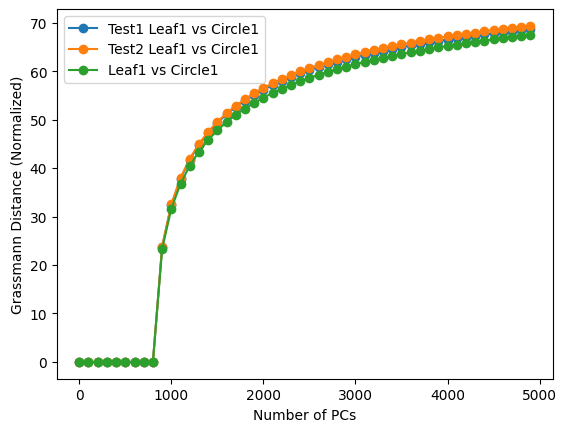

In [362]:
def sim_per_recording(U, corr_sets, n_PCs=50, random_state=None, normalize=False):
    spks_SVDed = U.T[:, :n_PCs]

    leaf1_neurons = []
    circle1_neurons = []
    for pos in range(40):
        if len(corr_sets['leaf1'][pos]) == 0 or len(corr_sets['circle1'][pos]) == 0:
            continue
        else:
            leaf1, circle1 = sample_to_same_size(
                np.array(corr_sets['leaf1'][pos], dtype=int),
                np.array(corr_sets['circle1'][pos], dtype=int),
                random_state=random_state
            )
            leaf1_neurons.append(leaf1)
            circle1_neurons.append(circle1)

    leaf1_neurons = np.concatenate(leaf1_neurons).astype(int)
    circle1_neurons = np.concatenate(circle1_neurons).astype(int)
    spks_leaf1 = spks_SVDed[leaf1_neurons, :n_PCs]
    spks_circle1 = spks_SVDed[circle1_neurons, :n_PCs]
    #print(f'Leaf1 neurons: {spks_leaf1.shape}, Circle1 neurons: {spks_circle1.shape}') 
    
    '''
    spks_leaf1 = []
    spks_circle1 = []
    for i in range(40):
        leaf1_neurons = np.array(corr_sets['leaf1'][i], dtype=int)
        circle1_neurons = np.array(corr_sets['circle1'][i], dtype=int)
        if len(leaf1_neurons) == 0 or len(circle1_neurons) == 0:
            continue
        spks_leaf1.append(np.mean(spks_SVDed[leaf1_neurons, :n_PCs], axis=0))
        spks_circle1.append(np.mean(spks_SVDed[circle1_neurons, :n_PCs], axis=0))
    spks_leaf1 = np.array(spks_leaf1)
    spks_circle1 = np.array(spks_circle1)
    print(f'Leaf1 neurons: {spks_leaf1.shape}, Circle1 neurons: {spks_circle1.shape}')
    '''

    angles = subspace_angles(spks_leaf1, spks_circle1)           # array of angles in radians
    print(f'Angles: {angles}')
    grassmann_dist = np.linalg.norm(angles)      # single scalar “distance”

    if normalize:
        max_dist = np.sqrt(len(angles))
        grassmann_dist /= max_dist
        grassmann_dist = np.rad2deg(grassmann_dist)  # convert to degrees
        
    
    '''
    def rv_coefficient(X, Y):
        K = X @ X.T
        L = Y @ Y.T
        return np.trace(K @ L) / np.sqrt(np.trace(K @ K) * np.trace(L @ L))

    rv = rv_coefficient(spks_leaf1, spks_circle1)
    '''

    #mtx1, mtx2, disparity = procrustes(spks_leaf1, spks_circle1)

    '''
    Sx = np.cov(spks_leaf1, rowvar=False)  # shape (n_PCs, n_PCs)
    Sy = np.cov(spks_circle1, rowvar=False)

    # 3a) Frobenius norm
    cov_frob = np.linalg.norm(Sx - Sy, ord='fro')

    # 3b) Riemannian (affine‐invariant) distance
    from scipy.linalg import logm
    Ri_dist = np.linalg.norm(logm(np.linalg.inv(Sx) @ Sy), ord='fro')
    '''
    


    return grassmann_dist #grassmann_dist, rv, cov_frob, Ri_dist

seq = np.arange(0, 5000, 100)
seq[0] = 2
n_runs = 5
dist = np.zeros((3, len(seq), n_runs))  # 6 conditions, seq length, n_runs
for i, nPC in enumerate(seq):
    for n in range(n_runs):
        test_spks_SVDed = sup_aft1_pca[:, :nPC]
        test1_spks_leaf1 = test_spks_SVDed[50000:50819, :nPC]
        test1_spks_circle1 = test_spks_SVDed[60000:60819, :nPC]
        test2_spks_leaf1 = test_spks_SVDed[10000:10819, :nPC]
        test2_spks_circle1 = test_spks_SVDed[70000:70819, :nPC]

        leaf1_neurons = []
        circle1_neurons = []
        for pos in range(40):
            if len(sup_aft1_corr_sets['leaf1'][pos]) == 0 or len(sup_aft1_corr_sets['circle1'][pos]) == 0:
                continue
            else:
                leaf1, circle1 = sample_to_same_size(
                    np.array(sup_aft1_corr_sets['leaf1'][pos], dtype=int),
                    np.array(sup_aft1_corr_sets['circle1'][pos], dtype=int),
                    random_state=n
                )
                leaf1_neurons.append(leaf1)
                circle1_neurons.append(circle1)

        leaf1_neurons = np.concatenate(leaf1_neurons).astype(int)
        circle1_neurons = np.concatenate(circle1_neurons).astype(int)
        spks_leaf1 = test_spks_SVDed[leaf1_neurons, :nPC]
        spks_circle1 = test_spks_SVDed[circle1_neurons, :nPC]


        print(test_spks_SVDed.shape)
        ang1 = subspace_angles(test1_spks_leaf1.T, test1_spks_circle1.T)
        print(f'Angles: {ang1.shape}')
        gma_dist1 = np.rad2deg(np.linalg.norm(ang1)/np.sqrt(len(ang1)))
        dist[0, i, n] = gma_dist1

        ang2 = subspace_angles(test2_spks_leaf1.T, test2_spks_circle1.T)
        print(f'Angles: {ang2.shape}')
        gma_dist2 = np.rad2deg(np.linalg.norm(ang2)/np.sqrt(len(ang2)))
        dist[1, i, n] = gma_dist2

        ang3 = subspace_angles(spks_leaf1.T, spks_circle1.T)
        print(f'Angles: {ang3.shape}')
        gma_dist3 = np.rad2deg(np.linalg.norm(ang3)/np.sqrt(len(ang3)))
        dist[2, i, n] = gma_dist3

plt.plot(seq, np.mean(dist[0], axis=1), marker='o', label='Test1 Leaf1 vs Circle1')
plt.plot(seq, np.mean(dist[1], axis=1), marker='o', label='Test2 Leaf1 vs Circle1')
plt.plot(seq, np.mean(dist[2], axis=1), marker='o', label='Leaf1 vs Circle1')
plt.fill_between(seq, np.mean(dist[0], axis=1) - np.std(dist[0], axis=1)/np.sqrt(n_runs),
                    np.mean(dist[0], axis=1) + np.std(dist[0], axis=1)/np.sqrt(n_runs), 
                    alpha=0.2)  
plt.fill_between(seq, np.mean(dist[1], axis=1) - np.std(dist[1], axis=1)/np.sqrt(n_runs),
                    np.mean(dist[1], axis=1) + np.std(dist[1], axis=1)/np.sqrt(n_runs), 
                    alpha=0.2)
plt.fill_between(seq, np.mean(dist[2], axis=1) - np.std(dist[2], axis=1)/np.sqrt(n_runs),
                    np.mean(dist[2], axis=1) + np.std(dist[2], axis=1)/np.sqrt(n_runs), 
                    alpha=0.2)
plt.xlabel('Number of PCs')
plt.ylabel('Grassmann Distance (Normalized)')
plt.legend()



y2: [30.13837264 33.22681249 36.07596303 38.70436419 41.1291194  43.36600695
 45.42958264 47.33327451 49.0894702  50.70959756 52.20419905 53.58300028
 54.85497333 56.02839516 57.11090142 58.10953615 59.03079765 59.8806807
 60.66471565 61.38800433 62.05525332 62.67080451 63.2386634  63.76252514
 64.24579858 64.69162847 65.1029159  65.48233718 65.83236127 66.15526583
 66.45315207 66.72795837 66.98147295 67.21534547 67.43109778 67.63013381
 67.81374872 67.98313732 68.13940187 68.28355919 68.41654734]


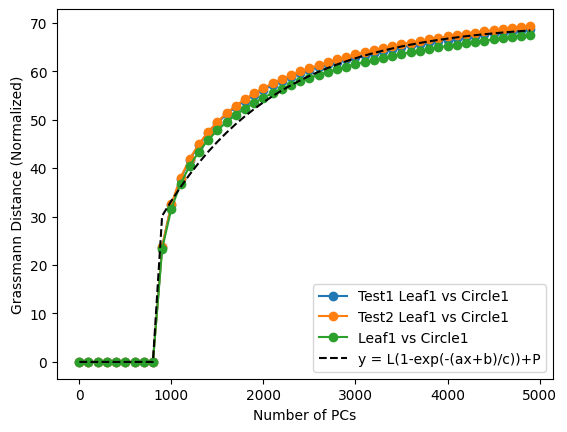

In [467]:
y1 = np.zeros(9)
x2 = seq[9:]
y2 = 200*(1-np.exp(-(x2+1100)/1240)) -130
print(f'y2: {y2}')
y = np.concatenate((y1, y2))


plt.plot(seq, np.mean(dist[0], axis=1), marker='o', label='Test1 Leaf1 vs Circle1')
plt.plot(seq, np.mean(dist[1], axis=1), marker='o', label='Test2 Leaf1 vs Circle1')
plt.plot(seq, np.mean(dist[2], axis=1), marker='o', label='Leaf1 vs Circle1')
plt.plot(seq, y, label='y = L(1-exp(-(ax+b)/c))+P', linestyle='--', color='k')
plt.fill_between(seq, np.mean(dist[0], axis=1) - np.std(dist[0], axis=1)/np.sqrt(n_runs),
                    np.mean(dist[0], axis=1) + np.std(dist[0], axis=1)/np.sqrt(n_runs), 
                    alpha=0.2)  
plt.fill_between(seq, np.mean(dist[1], axis=1) - np.std(dist[1], axis=1)/np.sqrt(n_runs),
                    np.mean(dist[1], axis=1) + np.std(dist[1], axis=1)/np.sqrt(n_runs), 
                    alpha=0.2)
plt.fill_between(seq, np.mean(dist[2], axis=1) - np.std(dist[2], axis=1)/np.sqrt(n_runs),
                    np.mean(dist[2], axis=1) + np.std(dist[2], axis=1)/np.sqrt(n_runs), 
                    alpha=0.2)
plt.xlabel('Number of PCs')
plt.ylabel('Grassmann Distance (Normalized)')
plt.legend()


### Mature Version: Subspace Angles

In [ ]:
from scipy.linalg import svd

def _center_and_scale(X, col_scale=None, center=True):
    if col_scale is not None:
        X = X / col_scale  # broadcast over columns
    if center:
        X = X - X.mean(axis=0, keepdims=True)
    return X

def _top_r_feature_basis(X, r):
    """
    X: (n_neurons, dPC). Returns Q in R^{dPC x r}, the top-r right singular vectors.
    """
    U, S, Vt = svd(X, full_matrices=False)
    r_eff = min(r, Vt.shape[0])  # cannot exceed rank(X) or dPC
    return Vt.T[:, :r_eff]       # (dPC, r_eff)

def _angles_and_chordal(QA, QB):
    """
    QA,QB: (dPC, r) with same r (or r_eff after trimming).
    Returns: theta (r,), d_chord_norm in [0,1]
    """
    C = QA.T @ QB                           # (r, r)
    cosvals = np.linalg.svd(C, compute_uv=False)
    theta = np.arccos(np.clip(cosvals, -1.0, 1.0))
    d_chord_norm = np.sqrt(1.0 - (cosvals**2).mean())
    return theta, d_chord_norm

def compare_groups_over_r(A, B, r_seq, col_scale=None, center=True, random_state=None):
    """
    A,B: (n_neurons, dPC). r_seq: iterable of ints (candidate r's).
    Returns (r_used, dists, theta1):
      - r_used: r's that were feasible for this pair (<= min(rank(A),rank(B))).
      - dists: normalized chordal distance for each r_used.
      - theta1: smallest principal angle for each r_used.
    """
    rng = np.random.default_rng(random_state)
    # (Optional) whitening/centering
    A = _center_and_scale(A, col_scale=col_scale, center=center)
    B = _center_and_scale(B, col_scale=col_scale, center=center)

    #r_used = [r for r in r_seq if r <= r_max_pair]
    r_used = [r for r in r_seq]
    dists = np.empty(len(r_used), float)
    theta1 = np.empty(len(r_used), float)
    for i, r in enumerate(r_used):
        Ai = A[:r, :]
        Bi = B[:r, :]
        # SVDs once
        UA, SA, VAt = svd(Ai, full_matrices=False)
        UB, SB, VBt = svd(Bi, full_matrices=False)
        VA, VB = VAt.T, VBt.T # (dPC, rA) and (dPC, rB)
        #r_max_pair = min(VA.shape[1], VB.shape[1])
        #r_max_pair = min(UA.shape[1], UB.shape[1])  # rank(A) and rank(B)
        n_num = r - 1 if r <= VA.shape[1] else VA.shape[1] - 1
        idx = rng.choice(VA.shape[1], n_num, replace=False) if r <= VA.shape[1] else None # random subset of PCs
        #QA = VA[:, idx]  if r <= VA.shape[1] else VA
        #QB = VB[:, idx]  if r <= VB.shape[1] else VB
        QA = VA[:, :n_num] 
        QB = VB[:, :n_num] 
        #QA = UA[:, :r]
        #QB = UB[:, :r]
        th, d = _angles_and_chordal(QA, QB)
        theta1[i] = th.min()
        dists[i] = d
    return np.asarray(r_used, int), dists, theta1


def sample_to_same_size(dat1, dat2, random_state=None):
    if random_state is not None:
        rng = np.random.default_rng(random_state)
    else:
        rng = np.random.default_rng()
    if dat1.shape[0] > dat2.shape[0]:
        idx = rng.choice(dat1.shape[0], dat2.shape[0], replace=False)
        return dat1[idx], dat2
    elif dat1.shape[0] < dat2.shape[0]:
        idx = rng.choice(dat2.shape[0], dat1.shape[0], replace=False)
        return dat1, dat2[idx]
    else:
        return dat1, dat2

def build_group_matrices(U_scores_T, corr_sets, d_ambient, random_state=None, balance=True):
    """
    U_scores_T: what you were passing before (e.g., sup_aft1_pca.T).
    Returns A,B as (n_neurons, d_ambient).
    """
    spks = U_scores_T.T[:, :d_ambient]  # (neurons, d_ambient)

    leaf_idx, circ_idx = [], []
    for pos in range(40):
        L = np.asarray(corr_sets['leaf1'][pos], dtype=int)
        C = np.asarray(corr_sets['circle1'][pos], dtype=int)
        if len(L) == 0 or len(C) == 0:
            continue
        if balance:
            L, C = sample_to_same_size(L, C, random_state=random_state)
        leaf_idx.append(L); circ_idx.append(C)

    if len(leaf_idx) == 0:
        raise ValueError("No overlapping positions with neurons in both groups.")
    leaf_idx = np.concatenate(leaf_idx).astype(int)
    circle_idx = np.concatenate(circ_idx).astype(int)

    A = spks[leaf_idx, :]  # (nA, d_ambient)
    B = spks[circle_idx, :]  # (nB, d_ambient)
    return A, B

def sim_per_recording_over_r(U_scores_T, corr_sets, d_ambient, r_seq, col_scale_full=None, random_state=None, balance=True, center=True):
    """
    col_scale_full: optional vector of length >= d_ambient for whitening
                    (e.g., np.sqrt(global_pca.explained_variance_))
    Returns: (r_used, dists, theta1)
    """
    A, B = build_group_matrices(U_scores_T, corr_sets, d_ambient, random_state, balance)
    col_scale = None if col_scale_full is None else np.asarray(col_scale_full)[:d_ambient]
    return B.shape[0], compare_groups_over_r(A, B, r_seq, col_scale=col_scale, center=center)

# random pairs out of a big (neurons x PCs) matrix
def random_pairs_over_r(U_scores_T, d_ambient, r_master, group_size=365, n_runs=50, col_scale_full=None, center=True, disjoint=True, random_state=None):
    """
    Sample two groups of `group_size` neurons from the big matrix and compare
    their top-r feature subspaces for all r in r_master. Repeats n_runs times.

    Returns:
      dist_mat: (len(r_master), n_runs) normalized chordal distances (NaN where r infeasible)
      theta1_mat: (len(r_master), n_runs) smallest angle (radians) (NaN where infeasible)
    """
    rng = np.random.default_rng(random_state)
    spks = U_scores_T.T[:, :d_ambient]  # (n_neurons, d_ambient)
    n_neurons = spks.shape[0]
    dist_mat   = np.full((len(r_master), n_runs), np.nan)
    theta1_mat = np.full_like(dist_mat, np.nan, dtype=float)
    col_scale = None if col_scale_full is None else np.asarray(col_scale_full)[:d_ambient]

    for run in range(n_runs):
        if disjoint:
            idx = rng.choice(n_neurons, 5*group_size, replace=False)
            idxA, idxB = idx[:group_size], idx[4*group_size:5*group_size]
        else:
            idxA = rng.choice(n_neurons, group_size, replace=False)
            idxB = rng.choice(n_neurons, group_size, replace=False)

        A = spks[idxA, :]
        B = spks[idxB, :]
        r_used, dists, theta1 = compare_groups_over_r(A, B, r_master, col_scale=col_scale, center=center)
        pos = np.searchsorted(r_master, r_used)
        dist_mat[pos, run] = dists
        theta1_mat[pos, run] = theta1

    return dist_mat, theta1_mat



In [ ]:
r_master = np.arange(0, 60, 1)
r_master = r_master[2:]
#r_master[0] = 2  # start at 2
d_ambient = 1000
n_runs = 5

conds = [
    ("Supervised After Training 1", sup_aft1_svd.T, sup_aft1_corr_sets),
    ("Supervised Before Training 1", sup_bef1_svd.T, sup_bef1_corr_sets),
    ("Unsupervised After Training 1", unsup_aft1_svd.T, unsup_aft1_corr_sets),
    ("Unsupervised Before Training 1", unsup_bef1_svd.T, unsup_bef1_corr_sets),
    ("Supervised Test 1", sup_test1_svd.T, sup_test1_corr_sets),
    ("Unsupervised Test 1", unsup_test1_svd.T, unsup_test1_corr_sets),
]

# OPTIONAL whitening by global PCA variances
col_scale_full = None  # or: np.sqrt(global_pca.explained_variance_)

dist_all  = np.full((len(conds), len(r_master), n_runs), np.nan)
theta_all = np.full_like(dist_all, np.nan, dtype=float)
neuron_num_all = np.zeros(len(conds), int)  # number of neurons in each condition

for ci, (label, U_T, cs) in enumerate(conds):
    print(f"Processing condition: {label}")
    for run in range(n_runs):
        neuron_num, (r_used, dists, theta1) = sim_per_recording_over_r(
            U_T, cs, d_ambient, r_master,
            col_scale_full=col_scale_full,
            random_state=run, balance=True, center=False
        )
        idx = np.searchsorted(r_master, r_used)
        dist_all[ci, idx, run]  = dists
        theta_all[ci, idx, run] = theta1
        neuron_num_all[ci] = neuron_num

dist_mean = np.nanmean(dist_all, axis=2)
dist_sem  = np.nanstd(dist_all,  axis=2) / np.sqrt(n_runs)
neuron_num_max = np.nanmax(neuron_num_all)
neuron_num_min = np.nanmin(neuron_num_all)

rand_group_size1 = neuron_num_max
rand_group_size2 = neuron_num_min
rand_runs = 5
rand_dist_mat1, rand_theta1_mat1 = random_pairs_over_r(
    sup_aft1_svd.T, d_ambient, r_master,
    group_size=rand_group_size1, n_runs=rand_runs,
    col_scale_full=col_scale_full, center=False, disjoint=True, random_state=123
)
rand_mean1 = np.nanmean(rand_dist_mat1, axis=1)
rand_sem1  = np.nanstd(rand_dist_mat1,  axis=1) / np.sqrt(rand_runs)
rand_dist_mat2, rand_theta1_mat2 = random_pairs_over_r(
    unsup_bef1_svd.T, d_ambient, r_master,
    group_size=rand_group_size2, n_runs=rand_runs,
    col_scale_full=col_scale_full, center=False, disjoint=True, random_state=456
)
rand_mean2 = np.nanmean(rand_dist_mat2, axis=1)
rand_sem2  = np.nanstd(rand_dist_mat2,  axis=1) / np.sqrt(rand_runs)


plt.figure(figsize=(8, 5))

for ci, (label, *_ ) in enumerate(conds):
    y = dist_mean[ci]
    e = dist_sem[ci]
    valid = np.isfinite(y) & np.isfinite(e)
    if not np.any(valid):
        continue
    line = plt.plot(r_master[valid], y[valid], label=label, linestyle='--', zorder=2)
    color = line[0].get_color()
    plt.fill_between(r_master[valid],
                     (y - e)[valid],
                     (y + e)[valid],
                     alpha=0.3, zorder=1, label=None, color=color)

# random baseline curve
valid_r = np.isfinite(rand_mean1) & np.isfinite(rand_sem1)
line = plt.plot(r_master[valid_r], rand_mean1[valid_r], linestyle='--', marker=None,
                label=f"Random Neural Sample", zorder=2, color='k')
rand_color = line[0].get_color()
plt.fill_between(r_master[valid_r],
                 (rand_mean1 - rand_sem1)[valid_r],
                 (rand_mean1 + rand_sem1)[valid_r],
                 alpha=0.4, zorder=1, color=rand_color, label=None)

valid_r2 = np.isfinite(rand_mean2) & np.isfinite(rand_sem2)
line2 = plt.plot(r_master[valid_r2], rand_mean2[valid_r2], linestyle='--', marker=None,
                 label=None, zorder=2, color='k')
rand_color2 = line2[0].get_color()
plt.fill_between(r_master[valid_r2],
                 (rand_mean2 - rand_sem2)[valid_r2],
                 (rand_mean2 + rand_sem2)[valid_r2],
                 alpha=0.4, zorder=1, color=rand_color2, label=None)

plt.xlabel("r (dimension of principal subspace)")
plt.ylabel("Normalized chordal distance (0–1)")
plt.xticks(np.arange(0, 61, 5))
plt.legend()
plt.tight_layout()
plt.show()


Processing condition: Supervised After Training 1
(1000, 2) (1000, 2)
(1000, 3) (1000, 3)
(1000, 4) (1000, 4)
(1000, 5) (1000, 5)
(1000, 6) (1000, 6)
(1000, 7) (1000, 7)
(1000, 8) (1000, 8)
(1000, 9) (1000, 9)
(1000, 10) (1000, 10)
(1000, 11) (1000, 11)
(1000, 12) (1000, 12)
(1000, 13) (1000, 13)
(1000, 14) (1000, 14)
(1000, 15) (1000, 15)
(1000, 16) (1000, 16)
(1000, 17) (1000, 17)
(1000, 18) (1000, 18)
(1000, 19) (1000, 19)
(1000, 20) (1000, 20)
(1000, 21) (1000, 21)
(1000, 22) (1000, 22)
(1000, 23) (1000, 23)
(1000, 24) (1000, 24)
(1000, 25) (1000, 25)
(1000, 26) (1000, 26)
(1000, 27) (1000, 27)
(1000, 28) (1000, 28)
(1000, 29) (1000, 29)
(1000, 30) (1000, 30)
(1000, 31) (1000, 31)
(1000, 32) (1000, 32)
(1000, 33) (1000, 33)
(1000, 34) (1000, 34)
(1000, 35) (1000, 35)
(1000, 36) (1000, 36)
(1000, 37) (1000, 37)
(1000, 38) (1000, 38)
(1000, 39) (1000, 39)
(1000, 40) (1000, 40)
(1000, 41) (1000, 41)
(1000, 42) (1000, 42)
(1000, 43) (1000, 43)
(1000, 44) (1000, 44)
(1000, 45) (1000, 45

KeyboardInterrupt: 

In [ ]:
r_master = np.arange(0, 1500, 20)
#r_master = r_master[1:]  # skip 0
r_master[0] = 2  # start at 2
d_ambient = 1500
n_runs = 10

conds = [
    ("Supervised After Training 1", sup_aft1_svd.T, sup_aft1_corr_sets),
    ("Supervised Before Training 1", sup_bef1_svd.T, sup_bef1_corr_sets),
    ("Unsupervised After Training 1", unsup_aft1_svd.T, unsup_aft1_corr_sets),
    ("Unsupervised Before Training 1", unsup_bef1_svd.T, unsup_bef1_corr_sets),
    ("Supervised Test 1", sup_test1_svd.T, sup_test1_corr_sets),
    ("Unsupervised Test 1", unsup_test1_svd.T, unsup_test1_corr_sets),
]

# OPTIONAL whitening by global PCA variances
col_scale_full = None  # or: np.sqrt(global_pca.explained_variance_)

dist_all = np.full((len(conds), len(r_master), n_runs), np.nan)
theta_all = np.full_like(dist_all, np.nan, dtype=float)
neuron_num_all = np.zeros(len(conds), int)  # number of neurons in each condition

for ci, (label, U_T, cs) in enumerate(conds):
    print(f"Processing condition: {label}")
    for run in range(n_runs):
        neuron_num, (r_used, dists, theta1) = sim_per_recording_over_r(
            U_T, cs, d_ambient, r_master,
            col_scale_full=col_scale_full,
            random_state=run, balance=True, center=False
        )
        idx = np.searchsorted(r_master, r_used)
        dist_all[ci, idx, run] = dists
        theta_all[ci, idx, run] = theta1
        neuron_num_all[ci] = neuron_num

dist_mean = np.nanmean(dist_all, axis=2)
dist_sem = np.nanstd(dist_all,  axis=2) / np.sqrt(n_runs)
neuron_num_max = np.nanmax(neuron_num_all)
neuron_num_min = np.nanmin(neuron_num_all)

rand_group_size1 = neuron_num_max
rand_group_size2 = neuron_num_min
rand_runs = 50
rand_dist_mat1, rand_theta1_mat1 = random_pairs_over_r(
    sup_aft1_svd.T, d_ambient, r_master,
    group_size=rand_group_size1, n_runs=rand_runs,
    col_scale_full=col_scale_full, center=False, disjoint=True, random_state=123
)
rand_mean1 = np.nanmean(rand_dist_mat1, axis=1)
rand_sem1 = np.nanstd(rand_dist_mat1,  axis=1) / np.sqrt(rand_runs)
rand_dist_mat2, rand_theta1_mat2 = random_pairs_over_r(
    unsup_bef1_svd.T, d_ambient, r_master,
    group_size=rand_group_size2, n_runs=rand_runs,
    col_scale_full=col_scale_full, center=False, disjoint=True, random_state=456
)
rand_mean2 = np.nanmean(rand_dist_mat2, axis=1)
rand_sem2 = np.nanstd(rand_dist_mat2,  axis=1) / np.sqrt(rand_runs)


plt.figure(figsize=(8, 5))

for ci, (label, *_ ) in enumerate(conds):
    y = dist_mean[ci]
    e = dist_sem[ci]
    valid = np.isfinite(y) & np.isfinite(e)
    if not np.any(valid):
        continue
    line = plt.plot(r_master[valid], y[valid], label=label, linestyle='--', zorder=2)
    color = line[0].get_color()
    plt.fill_between(r_master[valid],
                     (y - e)[valid],
                     (y + e)[valid],
                     alpha=0.3, zorder=1, label=None, color=color)

# random baseline curve
valid_r = np.isfinite(rand_mean1) & np.isfinite(rand_sem1)
line = plt.plot(r_master[valid_r], rand_mean1[valid_r], linestyle='--', marker=None,
                label=f"Random Neural Sample", zorder=2, color='k')
rand_color = line[0].get_color()
plt.fill_between(r_master[valid_r],
                 (rand_mean1 - rand_sem1)[valid_r],
                 (rand_mean1 + rand_sem1)[valid_r],
                 alpha=0.4, zorder=1, color=rand_color, label=None)

valid_r2 = np.isfinite(rand_mean2) & np.isfinite(rand_sem2)
line2 = plt.plot(r_master[valid_r2], rand_mean2[valid_r2], linestyle='--', marker=None,
                 label=None, zorder=2, color='k')
rand_color2 = line2[0].get_color()
plt.fill_between(r_master[valid_r2],
                 (rand_mean2 - rand_sem2)[valid_r2],
                 (rand_mean2 + rand_sem2)[valid_r2],
                 alpha=0.4, zorder=1, color=rand_color2, label=None)

plt.xlabel("r (dimension of principal subspace)")
plt.ylabel("Normalized chordal distance (0–1)")
plt.legend()
plt.tight_layout()
plt.show()

Processing condition: Supervised After Training 1
Processing condition: Supervised Before Training 1
Processing condition: Unsupervised After Training 1
Processing condition: Unsupervised Before Training 1
Processing condition: Supervised Test 1
Processing condition: Unsupervised Test 1


In [ ]:
def subspace_angles_by_dims(max_dims, unit_dims, d_ambient, n_runs,
                            aft1_pca, bef1_pca, test1_pca,
                            aft1_corr_sets, bef1_corr_sets, test1_corr_sets,
                            animal_type='sup'):

    r_master = np.arange(0, max_dims, unit_dims)
    if unit_dims == 1:
        r_master = r_master[2:]
    else:
        r_master[0] = 2  # start at 2

    conds = [
        (f'{animal_type} After Training 1', aft1_pca.T, aft1_corr_sets),
        (f'{animal_type} Before Training 1', bef1_pca.T, bef1_corr_sets),
        (f'{animal_type} Test 1', test1_pca.T, test1_corr_sets),
    ]

    # OPTIONAL whitening by global PCA variances
    col_scale_full = None  # or: np.sqrt(global_pca.explained_variance_)

    dist_all = np.full((len(conds), len(r_master), n_runs), np.nan)
    theta_all = np.full_like(dist_all, np.nan, dtype=float)
    neuron_num_all = np.zeros(len(conds), int)  # number of neurons in each condition

    for ci, (label, U_T, cs) in enumerate(conds):
        print(f"Processing condition: {label}")
        for run in range(n_runs):
            neuron_num, (r_used, dists, theta1) = sim_per_recording_over_r(
                U_T, cs, d_ambient, r_master,
                col_scale_full=col_scale_full,
                random_state=run, balance=True, center=True
            )
            idx = np.searchsorted(r_master, r_used)
            dist_all[ci, idx, run]  = dists
            theta_all[ci, idx, run] = theta1
            neuron_num_all[ci] = neuron_num

    dist_mean = np.nanmean(dist_all, axis=2)
    dist_sem = np.nanstd(dist_all,  axis=2) / np.sqrt(n_runs)
    neuron_num_max = np.nanmax(neuron_num_all)
    neuron_num_min = np.nanmin(neuron_num_all)

    rand_group_size1 = neuron_num_max
    rand_group_size2 = neuron_num_min
    rand_runs = 10
    rand_dist_mat1, rand_theta1_mat1 = random_pairs_over_r(
        aft1_pca.T, d_ambient, r_master,
        group_size=rand_group_size1, n_runs=rand_runs,
        col_scale_full=col_scale_full, center=True, disjoint=True, random_state=123
    )
    rand_mean1 = np.nanmean(rand_dist_mat1, axis=1)
    rand_sem1 = np.nanstd(rand_dist_mat1,  axis=1) / np.sqrt(rand_runs)
    rand_dist_mat2, rand_theta1_mat2 = random_pairs_over_r(
        bef1_pca.T, d_ambient, r_master,
        group_size=rand_group_size2, n_runs=rand_runs,
        col_scale_full=col_scale_full, center=True, disjoint=True, random_state=456
    )
    rand_mean2 = np.nanmean(rand_dist_mat2, axis=1)
    rand_sem2 = np.nanstd(rand_dist_mat2,  axis=1) / np.sqrt(rand_runs)

    plt.figure(figsize=(10, 5))

    for ci, (label, *_ ) in enumerate(conds):
        y = dist_mean[ci]
        e = dist_sem[ci]
        valid = np.isfinite(y) & np.isfinite(e)
        if not np.any(valid):
            continue
        line = plt.plot(r_master[valid], y[valid], label=label, linestyle='--', zorder=2)
        color = line[0].get_color()
        plt.fill_between(r_master[valid],
                        (y - e)[valid],
                        (y + e)[valid],
                        alpha=0.3, zorder=1, label=None, color=color)

    # random baseline curve
    valid_r = np.isfinite(rand_mean1) & np.isfinite(rand_sem1)
    line = plt.plot(r_master[valid_r], rand_mean1[valid_r], linestyle='--', marker=None,
                    label=f"Random Neural Sample", zorder=2, color='k')
    rand_color = line[0].get_color()
    plt.fill_between(r_master[valid_r],
                    (rand_mean1 - rand_sem1)[valid_r],
                    (rand_mean1 + rand_sem1)[valid_r],
                    alpha=0.4, zorder=1, color=rand_color, label=None)

    valid_r2 = np.isfinite(rand_mean2) & np.isfinite(rand_sem2)
    line2 = plt.plot(r_master[valid_r2], rand_mean2[valid_r2], linestyle='--', marker=None,
                    label=None, zorder=2, color='k')
    rand_color2 = line2[0].get_color()
    plt.fill_between(r_master[valid_r2],
                    (rand_mean2 - rand_sem2)[valid_r2],
                    (rand_mean2 + rand_sem2)[valid_r2],
                    alpha=0.4, zorder=1, color=rand_color2, label=None)

    plt.xlabel("r (dimension of principal subspace)")
    plt.ylabel("Normalized chordal distance (0–1)")
    plt.xticks(np.linspace(0, max_dims, 21))
    plt.legend()
    plt.tight_layout()
    plt.show()

### Other Try

In [ ]:
# normalized neural distance
def normalized_neural_distance():


In [17]:
#from sklearn.decomposition import PCA

#pca = PCA(n_components=10000)
#sup_aft1_pca = pca.fit_transform(sup_aft1_spks)

svd = TruncatedSVD(n_components=10000, random_state=42)

In [ ]:
print(1)
sup_aft1_svd = svd.fit_transform(sup_aft1_spks)
print(2)
sup_bef1_svd = svd.fit_transform(sup_bef1_spks)
print(3)
unsup_aft1_svd = svd.fit_transform(unsup_aft1_spks)
print(4)
unsup_bef1_svd = svd.fit_transform(unsup_bef1_spks)
print(5)
unsup_test1_svd = svd.fit_transform(unsup_test1_spks)
print(6)
sup_test1_svd = svd.fit_transform(sup_test1_spks)

1
2
3
4
5
6


FileNotFoundError: [Errno 2] No such file or directory: '/home/sunr/projects/MCLabRotation/data_Zhong_et_al_2025/svd/sup_svd.npz'

In [18]:
np.savez(os.path.join(root, 'svd', 'sup_svd.npz'),
         aft1=sup_aft1_svd,
         bef1=sup_bef1_svd,
         test1=sup_test1_svd
)
np.savez(os.path.join(root, 'svd', 'unsup_svd.npz'),
         aft1=unsup_aft1_svd,
         bef1=unsup_bef1_svd,
         test1=unsup_test1_svd)

NameError: name 'sup_aft1_svd' is not defined

In [19]:
npzfile = np.load(os.path.join(root, 'svd', 'sup_svd.npz'))
sup_aft1_svd = npzfile['aft1']
sup_bef1_svd = npzfile['bef1']
sup_test1_svd = npzfile['test1']
npzfile = np.load(os.path.join(root, 'svd', 'unsup_svd.npz'))
unsup_aft1_svd = npzfile['aft1']
unsup_bef1_svd = npzfile['bef1']
unsup_test1_svd = npzfile['test1']

## Multi Animals Data

In [16]:
def multi_animals_pipeline(aft1, bef1, test1, root, animal_type='sup', existing_svd_file=None,
                           plot_tuning_curves=True, plot_tuning_neuron_distr=True, plot_tuning_neuron_pos=True,
                           plot_subspace_angles_zoomin=True, plot_subspace_angles_zoomout=True):
    """
    Process multiple animals' data through the pipeline.
    """
    # Beh
    aft1_beh = np.load(os.path.join(root, 'beh', f'Beh_{animal_type}_train1_after_learning.npy'), allow_pickle=1).item()[aft1]
    bef1_beh = np.load(os.path.join(root, 'beh', f'Beh_{animal_type}_train1_before_learning.npy'), allow_pickle=1).item()[bef1]
    test1_beh = np.load(os.path.join(root, 'beh', f'Beh_{animal_type}_test1.npy'), allow_pickle=1).item()[test1]

    # Spks
    aft1_spks, aft1_xpos, aft1_ypos, _, _ = prepare_data(aft1)
    bef1_spks, bef1_xpos, bef1_ypos, _, _ = prepare_data(bef1)
    test1_spks, test1_xpos, test1_ypos, _, _ = prepare_data(test1)
    print(f'Animal {aft1}: {animal_type} after training 1: {aft1_spks.shape}')
    print(f'Animal {bef1}: {animal_type} before training 1: {bef1_spks.shape}')
    print(f'Animal {test1}: {animal_type} test 1: {test1_spks.shape}')

    # Tuning Neurons
    aft1_corridor_tuning = tuning_curves_VR(aft1_spks, aft1_beh['ft_Pos'] / 60, aft1_beh['StartFr'], aft1_beh['EndFr'], aft1_beh)
    bef1_corridor_tuning = tuning_curves_VR(bef1_spks, bef1_beh['ft_Pos'] / 60, bef1_beh['StartFr'], bef1_beh['EndFr'], bef1_beh)
    test1_corridor_tuning = tuning_curves_VR(test1_spks, test1_beh['ft_Pos'] / 60, test1_beh['StartFr'], test1_beh['EndFr'], test1_beh, num_stimuli=4)
    print(f'Animal {aft1}: {animal_type} after training 1 corr tuning shape: {aft1_corridor_tuning.shape}')

    aft1_corr_sets = get_tuning_neurons_idx(aft1_corridor_tuning)
    bef1_corr_sets = get_tuning_neurons_idx(bef1_corridor_tuning)
    test1_corr_sets = get_tuning_neurons_idx(test1_corridor_tuning)

    if plot_tuning_curves:
        plot_avg_activities(aft1_corr_sets, aft1_corridor_tuning, title=f'{animal_type} After Training 1', gauss_filter=0)
        plot_avg_activities(bef1_corr_sets, bef1_corridor_tuning, title=f'{animal_type} Before Training 1', gauss_filter=0)
        plot_avg_activities(test1_corr_sets, test1_corridor_tuning, title=f'{animal_type} Test 1', gauss_filter=0)

    if plot_tuning_neuron_distr:
        aft1_leaf1_counts, aft1_circle1_counts = plot_tuning_neuron_distribution(aft1_spks, aft1_corr_sets, title=f'{animal_type} After Training 1 Tuning Neuron Distribution')
        bef1_leaf1_counts, bef1_circle1_counts = plot_tuning_neuron_distribution(bef1_spks, bef1_corr_sets, title=f'{animal_type} Before Training 1 Tuning Neuron Distribution')
        test1_leaf1_counts, test1_circle1_counts = plot_tuning_neuron_distribution(test1_spks, test1_corr_sets, title=f'{animal_type} Test 1 Tuning Neuron Distribution')

    if plot_tuning_neuron_pos:
        plot_tuning_neuron_positions(aft1_corr_sets, aft1_xpos, aft1_ypos, title=f'{animal_type} After Training 1 - TuningNeuron Positions')
        plot_tuning_neuron_positions(bef1_corr_sets, bef1_xpos, bef1_ypos, title=f'{animal_type} Before Training 1 - TuningNeuron Positions')
        plot_tuning_neuron_positions(test1_corr_sets, test1_xpos, test1_ypos, title=f'{animal_type} Test 1 - TuningNeuron Positions')

    del aft1_xpos, aft1_ypos, bef1_xpos, bef1_ypos, test1_xpos, test1_ypos

    # PCA
    if existing_svd_file:
        del aft1_spks, bef1_spks, test1_spks  # free memory
        npzfile = np.load(os.path.join(root, 'svd', existing_svd_file))
        aft1_svd = npzfile['aft1']
        bef1_svd = npzfile['bef1']
        test1_svd = npzfile['test1']
    else:
        svd = TruncatedSVD(n_components=10000, random_state=42)
        aft1_svd = svd.fit_transform(aft1_spks)
        bef1_svd = svd.fit_transform(bef1_spks)
        test1_svd = svd.fit_transform(test1_spks)
        del aft1_spks, bef1_spks, test1_spks  # free memory

    if plot_subspace_angles_zoomin:
        subspace_angles_by_dims(max_dims=200, unit_dims=1, d_ambient=1000, n_runs=10,
                                aft1_pca=aft1_svd, bef1_pca=bef1_svd, test1_pca=test1_svd,
                                aft1_corr_sets=aft1_corr_sets, bef1_corr_sets=bef1_corr_sets, test1_corr_sets=test1_corr_sets,
                                animal_type=animal_type)
    if plot_subspace_angles_zoomout:
        subspace_angles_by_dims(max_dims=1000, unit_dims=20, d_ambient=1000, n_runs=10,
                                aft1_pca=aft1_svd, bef1_pca=bef1_svd, test1_pca=test1_svd,
                                aft1_corr_sets=aft1_corr_sets, bef1_corr_sets=bef1_corr_sets, test1_corr_sets=test1_corr_sets,
                                animal_type=animal_type)

    return aft1_svd, bef1_svd, test1_svd, aft1_corr_sets, bef1_corr_sets, test1_corr_sets, aft1_leaf1_counts, aft1_circle1_counts, bef1_leaf1_counts, bef1_circle1_counts, test1_leaf1_counts, test1_circle1_counts


Loaded TX109_2023_04_07_1 spks with shape (89577, 20021)


/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.6.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded TX109_2023_03_27_1 spks with shape (63625, 14586)


/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.6.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded TX109_2023_04_18_1 spks with shape (83309, 17371)


/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.6.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Animal TX109_2023_04_07_1: sup after training 1: (89577, 20021)
Animal TX109_2023_03_27_1: sup before training 1: (63625, 14586)
Animal TX109_2023_04_18_1: sup test 1: (83309, 17371)


/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:497: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/sunr/miniconda3/envs/mclab/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:497: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Animal TX109_2023_04_07_1: sup after training 1 corr tuning shape: (2, 89577, 60)
Neuron 251 is tuned at position 30 in corridor leaf1 with corr: a=0.9488622205394386, b=0.7661215400575455, ab=0.9492981791598164
Neuron 254 is tuned at position 30 in corridor circle1 with corr: a=0.384211716380979, b=0.9072222585383268, ab=-0.9533098064031895
Neuron 704 is tuned at position 30 in corridor leaf1 with corr: a=0.9137319764191042, b=0.41909943691790497, ab=0.9635601993911329
Neuron 1227 is tuned at position 30 in corridor circle1 with corr: a=-0.15308400171670994, b=0.9263089679076435, ab=-0.9203589986946736
Neuron 3383 is tuned at position 30 in corridor leaf1 with corr: a=0.9691910114829635, b=0.6305838033737563, ab=0.969034984836143
Neuron 3529 is tuned at position 30 in corridor leaf1 with corr: a=0.968547812028362, b=0.4276763956556358, ab=0.965116410513445
Neuron 3946 is tuned at position 30 in corridor leaf1 with corr: a=0.9273707325801912, b=0.6031409712076894, ab=0.9682876625685722

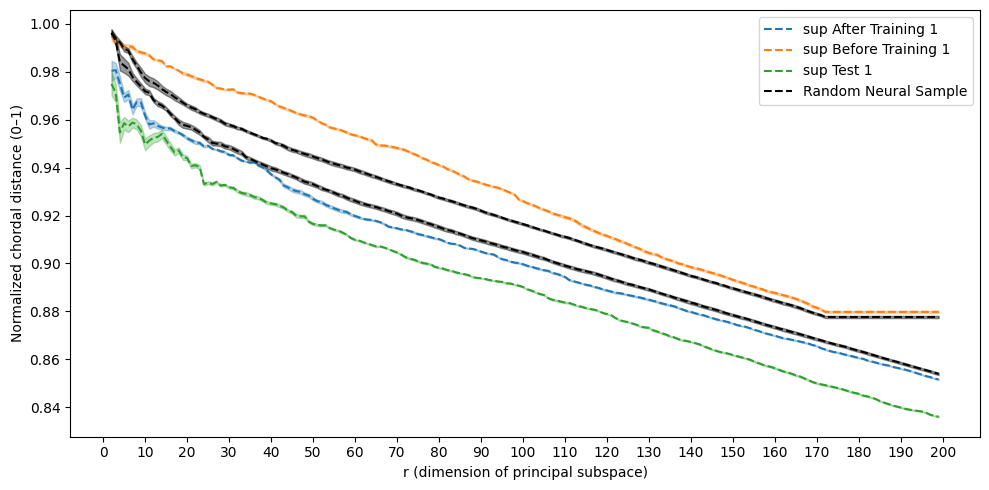

Processing condition: sup After Training 1
Processing condition: sup Before Training 1
Processing condition: sup Test 1


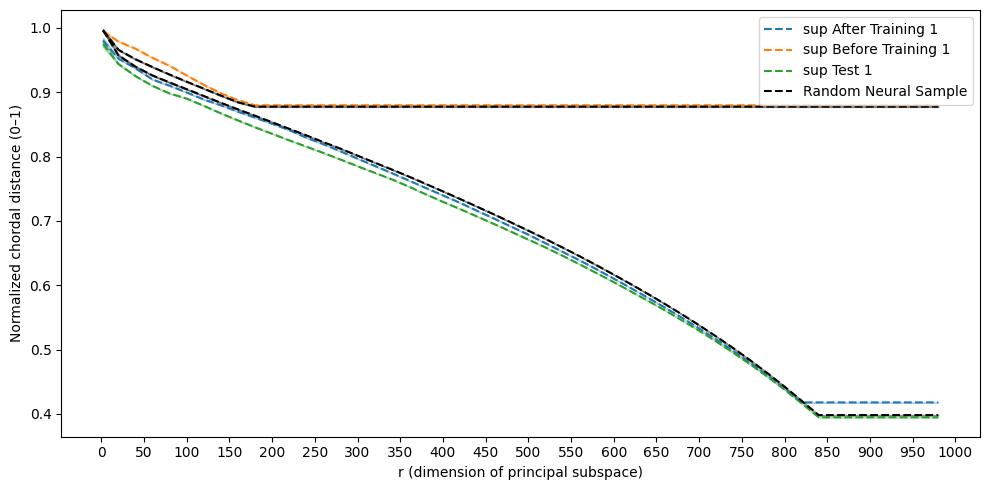

UnboundLocalError: cannot access local variable 'aft1_leaf1_counts' where it is not associated with a value

In [ ]:
sup_aft1_svd, sup_bef1_svd, sup_test1_svd, sup_aft1_corr_sets, sup_bef1_corr_sets, sup_test1_corr_sets, sup_aft1_leaf1_counts, sup_aft1_circle1_counts, sup_bef1_leaf1_counts, sup_bef1_circle1_counts, sup_test1_leaf1_counts, sup_test1_circle1_counts = multi_animals_pipeline(
    aft1='TX109_2023_04_07_1', bef1='TX109_2023_03_27_1', test1='TX109_2023_04_18_1',
    root=root,
    animal_type='sup',
    existing_svd_file='sup_svd.npz',
    plot_tuning_curves=False,
    plot_tuning_neuron_distr=True,
    plot_tuning_neuron_pos=False,
    plot_subspace_angles_zoomin=True,
    plot_subspace_angles_zoomout=True
)

unsup_aft1_svd, unsup_bef1_svd, unsup_test1_svd, unsup_aft1_corr_sets, unsup_bef1_corr_sets, unsup_test1_corr_sets, unsup_aft1_leaf1_counts, unsup_aft1_circle1_counts, unsup_bef1_leaf1_counts, unsup_bef1_circle1_counts, unsup_test1_leaf1_counts, unsup_test1_circle1_counts = multi_animals_pipeline(
    aft1='TX83_2022_08_29_1', bef1='TX83_2022_08_17_1', test1='TX83_2022_08_31_1',
    root=root,
    animal_type='unsup',
    existing_svd_file='unsup_svd.npz',
    plot_tuning_curves=False,
    plot_tuning_neuron_distr=True,
    plot_tuning_neuron_pos=False,
    plot_subspace_angles_zoomin=True,
    plot_subspace_angles_zoomout=True
)

sup1_aft1_svd, sup1_bef1_svd, sup1_test1_svd, sup1_aft1_corr_sets, sup1_bef1_corr_sets, sup1_test1_corr_sets, sup1_aft1_leaf1_counts, sup1_aft1_circle1_counts, sup1_bef1_leaf1_counts, sup1_bef1_circle1_counts, sup1_test1_leaf1_counts, sup1_test1_circle1_counts = multi_animals_pipeline(
    aft1='TX108_2023_03_22_1', bef1='TX108_2023_03_13_1', test1='TX108_2023_03_25_1',
    root=root,
    animal_type='sup',
    existing_svd_file='sup1_svd.npz',
    plot_tuning_curves=False,
    plot_tuning_neuron_distr=True,
    plot_tuning_neuron_pos=False,
    plot_subspace_angles_zoomin=True,
    plot_subspace_angles_zoomout=True
)

unsup1_aft1_svd, unsup1_bef1_svd, unsup1_test1_svd, unsup1_aft1_corr_sets, unsup1_bef1_corr_sets, unsup1_test1_corr_sets, unsup1_aft1_leaf1_counts, unsup1_aft1_circle1_counts, unsup1_bef1_leaf1_counts, unsup1_bef1_circle1_counts, unsup1_test1_leaf1_counts, unsup1_test1_circle1_counts = multi_animals_pipeline(
    aft1='TX119_2023_12_23_1', bef1='TX119_2023_12_14_1', test1='TX119_2023_12_24_1',
    root=root,
    animal_type='unsup',
    existing_svd_file='unsup1_svd.npz',
    plot_tuning_curves=False,
    plot_tuning_neuron_distr=True,
    plot_tuning_neuron_pos=False,
    plot_subspace_angles_zoomin=True,
    plot_subspace_angles_zoomout=True
)

sup2_aft1_svd, sup2_bef1_svd, sup2_test1_svd, sup2_aft1_corr_sets, sup2_bef1_corr_sets, sup2_test1_corr_sets, sup2_aft1_leaf1_counts, sup2_aft1_circle1_counts, sup2_bef1_leaf1_counts, sup2_bef1_circle1_counts, sup2_test1_leaf1_counts, sup2_test1_circle1_counts = multi_animals_pipeline(
    aft1='TX60_2021_05_04_1', bef1='TX60_2021_04_10_1', test1='TX60_2021_06_07_1',
    root=root,
    animal_type='sup',
    existing_svd_file='sup2_svd.npz',
    plot_tuning_curves=False,
    plot_tuning_neuron_distr=True,
    plot_tuning_neuron_pos=False,
    plot_subspace_angles_zoomin=True,
    plot_subspace_angles_zoomout=True
)

unsup2_aft1_svd, unsup2_bef1_svd, unsup2_test1_svd, unsup2_aft1_corr_sets, unsup2_bef1_corr_sets, unsup2_test1_corr_sets, unsup2_aft1_leaf1_counts, unsup2_aft1_circle1_counts, unsup2_bef1_leaf1_counts, unsup2_bef1_circle1_counts, unsup2_test1_leaf1_counts, unsup2_test1_circle1_counts = multi_animals_pipeline(
    aft1='TX88_2022_06_17_2', bef1='TX88_2022_06_13_2', test1='TX88_2022_06_20_1',
    root=root,
    animal_type='unsup',
    existing_svd_file='unsup2_svd.npz',
    plot_tuning_curves=False,
    plot_tuning_neuron_distr=True,
    plot_tuning_neuron_pos=False,
    plot_subspace_angles_zoomin=True,
    plot_subspace_angles_zoomout=True
)

unsup3_aft1_svd, unsup3_bef1_svd, unsup3_test1_svd, unsup3_aft1_corr_sets, unsup3_bef1_corr_sets, unsup3_test1_corr_sets, unsup3_aft1_leaf1_counts, unsup3_aft1_circle1_counts, unsup3_bef1_leaf1_counts, unsup3_bef1_circle1_counts, unsup3_test1_leaf1_counts, unsup3_test1_circle1_counts = multi_animals_pipeline(
    aft1='TX105_2022_10_19_2', bef1='TX105_2022_10_08_2', test1='TX105_2022_10_21_1',
    root=root,
    animal_type='unsup',
    existing_svd_file='unsup3_svd.npz',
    plot_tuning_curves=False,
    plot_tuning_neuron_distr=True,
    plot_tuning_neuron_pos=False,
    plot_subspace_angles_zoomin=True,
    plot_subspace_angles_zoomout=True
)

unsup4_aft1_svd, unsup4_bef1_svd, unsup4_test1_svd, unsup4_aft1_corr_sets, unsup4_bef1_corr_sets, unsup4_test1_corr_sets, unsup4_aft1_leaf1_counts, unsup4_aft1_circle1_counts, unsup4_bef1_leaf1_counts, unsup4_bef1_circle1_counts, unsup4_test1_leaf1_counts, unsup4_test1_circle1_counts = multi_animals_pipeline(
    aft1='TX123_2024_01_02_1', bef1='TX123_2023_12_21_1', test1='TX123_2024_01_03_1',
    root=root,
    animal_type='unsup',
    existing_svd_file='unsup4_svd.npz',
    plot_tuning_curves=False,
    plot_tuning_neuron_distr=True,
    plot_tuning_neuron_pos=False,
    plot_subspace_angles_zoomin=True,
    plot_subspace_angles_zoomout=True
)

'''
np.savez(os.path.join(root, 'svd', 'sup1_svd.npz'),
         aft1=sup1_aft1_svd,
         bef1=sup1_bef1_svd,
         test1=sup1_test1_svd
)

np.savez(os.path.join(root, 'svd', 'unsup1_svd.npz'),
         aft1=unsup1_aft1_svd,
         bef1=unsup1_bef1_svd,
         test1=unsup1_test1_svd
)

np.savez(os.path.join(root, 'svd', 'sup2_svd.npz'),
         aft1=sup2_aft1_svd,
         bef1=sup2_bef1_svd,
         test1=sup2_test1_svd
)

np.savez(os.path.join(root, 'svd', 'unsup2_svd.npz'),
         aft1=unsup2_aft1_svd,
         bef1=unsup2_bef1_svd,
         test1=unsup2_test1_svd
)

np.savez(os.path.join(root, 'svd', 'unsup3_svd.npz'),
         aft1=unsup3_aft1_svd,
         bef1=unsup3_bef1_svd,
         test1=unsup3_test1_svd
)

np.savez(os.path.join(root, 'svd', 'unsup4_svd.npz'),
         aft1=unsup4_aft1_svd,
         bef1=unsup4_bef1_svd,
         test1=unsup4_test1_svd
)
'''

## Tuning Neuron Num Change

In [15]:
sup_aft1_leaf1_counts_mat = np.array([sup_aft1_leaf1_counts, sup1_aft1_leaf1_counts, sup2_aft1_leaf1_counts])
sup_aft1_circle1_counts_mat = np.array([sup_aft1_circle1_counts, sup1_aft1_circle1_counts, sup2_aft1_circle1_counts])
sup_bef1_leaf1_counts_mat = np.array([sup_bef1_leaf1_counts, sup1_bef1_leaf1_counts, sup2_bef1_leaf1_counts])
sup_bef1_circle1_counts_mat = np.array([sup_bef1_circle1_counts, sup1_bef1_circle1_counts, sup2_bef1_circle1_counts])
sup_test1_leaf1_counts_mat = np.array([sup_test1_leaf1_counts, sup1_test1_leaf1_counts, sup2_test1_leaf1_counts])
sup_test1_circle1_counts_mat = np.array([sup_test1_circle1_counts, sup1_test1_circle1_counts, sup2_test1_circle1_counts])
unsup_aft1_leaf1_counts_mat = np.array([unsup_aft1_leaf1_counts, unsup1_aft1_leaf1_counts, unsup2_aft1_leaf1_counts, unsup3_aft1_leaf1_counts, unsup4_aft1_leaf1_counts])
unsup_aft1_circle1_counts_mat = np.array([unsup_aft1_circle1_counts, unsup1_aft1_circle1_counts, unsup2_aft1_circle1_counts, unsup3_aft1_circle1_counts, unsup4_aft1_circle1_counts])
unsup_bef1_leaf1_counts_mat = np.array([unsup_bef1_leaf1_counts, unsup1_bef1_leaf1_counts, unsup2_bef1_leaf1_counts, unsup3_bef1_leaf1_counts, unsup4_bef1_leaf1_counts])
unsup_bef1_circle1_counts_mat = np.array([unsup_bef1_circle1_counts, unsup1_bef1_circle1_counts, unsup2_bef1_circle1_counts, unsup3_bef1_circle1_counts, unsup4_bef1_circle1_counts])
unsup_test1_leaf1_counts_mat = np.array([unsup_test1_leaf1_counts, unsup1_test1_leaf1_counts, unsup2_test1_leaf1_counts, unsup3_test1_leaf1_counts, unsup4_test1_leaf1_counts])
unsup_test1_circle1_counts_mat = np.array([unsup_test1_circle1_counts, unsup1_test1_circle1_counts, unsup2_test1_circle1_counts, unsup3_test1_circle1_counts, unsup4_test1_circle1_counts])

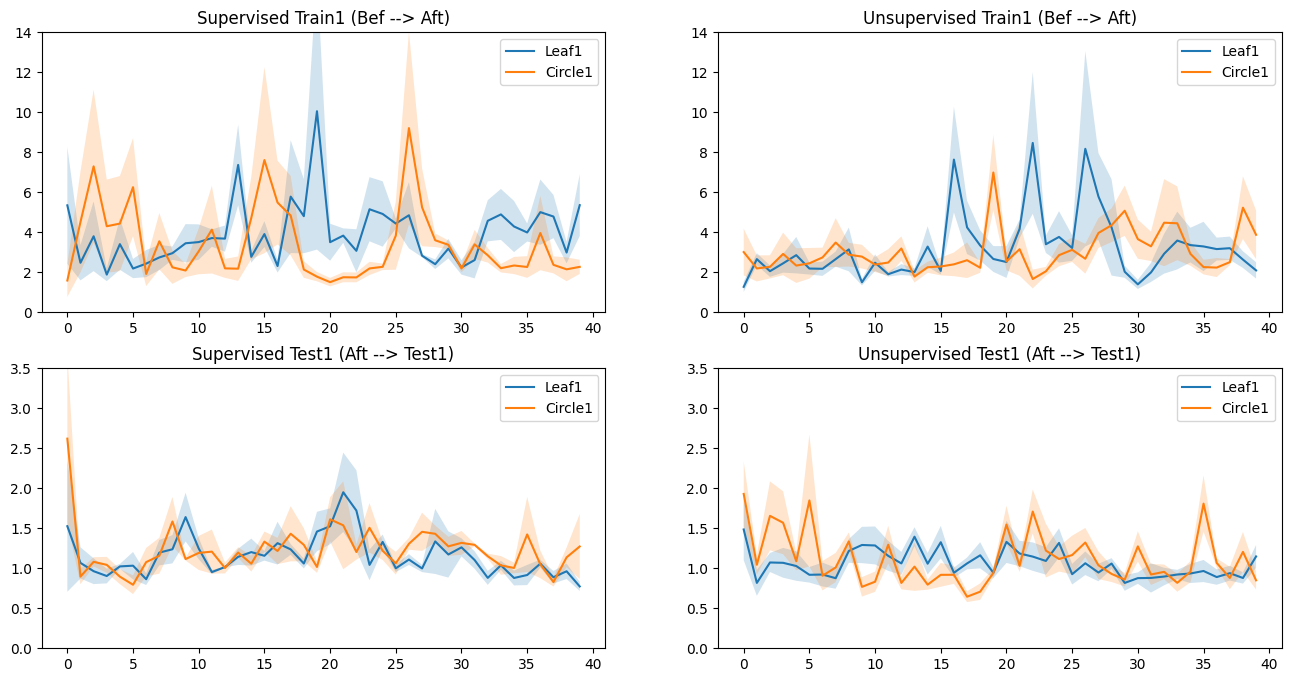

In [ ]:
sup_aft1_bef1_leaf1_change = np.nanmean(np.divide(sup_aft1_leaf1_counts_mat, sup_bef1_leaf1_counts_mat, out=np.full_like(sup_aft1_leaf1_counts_mat, np.nan, dtype=float), where=sup_bef1_leaf1_counts_mat!=0), axis=0)[:40]
sup_aft1_bef1_circle1_change = np.nanmean(np.divide(sup_aft1_circle1_counts_mat, sup_bef1_circle1_counts_mat, out=np.full_like(sup_aft1_circle1_counts_mat, np.nan, dtype=float), where=sup_bef1_circle1_counts_mat!=0), axis=0)[:40]
sup_test1_aft1_leaf1_change = np.nanmean(np.divide(sup_test1_leaf1_counts_mat, sup_aft1_leaf1_counts_mat, out=np.full_like(sup_test1_leaf1_counts_mat, np.nan, dtype=float), where=sup_aft1_leaf1_counts_mat!=0), axis=0)[:40]
sup_test1_aft1_circle1_change = np.nanmean(np.divide(sup_test1_circle1_counts_mat, sup_aft1_circle1_counts_mat, out=np.full_like(sup_test1_circle1_counts_mat, np.nan, dtype=float), where=sup_aft1_circle1_counts_mat!=0), axis=0)[:40]

sup_aft1_bef1_leaf1_sem = np.nanstd(np.divide(sup_aft1_leaf1_counts_mat, sup_bef1_leaf1_counts_mat, out=np.full_like(sup_aft1_leaf1_counts_mat, np.nan, dtype=float), where=sup_bef1_leaf1_counts_mat!=0), axis=0)[:40] / np.sqrt(sup_aft1_leaf1_counts_mat.shape[0])
sup_aft1_bef1_circle1_sem = np.nanstd(np.divide(sup_aft1_circle1_counts_mat, sup_bef1_circle1_counts_mat, out=np.full_like(sup_aft1_circle1_counts_mat, np.nan, dtype=float), where=sup_bef1_circle1_counts_mat!=0), axis=0)[:40] / np.sqrt(sup_aft1_circle1_counts_mat.shape[0])
sup_test1_aft1_leaf1_sem = np.nanstd(np.divide(sup_test1_leaf1_counts_mat, sup_aft1_leaf1_counts_mat, out=np.full_like(sup_test1_leaf1_counts_mat, np.nan, dtype=float), where=sup_aft1_leaf1_counts_mat!=0), axis=0)[:40] / np.sqrt(sup_test1_leaf1_counts_mat.shape[0])
sup_test1_aft1_circle1_sem = np.nanstd(np.divide(sup_test1_circle1_counts_mat, sup_aft1_circle1_counts_mat, out=np.full_like(sup_test1_circle1_counts_mat, np.nan, dtype=float), where=sup_aft1_circle1_counts_mat!=0), axis=0)[:40] / np.sqrt(sup_test1_circle1_counts_mat.shape[0])

unsup_aft1_bef1_leaf1_change = np.nanmean(np.divide(unsup_aft1_leaf1_counts_mat, unsup_bef1_leaf1_counts_mat, out=np.full_like(unsup_aft1_leaf1_counts_mat, np.nan, dtype=float), where=unsup_bef1_leaf1_counts_mat!=0), axis=0)[:40]
unsup_aft1_bef1_circle1_change = np.nanmean(np.divide(unsup_aft1_circle1_counts_mat, unsup_bef1_circle1_counts_mat, out=np.full_like(unsup_aft1_circle1_counts_mat, np.nan, dtype=float), where=unsup_bef1_circle1_counts_mat!=0), axis=0)[:40]
unsup_test1_aft1_leaf1_change = np.nanmean(np.divide(unsup_test1_leaf1_counts_mat, unsup_aft1_leaf1_counts_mat, out=np.full_like(unsup_test1_leaf1_counts_mat, np.nan, dtype=float), where=unsup_aft1_leaf1_counts_mat!=0), axis=0)[:40]
unsup_test1_aft1_circle1_change = np.nanmean(np.divide(unsup_test1_circle1_counts_mat, unsup_aft1_circle1_counts_mat, out=np.full_like(unsup_test1_circle1_counts_mat, np.nan, dtype=float), where=unsup_aft1_circle1_counts_mat!=0), axis=0)[:40]

unsup_aft1_bef1_leaf1_sem = np.nanstd(np.divide(unsup_aft1_leaf1_counts_mat, unsup_bef1_leaf1_counts_mat, out=np.full_like(unsup_aft1_leaf1_counts_mat, np.nan, dtype=float), where=unsup_bef1_leaf1_counts_mat!=0), axis=0)[:40] / np.sqrt(unsup_aft1_leaf1_counts_mat.shape[0])
unsup_aft1_bef1_circle1_sem = np.nanstd(np.divide(unsup_aft1_circle1_counts_mat, unsup_bef1_circle1_counts_mat, out=np.full_like(unsup_aft1_circle1_counts_mat, np.nan, dtype=float), where=unsup_bef1_circle1_counts_mat!=0), axis=0)[:40] / np.sqrt(unsup_aft1_circle1_counts_mat.shape[0])
unsup_test1_aft1_leaf1_sem = np.nanstd(np.divide(unsup_test1_leaf1_counts_mat, unsup_aft1_leaf1_counts_mat, out=np.full_like(unsup_test1_leaf1_counts_mat, np.nan, dtype=float), where=unsup_aft1_leaf1_counts_mat!=0), axis=0)[:40] / np.sqrt(unsup_test1_leaf1_counts_mat.shape[0])
unsup_test1_aft1_circle1_sem = np.nanstd(np.divide(unsup_test1_circle1_counts_mat, unsup_aft1_circle1_counts_mat, out=np.full_like(unsup_test1_circle1_counts_mat, np.nan, dtype=float), where=unsup_aft1_circle1_counts_mat!=0), axis=0)[:40] / np.sqrt(unsup_test1_circle1_counts_mat.shape[0])


# Plotting the changes in tuning neuron counts
plt.figure(figsize=(16, 8))
plt.subplot(2,2,1)
plt.title("Supervised Train1 (Bef --> Aft)")
plt.plot(sup_aft1_bef1_leaf1_change, label="Leaf1")
plt.plot(sup_aft1_bef1_circle1_change, label="Circle1")
plt.fill_between(np.arange(len(sup_aft1_bef1_leaf1_change)), sup_aft1_bef1_leaf1_change - sup_aft1_bef1_leaf1_sem, sup_aft1_bef1_leaf1_change + sup_aft1_bef1_leaf1_sem, alpha=0.2)
plt.fill_between(np.arange(len(sup_aft1_bef1_circle1_change)), sup_aft1_bef1_circle1_change - sup_aft1_bef1_circle1_sem, sup_aft1_bef1_circle1_change + sup_aft1_bef1_circle1_sem, alpha=0.2)
plt.ylim([0, 14])
plt.legend()

plt.subplot(2,2,2)
plt.title("Unsupervised Train1 (Bef --> Aft)")
plt.plot(unsup_aft1_bef1_leaf1_change, label="Leaf1")
plt.plot(unsup_aft1_bef1_circle1_change, label="Circle1")
plt.fill_between(np.arange(len(unsup_aft1_bef1_leaf1_change)), unsup_aft1_bef1_leaf1_change - unsup_aft1_bef1_leaf1_sem, unsup_aft1_bef1_leaf1_change + unsup_aft1_bef1_leaf1_sem, alpha=0.2)
plt.fill_between(np.arange(len(unsup_aft1_bef1_circle1_change)), unsup_aft1_bef1_circle1_change - unsup_aft1_bef1_circle1_sem, unsup_aft1_bef1_circle1_change + unsup_aft1_bef1_circle1_sem, alpha=0.2)
plt.ylim([0, 14])
plt.legend()

plt.subplot(2,2,3)
plt.title("Supervised Test1 (Aft --> Test1)")
plt.plot(sup_test1_aft1_leaf1_change, label="Leaf1")
plt.plot(sup_test1_aft1_circle1_change, label="Circle1")
plt.fill_between(np.arange(len(sup_test1_aft1_leaf1_change)), sup_test1_aft1_leaf1_change - sup_test1_aft1_leaf1_sem, sup_test1_aft1_leaf1_change + sup_test1_aft1_leaf1_sem, alpha=0.2)
plt.fill_between(np.arange(len(sup_test1_aft1_circle1_change)), sup_test1_aft1_circle1_change - sup_test1_aft1_circle1_sem, sup_test1_aft1_circle1_change + sup_test1_aft1_circle1_sem, alpha=0.2)
plt.ylim([0, 3.5])
plt.legend()

plt.subplot(2,2,4)
plt.title("Unsupervised Test1 (Aft --> Test1)")
plt.plot(unsup_test1_aft1_leaf1_change, label="Leaf1")
plt.plot(unsup_test1_aft1_circle1_change, label="Circle1")
plt.fill_between(np.arange(len(unsup_test1_aft1_leaf1_change)), unsup_test1_aft1_leaf1_change - unsup_test1_aft1_leaf1_sem, unsup_test1_aft1_leaf1_change + unsup_test1_aft1_leaf1_sem, alpha=0.2)
plt.fill_between(np.arange(len(unsup_test1_aft1_circle1_change)), unsup_test1_aft1_circle1_change - unsup_test1_aft1_circle1_sem, unsup_test1_aft1_circle1_change + unsup_test1_aft1_circle1_sem, alpha=0.2)
plt.ylim([0, 3.5])
plt.legend()



p_sup: 0.12925169711421694, p_uns: 0.581248765613491, p_diff: 0.17898643241381618, p_leaf: 0.01915787756193763, p_circ: 0.8768598269645717
p_sup: 0.001490333031727307, p_uns: 0.4933987929051763, p_diff: 0.012367887890285208, p_leaf: 0.0935845947241088, p_circ: 0.01636136377977476
p_sup: 0.49238794166539435, p_uns: 0.5341935614345587, p_diff: 0.4777159348485256, p_leaf: 0.028799777817396954, p_circ: 0.46269023695515943


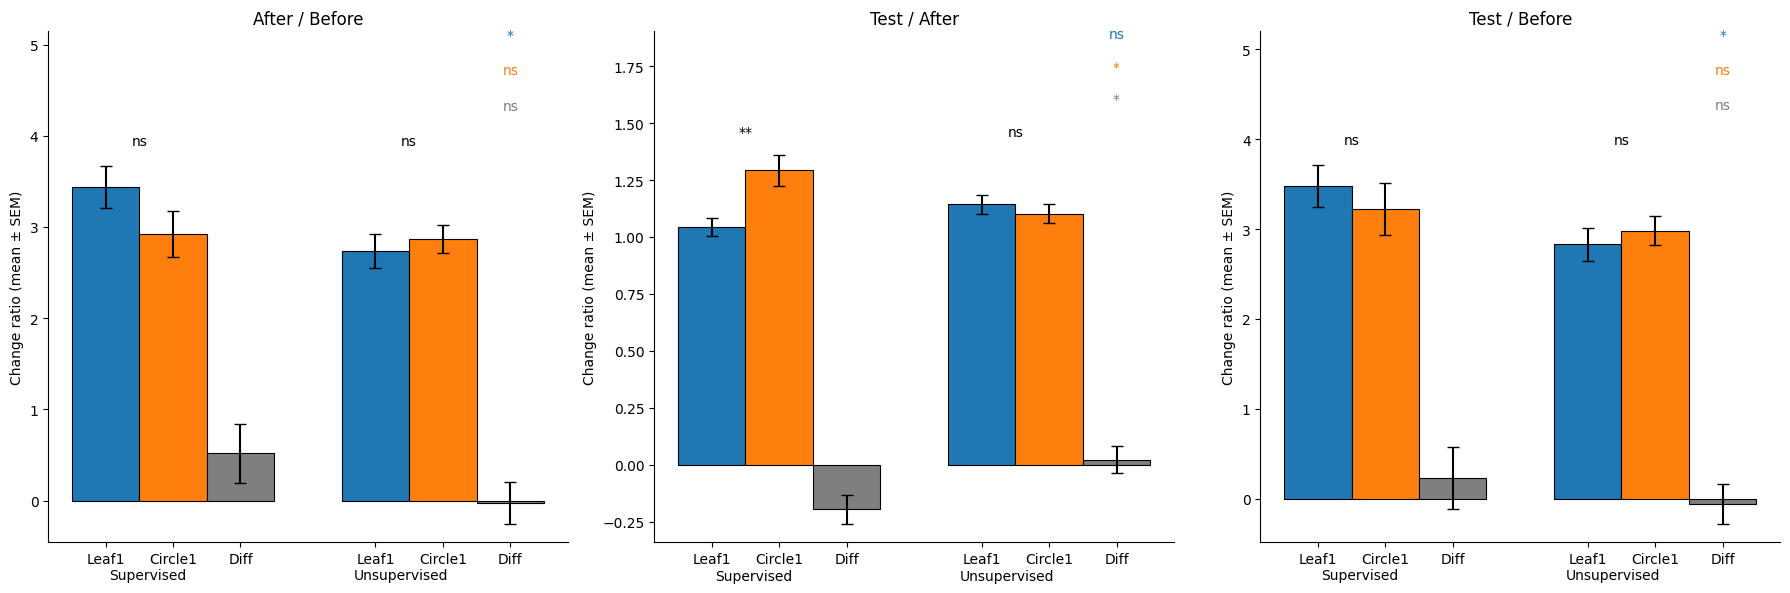

In [45]:

# NaN where denom==0
sup_leaf1 = np.divide(sup_aft1_leaf1_counts_mat, sup_bef1_leaf1_counts_mat, out=np.full_like(sup_aft1_leaf1_counts_mat, np.nan, dtype=float), where=sup_bef1_leaf1_counts_mat!=0)[:40]
sup_circ1 = np.divide(sup_aft1_circle1_counts_mat, sup_bef1_circle1_counts_mat, out=np.full_like(sup_aft1_circle1_counts_mat, np.nan, dtype=float), where=sup_bef1_circle1_counts_mat!=0)[:40]
uns_leaf1 = np.divide(unsup_aft1_leaf1_counts_mat, unsup_bef1_leaf1_counts_mat, out=np.full_like(unsup_aft1_leaf1_counts_mat, np.nan, dtype=float), where=unsup_bef1_leaf1_counts_mat!=0)[:40]
uns_circ1 = np.divide(unsup_aft1_circle1_counts_mat, unsup_bef1_circle1_counts_mat, out=np.full_like(unsup_aft1_circle1_counts_mat, np.nan, dtype=float), where=unsup_bef1_circle1_counts_mat!=0)[:40]

means1 = np.array([np.nanmean(sup_leaf1), np.nanmean(sup_circ1), np.nanmean(sup_leaf1 - sup_circ1), np.nanmean(uns_leaf1), np.nanmean(uns_circ1),
                   np.nanmean(uns_leaf1 - uns_circ1)])
sems1  = np.array([np.nanstd(sup_leaf1) / np.sqrt(np.isfinite(sup_leaf1).sum()),
                  np.nanstd(sup_circ1) / np.sqrt(np.isfinite(sup_circ1).sum()),
                  np.nanstd(sup_leaf1 - sup_circ1) / np.sqrt(np.isfinite(sup_leaf1 - sup_circ1).sum()),
                  np.nanstd(uns_leaf1) / np.sqrt(np.isfinite(uns_leaf1).sum()),
                  np.nanstd(uns_circ1) / np.sqrt(np.isfinite(uns_circ1).sum()),
                  np.nanstd(uns_leaf1 - uns_circ1) / np.sqrt(np.isfinite(uns_leaf1 - uns_circ1).sum())])

sup_leaf2 = np.divide(sup_test1_leaf1_counts_mat, sup_aft1_leaf1_counts_mat, out=np.full_like(sup_test1_leaf1_counts_mat, np.nan, dtype=float), where=sup_aft1_leaf1_counts_mat!=0)[:40]
sup_circ2 = np.divide(sup_test1_circle1_counts_mat, sup_aft1_circle1_counts_mat, out=np.full_like(sup_test1_circle1_counts_mat, np.nan, dtype=float), where=sup_aft1_circle1_counts_mat!=0)[:40]
uns_leaf2 = np.divide(unsup_test1_leaf1_counts_mat, unsup_aft1_leaf1_counts_mat, out=np.full_like(unsup_test1_leaf1_counts_mat, np.nan, dtype=float), where=unsup_aft1_leaf1_counts_mat!=0)[:40]
uns_circ2 = np.divide(unsup_test1_circle1_counts_mat, unsup_aft1_circle1_counts_mat, out=np.full_like(unsup_test1_circle1_counts_mat, np.nan, dtype=float), where=unsup_aft1_circle1_counts_mat!=0)[:40]

means2 = np.array([np.nanmean(sup_leaf2), np.nanmean(sup_circ2), np.nanmean(sup_leaf2 - sup_circ2), np.nanmean(uns_leaf2), np.nanmean(uns_circ2),
                   np.nanmean(uns_leaf2 - uns_circ2)])
sems2  = np.array([np.nanstd(sup_leaf2) / np.sqrt(np.isfinite(sup_leaf2).sum()),
                  np.nanstd(sup_circ2) / np.sqrt(np.isfinite(sup_circ2).sum()),
                  np.nanstd(sup_leaf2 - sup_circ2) / np.sqrt(np.isfinite(sup_leaf2 - sup_circ2).sum()),
                  np.nanstd(uns_leaf2) / np.sqrt(np.isfinite(uns_leaf2).sum()),
                  np.nanstd(uns_circ2) / np.sqrt(np.isfinite(uns_circ2).sum()),
                  np.nanstd(uns_leaf2 - uns_circ2) / np.sqrt(np.isfinite(uns_leaf2 - uns_circ2).sum())])

sup_leaf3 = np.divide(sup_test1_leaf1_counts_mat, sup_bef1_leaf1_counts_mat, out=np.full_like(sup_test1_leaf1_counts_mat, np.nan, dtype=float), where=sup_bef1_leaf1_counts_mat!=0)[:40]
sup_circ3 = np.divide(sup_test1_circle1_counts_mat, sup_bef1_circle1_counts_mat, out=np.full_like(sup_test1_circle1_counts_mat, np.nan, dtype=float), where=sup_bef1_circle1_counts_mat!=0)[:40]
uns_leaf3 = np.divide(unsup_test1_leaf1_counts_mat, unsup_bef1_leaf1_counts_mat, out=np.full_like(unsup_test1_leaf1_counts_mat, np.nan, dtype=float), where=unsup_bef1_leaf1_counts_mat!=0)[:40]
uns_circ3 = np.divide(unsup_test1_circle1_counts_mat, unsup_bef1_circle1_counts_mat, out=np.full_like(unsup_test1_circle1_counts_mat, np.nan, dtype=float), where=unsup_bef1_circle1_counts_mat!=0)[:40]

means3 = np.array([np.nanmean(sup_leaf3), np.nanmean(sup_circ3), np.nanmean(sup_leaf3 - sup_circ3), np.nanmean(uns_leaf3), np.nanmean(uns_circ3),
                   np.nanmean(uns_leaf3 - uns_circ3)])
sems3  = np.array([np.nanstd(sup_leaf3) / np.sqrt(np.isfinite(sup_leaf3).sum()),
                  np.nanstd(sup_circ3) / np.sqrt(np.isfinite(sup_circ3).sum()),
                  np.nanstd(sup_leaf3 - sup_circ3) / np.sqrt(np.isfinite(sup_leaf3 - sup_circ3).sum()),
                  np.nanstd(uns_leaf3) / np.sqrt(np.isfinite(uns_leaf3).sum()),
                  np.nanstd(uns_circ3) / np.sqrt(np.isfinite(uns_circ3).sum()),
                  np.nanstd(uns_leaf3 - uns_circ3) / np.sqrt(np.isfinite(uns_leaf3 - uns_circ3).sum())])

xs = np.array([0.0, 0.8, 1.6, 3.2, 4.0, 4.8])  # gap between groups
colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:blue', 'tab:orange', 'tab:gray']

fig, ax = plt.subplots(1, 3, figsize=(18,6))
ax[0].bar(xs, means1, yerr=sems1, capsize=4, width=0.8, color=colors, edgecolor="black", linewidth=0.8)

ax[0].set_xticks(xs)
ax[0].set_xticklabels(["Leaf1", "Circle1", 'Diff', "Leaf1", "Circle1", 'Diff'])
ax[0].set_ylabel("Change ratio (mean ± SEM)")
ax[0].set_title("After / Before")

# group labels
ylim = ax[0].get_ylim()
span = ylim[1] - ylim[0]
ax[0].text(0.5, ylim[0] - 0.1*span, "Supervised", ha="center", va="bottom")
ax[0].text(3.5, ylim[0] - 0.1*span, "Unsupervised", ha="center", va="bottom")

def p_to_stars(p):
    return "****" if p < 1e-4 else "***" if p < 1e-3 else "**" if p < 1e-2 else "*" if p < 5e-2 else "ns"

# p-values
p_sup = ttest_ind(sup_leaf1.reshape(-1), sup_circ1.reshape(-1), nan_policy="omit", equal_var=True).pvalue          # within supervised
p_uns = ttest_ind(uns_leaf1.reshape(-1), uns_circ1.reshape(-1), nan_policy="omit", equal_var=True).pvalue          # within unsupervised
p_diff = ttest_ind(sup_leaf1.reshape(-1) - sup_circ1.reshape(-1), uns_leaf1.reshape(-1) - uns_circ1.reshape(-1), nan_policy="omit", equal_var=False).pvalue  # cross: diff
p_leaf = ttest_ind(sup_leaf1.reshape(-1), uns_leaf1.reshape(-1), nan_policy="omit", equal_var=False).pvalue        # cross: leaf
p_circ = ttest_ind(sup_circ1.reshape(-1), uns_circ1.reshape(-1), nan_policy="omit", equal_var=False).pvalue        # cross: circle
print(f"p_sup: {p_sup}, p_uns: {p_uns}, p_diff: {p_diff}, p_leaf: {p_leaf}, p_circ: {p_circ}")

y0 = np.nanmax(means1 + sems1)
if not np.isfinite(y0): y0 = 1.0
h  = 0.05 * (y0 if y0 != 0 else 1.0)

# within-group (black)
#ax[0].plot([xs[0], xs[0], xs[1], xs[1]], [y0, y0+h, y0+h, y0], color="k", lw=1.5)
ax[0].text((xs[0]+xs[1])/2, y0+h*1.05, p_to_stars(p_sup), ha="center", va="bottom", color="k")

#ax[0].plot([xs[2], xs[2], xs[3], xs[3]], [y0+2*h, y0+3*h, y0+3*h, y0+2*h], color="k", lw=1.5)
ax[0].text((xs[3]+xs[4])/2, y0+h*1.05, p_to_stars(p_uns), ha="center", va="bottom", color="k")

# cross-group: leaf (blue), circle (orange)
#ax[0].plot([xs[0], xs[0], xs[2], xs[2]], [y0+4*h, y0+5*h, y0+5*h, y0+4*h], color="tab:blue", lw=1.5)
#ax[0].text((xs[0]+xs[2])/2, y0+5*h*1.05, p_to_stars(p_leaf), ha="center", va="bottom", color="tab:blue")
ax[0].text(xs[5], y0+7*h*1.05, p_to_stars(p_leaf), ha="center", va="bottom", color="tab:blue")

#ax[0].plot([xs[1], xs[1], xs[3], xs[3]], [y0+6*h, y0+7*h, y0+7*h, y0+6*h], color="tab:orange", lw=1.5)
#ax[0].text((xs[1]+xs[3])/2, y0+7*h*1.05, p_to_stars(p_circ), ha="center", va="bottom", color="tab:orange")
ax[0].text(xs[5], y0+5*h*1.05, p_to_stars(p_circ), ha="center", va="bottom", color="tab:orange")

ax[0].text(xs[5], y0+3*h*1.05, p_to_stars(p_diff), ha="center", va="bottom", color="tab:gray")

ax[0].set_ylim(top=y0 + 8*h)

# tidy
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)




ax[1].bar(xs, means2, yerr=sems2, capsize=4, width=0.8, color=colors, edgecolor="black", linewidth=0.8)

ax[1].set_xticks(xs)
ax[1].set_xticklabels(["Leaf1", "Circle1", "Diff", "Leaf1", "Circle1", "Diff"])
ax[1].set_ylabel("Change ratio (mean ± SEM)")
ax[1].set_title("Test / After")

# group labels
ylim = ax[1].get_ylim()
span = ylim[1] - ylim[0]
ax[1].text(0.5, ylim[0] - 0.1*span, "Supervised", ha="center", va="bottom")
ax[1].text(3.5, ylim[0] - 0.1*span, "Unsupervised", ha="center", va="bottom")

def p_to_stars(p):
    return "****" if p < 1e-4 else "***" if p < 1e-3 else "**" if p < 1e-2 else "*" if p < 5e-2 else "ns"

# p-values
p_sup = ttest_ind(sup_leaf2.reshape(-1), sup_circ2.reshape(-1), nan_policy="omit", equal_var=True).pvalue          # within supervised
p_uns = ttest_ind(uns_leaf2.reshape(-1), uns_circ2.reshape(-1), nan_policy="omit", equal_var=True).pvalue          # within unsupervised
p_diff = ttest_ind(sup_leaf2.reshape(-1) - sup_circ2.reshape(-1), uns_leaf2.reshape(-1) - uns_circ2.reshape(-1), nan_policy="omit", equal_var=False).pvalue  # cross: diff
p_leaf = ttest_ind(sup_leaf2.reshape(-1),  uns_leaf2.reshape(-1),  nan_policy="omit", equal_var=False).pvalue        # cross: leaf
p_circ = ttest_ind(sup_circ2.reshape(-1),  uns_circ2.reshape(-1),  nan_policy="omit", equal_var=False).pvalue        # cross: circle

print(f"p_sup: {p_sup}, p_uns: {p_uns}, p_diff: {p_diff}, p_leaf: {p_leaf}, p_circ: {p_circ}")

y0 = np.nanmax(means2 + sems2)
if not np.isfinite(y0): y0 = 1.0
h  = 0.05 * (y0 if y0 != 0 else 1.0)

# within-group (black)
#ax[1].plot([xs[0], xs[0], xs[1], xs[1]], [y0, y0+h, y0+h, y0], color="k", lw=1.5)
ax[1].text((xs[0]+xs[1])/2, y0+h*1.05, p_to_stars(p_sup), ha="center", va="bottom", color="k")

#ax[1].plot([xs[2], xs[2], xs[3], xs[3]], [y0+2*h, y0+3*h, y0+3*h, y0+2*h], color="k", lw=1.5)
ax[1].text((xs[3]+xs[4])/2, y0+h*1.05, p_to_stars(p_uns), ha="center", va="bottom", color="k")

# cross-group: leaf (blue), circle (orange)
#ax[1].plot([xs[0], xs[0], xs[2], xs[2]], [y0+4*h, y0+5*h, y0+5*h, y0+4*h], color="tab:blue", lw=1.5)
#ax[1].text((xs[0]+xs[2])/2, y0+5*h*1.05, p_to_stars(p_leaf), ha="center", va="bottom", color="tab:blue")
ax[1].text(xs[5], y0+7*h*1.05, p_to_stars(p_leaf), ha="center", va="bottom", color="tab:blue")

#ax[1].plot([xs[1], xs[1], xs[3], xs[3]], [y0+6*h, y0+7*h, y0+7*h, y0+6*h], color="tab:orange", lw=1.5)
#ax[1].text((xs[1]+xs[3])/2, y0+7*h*1.05, p_to_stars(p_circ), ha="center", va="bottom", color="tab:orange")
ax[1].text(xs[5], y0+5*h*1.05, p_to_stars(p_circ), ha="center", va="bottom", color="tab:orange")

ax[1].text(xs[5], y0+3*h*1.05, p_to_stars(p_diff), ha="center", va="bottom", color="tab:gray")

ax[1].set_ylim(top=y0 + 8*h)

# tidy
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)




ax[2].bar(xs, means3, yerr=sems3, capsize=4, width=0.8, color=colors, edgecolor="black", linewidth=0.8)

ax[2].set_xticks(xs)
ax[2].set_xticklabels(["Leaf1", "Circle1", "Diff", "Leaf1", "Circle1", "Diff"])
ax[2].set_ylabel("Change ratio (mean ± SEM)")
ax[2].set_title("Test / Before")

# group labels
ylim = ax[2].get_ylim()
span = ylim[1] - ylim[0]
ax[2].text(0.5, ylim[0] - 0.1*span, "Supervised", ha="center", va="bottom")
ax[2].text(3.5, ylim[0] - 0.1*span, "Unsupervised", ha="center", va="bottom")

def p_to_stars(p):
    return "****" if p < 1e-4 else "***" if p < 1e-3 else "**" if p < 1e-2 else "*" if p < 5e-2 else "ns"

# p-values
p_sup = ttest_ind(sup_leaf3.reshape(-1), sup_circ3.reshape(-1), nan_policy="omit", equal_var=True).pvalue          # within supervised
p_uns = ttest_ind(uns_leaf3.reshape(-1), uns_circ3.reshape(-1), nan_policy="omit", equal_var=True).pvalue          # within unsupervised
p_diff = ttest_ind(sup_leaf3.reshape(-1) - sup_circ3.reshape(-1), uns_leaf3.reshape(-1) - uns_circ3.reshape(-1), nan_policy="omit", equal_var=False).pvalue  # cross: diff
p_leaf = ttest_ind(sup_leaf3.reshape(-1),  uns_leaf3.reshape(-1),  nan_policy="omit", equal_var=False).pvalue        # cross: leaf
p_circ = ttest_ind(sup_circ3.reshape(-1),  uns_circ3.reshape(-1),  nan_policy="omit", equal_var=False).pvalue        # cross: circle

print(f"p_sup: {p_sup}, p_uns: {p_uns}, p_diff: {p_diff}, p_leaf: {p_leaf}, p_circ: {p_circ}")

y0 = np.nanmax(means3 + sems3)
if not np.isfinite(y0): y0 = 1.0
h  = 0.05 * (y0 if y0 != 0 else 1.0)

# within-group (black)
#ax[1].plot([xs[0], xs[0], xs[1], xs[1]], [y0, y0+h, y0+h, y0], color="k", lw=1.5)
ax[2].text((xs[0]+xs[1])/2, y0+h*1.05, p_to_stars(p_sup), ha="center", va="bottom", color="k")

#ax[1].plot([xs[2], xs[2], xs[3], xs[3]], [y0+2*h, y0+3*h, y0+3*h, y0+2*h], color="k", lw=1.5)
ax[2].text((xs[3]+xs[4])/2, y0+h*1.05, p_to_stars(p_uns), ha="center", va="bottom", color="k")

# cross-group: leaf (blue), circle (orange)
#ax[1].plot([xs[0], xs[0], xs[2], xs[2]], [y0+4*h, y0+5*h, y0+5*h, y0+4*h], color="tab:blue", lw=1.5)
#ax[1].text((xs[0]+xs[2])/2, y0+5*h*1.05, p_to_stars(p_leaf), ha="center", va="bottom", color="tab:blue")
ax[2].text(xs[5], y0+7*h*1.05, p_to_stars(p_leaf), ha="center", va="bottom", color="tab:blue")

#ax[1].plot([xs[1], xs[1], xs[3], xs[3]], [y0+6*h, y0+7*h, y0+7*h, y0+6*h], color="tab:orange", lw=1.5)
#ax[1].text((xs[1]+xs[3])/2, y0+7*h*1.05, p_to_stars(p_circ), ha="center", va="bottom", color="tab:orange")
ax[2].text(xs[5], y0+5*h*1.05, p_to_stars(p_circ), ha="center", va="bottom", color="tab:orange")

ax[2].text(xs[5], y0+3*h*1.05, p_to_stars(p_diff), ha="center", va="bottom", color="tab:gray")

ax[2].set_ylim(top=y0 + 8*h)

# tidy
ax[2].spines["right"].set_visible(False)
ax[2].spines["top"].set_visible(False)



plt.tight_layout()
plt.show()


p_sup: 0.7631933079078732, p_uns: 0.9367861835279844, p_diff: 0.35672511836666443, p_leaf: 0.4194993564799849, p_circ: 0.6959915815461593
p_sup: 0.6756480582284099, p_uns: 0.9069266741459088, p_diff: 0.544593388438973, p_leaf: 0.46287623952924806, p_circ: 0.2640412465859945
p_sup: 0.7850656008138058, p_uns: 0.8726151504441325, p_diff: 0.3457130006609329, p_leaf: 0.332157508438746, p_circ: 0.493305518610088


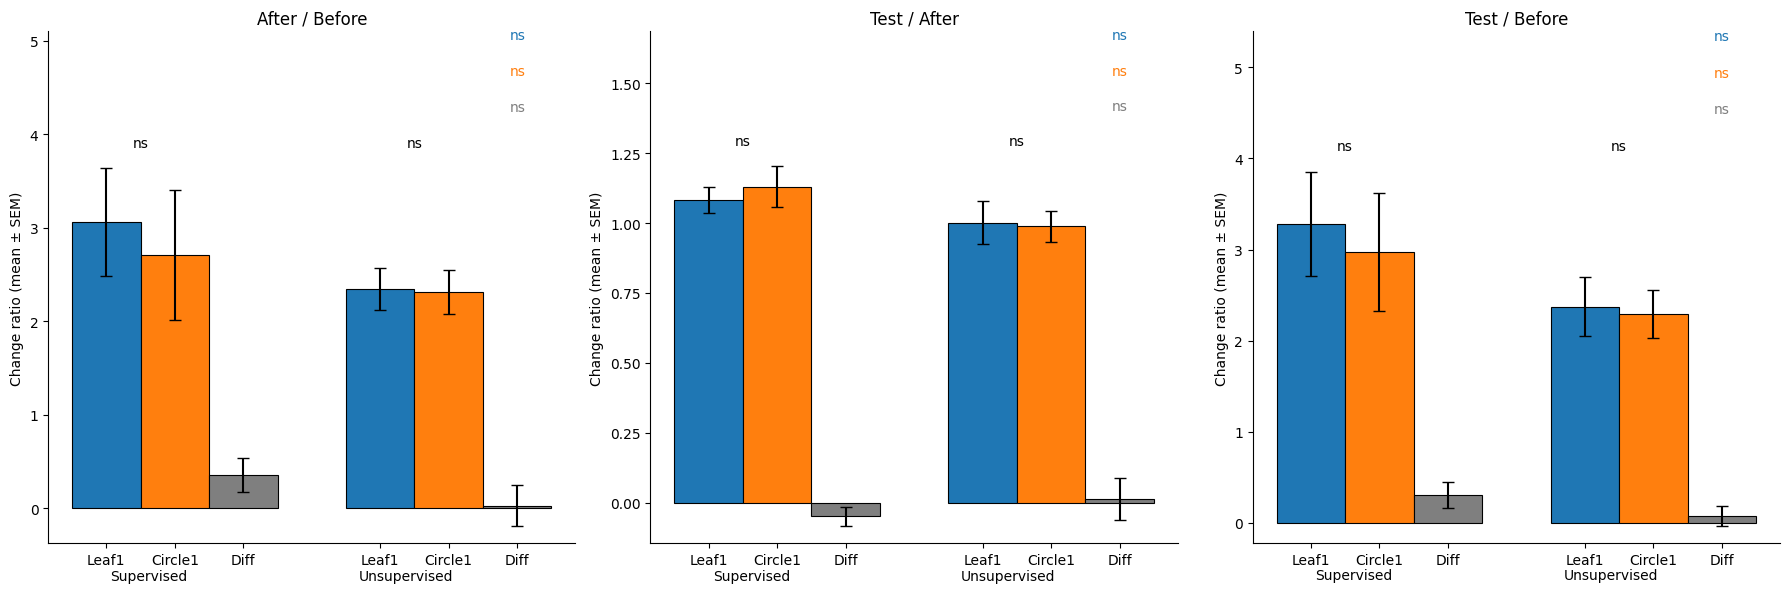

In [47]:
from scipy.stats import ttest_ind

# NaN where denom==0
sup_leaf1 = np.divide(sup_aft1_leaf1_counts_mat[:, :40].sum(axis=1), sup_bef1_leaf1_counts_mat[:, :40].sum(axis=1), out=np.full_like(sup_aft1_leaf1_counts_mat[:, :40].sum(axis=1), np.nan, dtype=float), where=sup_bef1_leaf1_counts_mat[:, :40].sum(axis=1)!=0)
sup_circ1 = np.divide(sup_aft1_circle1_counts_mat[:, :40].sum(axis=1), sup_bef1_circle1_counts_mat[:, :40].sum(axis=1), out=np.full_like(sup_aft1_circle1_counts_mat[:, :40].sum(axis=1), np.nan, dtype=float), where=sup_bef1_circle1_counts_mat[:, :40].sum(axis=1)!=0)
uns_leaf1 = np.divide(unsup_aft1_leaf1_counts_mat[:, :40].sum(axis=1), unsup_bef1_leaf1_counts_mat[:, :40].sum(axis=1), out=np.full_like(unsup_aft1_leaf1_counts_mat[:, :40].sum(axis=1), np.nan, dtype=float), where=unsup_bef1_leaf1_counts_mat[:, :40].sum(axis=1)!=0)
uns_circ1 = np.divide(unsup_aft1_circle1_counts_mat[:, :40].sum(axis=1), unsup_bef1_circle1_counts_mat[:, :40].sum(axis=1), out=np.full_like(unsup_aft1_circle1_counts_mat[:, :40].sum(axis=1), np.nan, dtype=float), where=unsup_bef1_circle1_counts_mat[:, :40].sum(axis=1)!=0)

means1 = np.array([np.nanmean(sup_leaf1), np.nanmean(sup_circ1), np.nanmean(sup_leaf1 - sup_circ1), np.nanmean(uns_leaf1), np.nanmean(uns_circ1),
                   np.nanmean(uns_leaf1 - uns_circ1)])
sems1  = np.array([np.nanstd(sup_leaf1) / np.sqrt(np.isfinite(sup_leaf1).sum()),
                  np.nanstd(sup_circ1) / np.sqrt(np.isfinite(sup_circ1).sum()),
                  np.nanstd(sup_leaf1 - sup_circ1) / np.sqrt(np.isfinite(sup_leaf1 - sup_circ1).sum()),
                  np.nanstd(uns_leaf1) / np.sqrt(np.isfinite(uns_leaf1).sum()),
                  np.nanstd(uns_circ1) / np.sqrt(np.isfinite(uns_circ1).sum()),
                  np.nanstd(uns_leaf1 - uns_circ1) / np.sqrt(np.isfinite(uns_leaf1 - uns_circ1).sum())])

sup_leaf2 = np.divide(sup_test1_leaf1_counts_mat[:, :40].sum(axis=1), sup_aft1_leaf1_counts_mat[:, :40].sum(axis=1), out=np.full_like(sup_test1_leaf1_counts_mat[:, :40].sum(axis=1), np.nan, dtype=float), where=sup_aft1_leaf1_counts_mat[:, :40].sum(axis=1)!=0)
sup_circ2 = np.divide(sup_test1_circle1_counts_mat[:, :40].sum(axis=1), sup_aft1_circle1_counts_mat[:, :40].sum(axis=1), out=np.full_like(sup_test1_circle1_counts_mat[:, :40].sum(axis=1), np.nan, dtype=float), where=sup_aft1_circle1_counts_mat[:, :40].sum(axis=1)!=0)
uns_leaf2 = np.divide(unsup_test1_leaf1_counts_mat[:, :40].sum(axis=1), unsup_aft1_leaf1_counts_mat[:, :40].sum(axis=1), out=np.full_like(unsup_test1_leaf1_counts_mat[:, :40].sum(axis=1), np.nan, dtype=float), where=unsup_aft1_leaf1_counts_mat[:, :40].sum(axis=1)!=0)
uns_circ2 = np.divide(unsup_test1_circle1_counts_mat[:, :40].sum(axis=1), unsup_aft1_circle1_counts_mat[:, :40].sum(axis=1), out=np.full_like(unsup_test1_circle1_counts_mat[:, :40].sum(axis=1), np.nan, dtype=float), where=unsup_aft1_circle1_counts_mat[:, :40].sum(axis=1)!=0)

means2 = np.array([np.nanmean(sup_leaf2), np.nanmean(sup_circ2), np.nanmean(sup_leaf2 - sup_circ2), np.nanmean(uns_leaf2), np.nanmean(uns_circ2),
                   np.nanmean(uns_leaf2 - uns_circ2)])
sems2  = np.array([np.nanstd(sup_leaf2) / np.sqrt(np.isfinite(sup_leaf2).sum()),
                  np.nanstd(sup_circ2) / np.sqrt(np.isfinite(sup_circ2).sum()),
                  np.nanstd(sup_leaf2 - sup_circ2) / np.sqrt(np.isfinite(sup_leaf2 - sup_circ2).sum()),
                  np.nanstd(uns_leaf2) / np.sqrt(np.isfinite(uns_leaf2).sum()),
                  np.nanstd(uns_circ2) / np.sqrt(np.isfinite(uns_circ2).sum()),
                  np.nanstd(uns_leaf2 - uns_circ2) / np.sqrt(np.isfinite(uns_leaf2 - uns_circ2).sum())])

sup_leaf3 = np.divide(sup_test1_leaf1_counts_mat[:, :40].sum(axis=1), sup_bef1_leaf1_counts_mat[:, :40].sum(axis=1), out=np.full_like(sup_test1_leaf1_counts_mat[:, :40].sum(axis=1), np.nan, dtype=float), where=sup_bef1_leaf1_counts_mat[:, :40].sum(axis=1)!=0)
sup_circ3 = np.divide(sup_test1_circle1_counts_mat[:, :40].sum(axis=1), sup_bef1_circle1_counts_mat[:, :40].sum(axis=1), out=np.full_like(sup_test1_circle1_counts_mat[:, :40].sum(axis=1), np.nan, dtype=float), where=sup_bef1_circle1_counts_mat[:, :40].sum(axis=1)!=0)
uns_leaf3 = np.divide(unsup_test1_leaf1_counts_mat[:, :40].sum(axis=1), unsup_bef1_leaf1_counts_mat[:, :40].sum(axis=1), out=np.full_like(unsup_test1_leaf1_counts_mat[:, :40].sum(axis=1), np.nan, dtype=float), where=unsup_bef1_leaf1_counts_mat[:, :40].sum(axis=1)!=0)
uns_circ3 = np.divide(unsup_test1_circle1_counts_mat[:, :40].sum(axis=1), unsup_bef1_circle1_counts_mat[:, :40].sum(axis=1), out=np.full_like(unsup_test1_circle1_counts_mat[:, :40].sum(axis=1), np.nan, dtype=float), where=unsup_bef1_circle1_counts_mat[:, :40].sum(axis=1)!=0)

means3 = np.array([np.nanmean(sup_leaf3), np.nanmean(sup_circ3), np.nanmean(sup_leaf3 - sup_circ3), np.nanmean(uns_leaf3), np.nanmean(uns_circ3),
                   np.nanmean(uns_leaf3 - uns_circ3)])
sems3  = np.array([np.nanstd(sup_leaf3) / np.sqrt(np.isfinite(sup_leaf3).sum()),
                  np.nanstd(sup_circ3) / np.sqrt(np.isfinite(sup_circ3).sum()),
                  np.nanstd(sup_leaf3 - sup_circ3) / np.sqrt(np.isfinite(sup_leaf3 - sup_circ3).sum()),
                  np.nanstd(uns_leaf3) / np.sqrt(np.isfinite(uns_leaf3).sum()),
                  np.nanstd(uns_circ3) / np.sqrt(np.isfinite(uns_circ3).sum()),
                  np.nanstd(uns_leaf3 - uns_circ3) / np.sqrt(np.isfinite(uns_leaf3 - uns_circ3).sum())])

# plot setting
xs = np.array([0.0, 0.8, 1.6, 3.2, 4.0, 4.8])  # gap between groups
colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:blue', 'tab:orange', 'tab:gray']

fig, ax = plt.subplots(1, 3, figsize=(18,6))
ax[0].bar(xs, means1, yerr=sems1, capsize=4, width=0.8, color=colors, edgecolor="black", linewidth=0.8)

ax[0].set_xticks(xs)
ax[0].set_xticklabels(["Leaf1", "Circle1", 'Diff', "Leaf1", "Circle1", 'Diff'])
ax[0].set_ylabel("Change ratio (mean ± SEM)")
ax[0].set_title("After / Before")

# group labels
ylim = ax[0].get_ylim()
span = ylim[1] - ylim[0]
ax[0].text(0.5, ylim[0] - 0.1*span, "Supervised", ha="center", va="bottom")
ax[0].text(3.5, ylim[0] - 0.1*span, "Unsupervised", ha="center", va="bottom")

def p_to_stars(p):
    return "****" if p < 1e-4 else "***" if p < 1e-3 else "**" if p < 1e-2 else "*" if p < 5e-2 else "ns"

# p-values
p_sup = ttest_ind(sup_leaf1, sup_circ1, nan_policy="omit", equal_var=True).pvalue          # within supervised
p_uns = ttest_ind(uns_leaf1, uns_circ1, nan_policy="omit", equal_var=True).pvalue          # within unsupervised
p_diff = ttest_ind(sup_leaf1 - sup_circ1, uns_leaf1 - uns_circ1, nan_policy="omit", equal_var=False).pvalue  # cross: diff
p_leaf = ttest_ind(sup_leaf1,  uns_leaf1,  nan_policy="omit", equal_var=False).pvalue        # cross: leaf
p_circ = ttest_ind(sup_circ1,  uns_circ1,  nan_policy="omit", equal_var=False).pvalue        # cross: circle
print(f"p_sup: {p_sup}, p_uns: {p_uns}, p_diff: {p_diff}, p_leaf: {p_leaf}, p_circ: {p_circ}")

y0 = np.nanmax(means1 + sems1)
if not np.isfinite(y0): y0 = 1.0
h  = 0.05 * (y0 if y0 != 0 else 1.0)

# within-group (black)
#ax[0].plot([xs[0], xs[0], xs[1], xs[1]], [y0, y0+h, y0+h, y0], color="k", lw=1.5)
ax[0].text((xs[0]+xs[1])/2, y0+h*1.05, p_to_stars(p_sup), ha="center", va="bottom", color="k")

#ax[0].plot([xs[2], xs[2], xs[3], xs[3]], [y0+2*h, y0+3*h, y0+3*h, y0+2*h], color="k", lw=1.5)
ax[0].text((xs[3]+xs[4])/2, y0+h*1.05, p_to_stars(p_uns), ha="center", va="bottom", color="k")

# cross-group: leaf (blue), circle (orange)
#ax[0].plot([xs[0], xs[0], xs[2], xs[2]], [y0+4*h, y0+5*h, y0+5*h, y0+4*h], color="tab:blue", lw=1.5)
#ax[0].text((xs[0]+xs[2])/2, y0+5*h*1.05, p_to_stars(p_leaf), ha="center", va="bottom", color="tab:blue")
ax[0].text(xs[5], y0+7*h*1.05, p_to_stars(p_leaf), ha="center", va="bottom", color="tab:blue")

#ax[0].plot([xs[1], xs[1], xs[3], xs[3]], [y0+6*h, y0+7*h, y0+7*h, y0+6*h], color="tab:orange", lw=1.5)
#ax[0].text((xs[1]+xs[3])/2, y0+7*h*1.05, p_to_stars(p_circ), ha="center", va="bottom", color="tab:orange")
ax[0].text(xs[5], y0+5*h*1.05, p_to_stars(p_circ), ha="center", va="bottom", color="tab:orange")

ax[0].text(xs[5], y0+3*h*1.05, p_to_stars(p_diff), ha="center", va="bottom", color="tab:gray")

ax[0].set_ylim(top=y0 + 8*h)

# tidy
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)




ax[1].bar(xs, means2, yerr=sems2, capsize=4, width=0.8, color=colors, edgecolor="black", linewidth=0.8)

ax[1].set_xticks(xs)
ax[1].set_xticklabels(["Leaf1", "Circle1", "Diff", "Leaf1", "Circle1", "Diff"])
ax[1].set_ylabel("Change ratio (mean ± SEM)")
ax[1].set_title("Test / After")

# group labels
ylim = ax[1].get_ylim()
span = ylim[1] - ylim[0]
ax[1].text(0.5, ylim[0] - 0.1*span, "Supervised", ha="center", va="bottom")
ax[1].text(3.5, ylim[0] - 0.1*span, "Unsupervised", ha="center", va="bottom")

def p_to_stars(p):
    return "****" if p < 1e-4 else "***" if p < 1e-3 else "**" if p < 1e-2 else "*" if p < 5e-2 else "ns"

# p-values
p_sup = ttest_ind(sup_leaf2, sup_circ2, nan_policy="omit", equal_var=True).pvalue          # within supervised
p_uns = ttest_ind(uns_leaf2, uns_circ2, nan_policy="omit", equal_var=True).pvalue          # within unsupervised
p_diff = ttest_ind(sup_leaf2 - sup_circ2, uns_leaf2 - uns_circ2, nan_policy="omit", equal_var=False).pvalue  # cross: diff
p_leaf = ttest_ind(sup_leaf2,  uns_leaf2,  nan_policy="omit", equal_var=False).pvalue        # cross: leaf
p_circ = ttest_ind(sup_circ2,  uns_circ2,  nan_policy="omit", equal_var=False).pvalue        # cross: circle

print(f"p_sup: {p_sup}, p_uns: {p_uns}, p_diff: {p_diff}, p_leaf: {p_leaf}, p_circ: {p_circ}")

y0 = np.nanmax(means2 + sems2)
if not np.isfinite(y0): y0 = 1.0
h  = 0.05 * (y0 if y0 != 0 else 1.0)

# within-group (black)
#ax[1].plot([xs[0], xs[0], xs[1], xs[1]], [y0, y0+h, y0+h, y0], color="k", lw=1.5)
ax[1].text((xs[0]+xs[1])/2, y0+h*1.05, p_to_stars(p_sup), ha="center", va="bottom", color="k")

#ax[1].plot([xs[2], xs[2], xs[3], xs[3]], [y0+2*h, y0+3*h, y0+3*h, y0+2*h], color="k", lw=1.5)
ax[1].text((xs[3]+xs[4])/2, y0+h*1.05, p_to_stars(p_uns), ha="center", va="bottom", color="k")

# cross-group: leaf (blue), circle (orange)
#ax[1].plot([xs[0], xs[0], xs[2], xs[2]], [y0+4*h, y0+5*h, y0+5*h, y0+4*h], color="tab:blue", lw=1.5)
#ax[1].text((xs[0]+xs[2])/2, y0+5*h*1.05, p_to_stars(p_leaf), ha="center", va="bottom", color="tab:blue")
ax[1].text(xs[5], y0+7*h*1.05, p_to_stars(p_leaf), ha="center", va="bottom", color="tab:blue")

#ax[1].plot([xs[1], xs[1], xs[3], xs[3]], [y0+6*h, y0+7*h, y0+7*h, y0+6*h], color="tab:orange", lw=1.5)
#ax[1].text((xs[1]+xs[3])/2, y0+7*h*1.05, p_to_stars(p_circ), ha="center", va="bottom", color="tab:orange")
ax[1].text(xs[5], y0+5*h*1.05, p_to_stars(p_circ), ha="center", va="bottom", color="tab:orange")

ax[1].text(xs[5], y0+3*h*1.05, p_to_stars(p_diff), ha="center", va="bottom", color="tab:gray")

ax[1].set_ylim(top=y0 + 8*h)

# tidy
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)




ax[2].bar(xs, means3, yerr=sems3, capsize=4, width=0.8, color=colors, edgecolor="black", linewidth=0.8)

ax[2].set_xticks(xs)
ax[2].set_xticklabels(["Leaf1", "Circle1", "Diff", "Leaf1", "Circle1", "Diff"])
ax[2].set_ylabel("Change ratio (mean ± SEM)")
ax[2].set_title("Test / Before")

# group labels
ylim = ax[2].get_ylim()
span = ylim[1] - ylim[0]
ax[2].text(0.5, ylim[0] - 0.1*span, "Supervised", ha="center", va="bottom")
ax[2].text(3.5, ylim[0] - 0.1*span, "Unsupervised", ha="center", va="bottom")

def p_to_stars(p):
    return "****" if p < 1e-4 else "***" if p < 1e-3 else "**" if p < 1e-2 else "*" if p < 5e-2 else "ns"

# p-values
p_sup = ttest_ind(sup_leaf3, sup_circ3, nan_policy="omit", equal_var=True).pvalue          # within supervised
p_uns = ttest_ind(uns_leaf3, uns_circ3, nan_policy="omit", equal_var=True).pvalue          # within unsupervised
p_diff = ttest_ind(sup_leaf3 - sup_circ3, uns_leaf3 - uns_circ3, nan_policy="omit", equal_var=False).pvalue  # cross: diff
p_leaf = ttest_ind(sup_leaf3,  uns_leaf3,  nan_policy="omit", equal_var=False).pvalue        # cross: leaf
p_circ = ttest_ind(sup_circ3,  uns_circ3,  nan_policy="omit", equal_var=False).pvalue        # cross: circle

print(f"p_sup: {p_sup}, p_uns: {p_uns}, p_diff: {p_diff}, p_leaf: {p_leaf}, p_circ: {p_circ}")

y0 = np.nanmax(means3 + sems3)
if not np.isfinite(y0): y0 = 1.0
h  = 0.05 * (y0 if y0 != 0 else 1.0)

# within-group (black)
#ax[1].plot([xs[0], xs[0], xs[1], xs[1]], [y0, y0+h, y0+h, y0], color="k", lw=1.5)
ax[2].text((xs[0]+xs[1])/2, y0+h*1.05, p_to_stars(p_sup), ha="center", va="bottom", color="k")

#ax[1].plot([xs[2], xs[2], xs[3], xs[3]], [y0+2*h, y0+3*h, y0+3*h, y0+2*h], color="k", lw=1.5)
ax[2].text((xs[3]+xs[4])/2, y0+h*1.05, p_to_stars(p_uns), ha="center", va="bottom", color="k")

# cross-group: leaf (blue), circle (orange)
#ax[1].plot([xs[0], xs[0], xs[2], xs[2]], [y0+4*h, y0+5*h, y0+5*h, y0+4*h], color="tab:blue", lw=1.5)
#ax[1].text((xs[0]+xs[2])/2, y0+5*h*1.05, p_to_stars(p_leaf), ha="center", va="bottom", color="tab:blue")
ax[2].text(xs[5], y0+7*h*1.05, p_to_stars(p_leaf), ha="center", va="bottom", color="tab:blue")

#ax[1].plot([xs[1], xs[1], xs[3], xs[3]], [y0+6*h, y0+7*h, y0+7*h, y0+6*h], color="tab:orange", lw=1.5)
#ax[1].text((xs[1]+xs[3])/2, y0+7*h*1.05, p_to_stars(p_circ), ha="center", va="bottom", color="tab:orange")
ax[2].text(xs[5], y0+5*h*1.05, p_to_stars(p_circ), ha="center", va="bottom", color="tab:orange")

ax[2].text(xs[5], y0+3*h*1.05, p_to_stars(p_diff), ha="center", va="bottom", color="tab:gray")

ax[2].set_ylim(top=y0 + 8*h)

# tidy
ax[2].spines["right"].set_visible(False)
ax[2].spines["top"].set_visible(False)


plt.tight_layout()
plt.show()


## Variance Explained

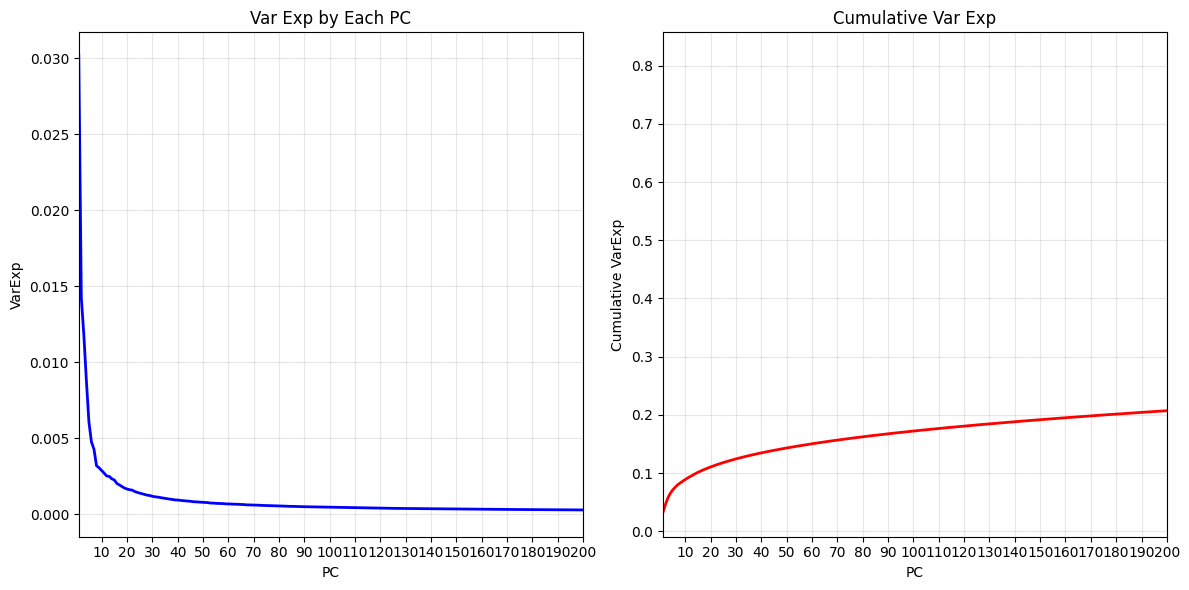

In [68]:
'''
# Var exp in the original SVD
pc_var = (sup_aft1_svd**2).sum(axis=0)
spks = zscore(np.vstack(np.load(os.path.join(root, 'spk', 'TX109_2023_04_07_1_neural_data.npy'), allow_pickle=1).item()['spks']), axis=1)
print(spks.shape)
total_var = (spks**2).sum()
del spks
var_exp = pc_var/total_var
'''
plt.figure(figsize=(12, 6))

# Var exp by PC
plt.subplot(1, 2, 1)
plt.plot(range(1,len(var_exp) + 1),var_exp, 'b-',linewidth=2)
plt.xlabel('PC')
plt.ylabel('VarExp')
plt.title('Var Exp by Each PC')
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(0, 201, 10))
plt.xlim(1, 200)

# Cumulative var exp
plt.subplot(1, 2, 2)
cumulative_var = np.cumsum(var_exp)
plt.plot(range(1,len(cumulative_var) + 1), cumulative_var, 'r-', linewidth=2)
plt.xlabel('PC')
plt.ylabel('Cumulative VarExp')
plt.title('Cumulative Var Exp')
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(0, 201, 10))
plt.xlim(1, 200)

plt.tight_layout()
plt.show()